<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 初期設定

In [ ]:
pip install pygeohash

In [ ]:
pip install catboost

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import joblib
import math

import pygeohash as pgh

from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import gc
gc.collect()

import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# データの読み込み

In [ ]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [ ]:
# 各カラムのデータ型と欠損値（nan）を表示
def information_df(df):
    pd.set_option('display.max_rows', None)
    type_series = df.dtypes
    nunique_series = df.nunique()
    nan_count_series = df.isnull().sum()
    unique_values_series = df.apply(lambda col: list(col.unique()))
    info_df = pd.DataFrame({
        'dtypes': type_series,
        'NaN Count': nan_count_series,
        'Nunique': nunique_series,
        'Unique Values': unique_values_series,
    })
    print(df.shape)
    return info_df

def normal_distribution_fit(df, col):

    # 正規分布のフィッティング
    from scipy.stats import norm
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # カテゴリデータかどうかを判定
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # カテゴリデータの場合
        sns.countplot(x=df[col], ax=ax[0])
        ax[0].set_title('Bar Plot of Categorical Data')
    else:
        # 数値データの場合
        sns.histplot(df[col], kde=True, stat='density', ax=ax[0])
        # 正規分布のフィット
        sns.histplot(df[col], stat='density', ax=ax[0], bins=30)
        x = np.linspace(df[col].min(), df[col].max(), 100)
        ax[0].plot(x, norm.pdf(x, df[col].mean(), df[col].std()), color='red')
        ax[0].set_title('Histogram with Normal Distribution Fit')

        # Q-Qプロット
        stats.probplot(df[col], plot=ax[1])
        ax[1].set_title('Q-Q Plot')

    plt.tight_layout()
    plt.show()

    # 数値データの場合のみ歪度と尖度を計算
    if df[col].dtype != 'object' and df[col].dtype.name != 'category':
        print(f"Skewness: {df[col].skew()}")
        print(f"Kurtosis: {df[col].kurt()}")

    # 欠損値の確認
    print(f"isnull: {df[col].isnull().sum()}")

In [ ]:
information_df(train_df)

(4655, 22)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,4655,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
FacilityName,object,0,4531,"[VISCOFAN USA INC, CORNWELL STATION - DOMINION..."
Latitude,float64,102,4492,"[40.141389, 38.475305, 39.29982, 35.490363, 41..."
Longitude,float64,102,4486,"[-87.581111, -81.278957, -80.85717, -119.04295..."
LocationAddress,object,179,4435,"[915 N MICHIGAN AVE, 200 RIVER HAVEN ROAD, 304..."
City,object,0,2588,"[DANVILLE, CLENDENIN, GREENWOOD, BAKERSFIELD, ..."
State,object,0,54,"[IL, WV, CA, OH, OK, NM, TN, LA, TX, IN, NC, M..."
ZIP,object,0,3758,"[61832, 25045-9304, 26415, 93308, 441031047, 7..."
County,object,70,1165,"[VERMILION, KANAWHA, RITCHIE, KERN, CUYAHOGA, ..."
FIPScode,float64,73,1646,"[17183.0, 54039.0, 54085.0, 6029.0, 39035.0, 4..."


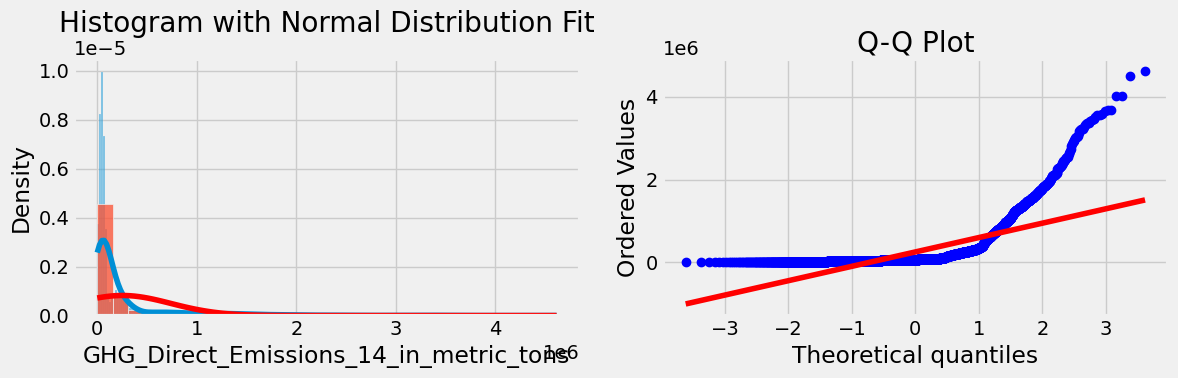

Skewness: 3.6649052199295338
Kurtosis: 16.560320863687245
isnull: 0


In [ ]:
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons')

評価指標はRMSLEであり、ヒストグラムも右に裾が長いグラフなので、対数変換を行う。

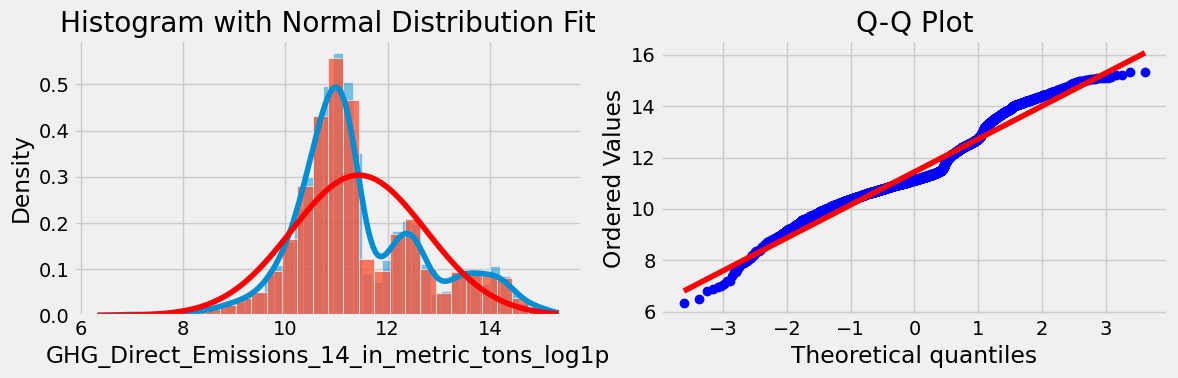

Skewness: 0.545884275422693
Kurtosis: 0.3515490436747801
isnull: 0


In [ ]:
train_df['GHG_Direct_Emissions_14_in_metric_tons_log1p'] = np.log1p(train_df['GHG_Direct_Emissions_14_in_metric_tons'])
normal_distribution_fit(train_df, 'GHG_Direct_Emissions_14_in_metric_tons_log1p')

In [ ]:
information_df(test_df)

(2508, 21)


,dtypes,NaN Count,Nunique,Unique Values
Unnamed: 0,int64,0,2508,"[4655, 4656, 4657, 4658, 4659, 4660, 4661, 466..."
FacilityName,object,0,2462,"[ROGER AOTSCHEGAROW, EPNG STATION 6543 LORDSBU..."
Latitude,float64,56,2437,"[38.03304, 32.31603, 41.2515, 44.95966, 32.818..."
Longitude,float64,56,2435,"[-97.97317, -108.6068, -78.74244, -93.19341, -..."
LocationAddress,object,113,2386,"[1910 SOUTH BROADACRES ROAD, nan, 3831 ROUTE 2..."
City,object,0,1647,"[HUTCHINSON, LORDSBURG, BROCKPORT, SAINT PAUL,..."
State,object,0,54,"[KS, NM, PA, MN, CA, MS, MT, AZ, IN, NY, IL, F..."
ZIP,object,0,2152,"[67501, 88045, 15823, 551141895, 92123, 38606,..."
County,object,45,865,"[RENO, HIDALGO, JEFFERSON, RAMSEY, SAN DIEGO, ..."
FIPScode,float64,45,1162,"[20155.0, 35023.0, 42065.0, 27123.0, 6073.0, 2..."


In [ ]:
def merge_train_test(df_train, df_test):
    if "is_train" not in df_test.columns.tolist():
        df_train["is_train"] = 100
        df_test["is_train"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["is_train"] != -100]
    df_test = df[df["is_train"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(train_df, test_df)

In [ ]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

# GHGの特徴量

In [ ]:
df['GHG_10_log1p'] = np.log1p(df['GHG_Direct_Emissions_10_in_metric_tons'])
df['GHG_11_log1p'] = np.log1p(df['GHG_Direct_Emissions_11_in_metric_tons'])
df['GHG_12_log1p'] = np.log1p(df['GHG_Direct_Emissions_12_in_metric_tons'])
df['GHG_13_log1p'] = np.log1p(df['GHG_Direct_Emissions_13_in_metric_tons'])

# TRIにかかわる特徴量

In [ ]:
# TRIの差の特徴量
df['TRI_diff_11-10'] = df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']
df['TRI_diff_12-11'] = df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']
df['TRI_diff_13-12'] = df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']

# TRIの変化率の特徴量
df['TRI_Growth_Rate_11'] = np.where(
    df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
    (df['TRI_Air_Emissions_11_in_lbs'] - df['TRI_Air_Emissions_10_in_lbs']) / df['TRI_Air_Emissions_10_in_lbs'],
    np.nan
)

df['TRI_Growth_Rate_12'] = np.where(
    df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
    (df['TRI_Air_Emissions_12_in_lbs'] - df['TRI_Air_Emissions_11_in_lbs']) / df['TRI_Air_Emissions_11_in_lbs'],
    np.nan
)

df['TRI_Growth_Rate_13'] = np.where(
    df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
    (df['TRI_Air_Emissions_13_in_lbs'] - df['TRI_Air_Emissions_12_in_lbs']) / df['TRI_Air_Emissions_12_in_lbs'],
    np.nan
)

In [ ]:
df['TRI_10_log1p'] = np.log1p(df['TRI_Air_Emissions_10_in_lbs'])
df['TRI_11_log1p'] = np.log1p(df['TRI_Air_Emissions_11_in_lbs'])
df['TRI_12_log1p'] = np.log1p(df['TRI_Air_Emissions_12_in_lbs'])
df['TRI_13_log1p'] = np.log1p(df['TRI_Air_Emissions_13_in_lbs'])

df['TRI_diff_11-10_log1p'] = np.log1p(df['TRI_diff_11-10'])
df['TRI_diff_12-11_log1p'] = np.log1p(df['TRI_diff_12-11'])
df['TRI_diff_13-12_log1p'] = np.log1p(df['TRI_diff_13-12'])

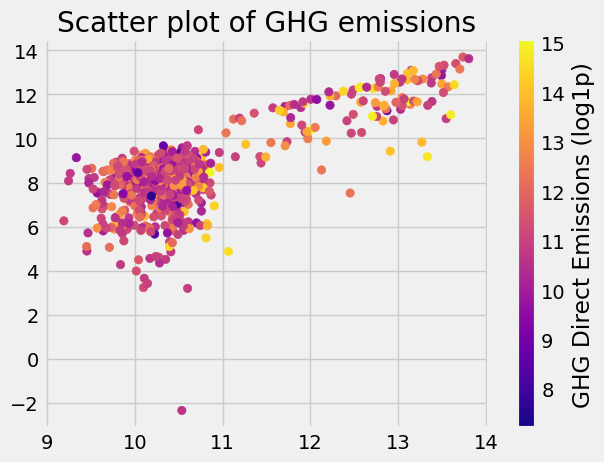

In [ ]:
# 散布図を描画
scatter = plt.scatter(x=df['TRI_13_log1p'], y=df['TRI_diff_13-12_log1p'],
                      c=df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')
plt.title('Scatter plot of GHG emissions')
plt.show()

In [ ]:
# GHG/TRIの特徴量
df['GHG_TRI_rate_10'] = np.where(
    df['TRI_Air_Emissions_10_in_lbs'].notna() & (df['TRI_Air_Emissions_10_in_lbs'] != 0),
    df['GHG_Direct_Emissions_10_in_metric_tons'] / df['TRI_Air_Emissions_10_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_11'] = np.where(
    df['TRI_Air_Emissions_11_in_lbs'].notna() & (df['TRI_Air_Emissions_11_in_lbs'] != 0),
    df['GHG_Direct_Emissions_11_in_metric_tons'] / df['TRI_Air_Emissions_11_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_12'] = np.where(
    df['TRI_Air_Emissions_12_in_lbs'].notna() & (df['TRI_Air_Emissions_12_in_lbs'] != 0),
    df['GHG_Direct_Emissions_12_in_metric_tons'] / df['TRI_Air_Emissions_12_in_lbs'],
    np.nan
)

df['GHG_TRI_rate_13'] = np.where(
    df['TRI_Air_Emissions_13_in_lbs'].notna() & (df['TRI_Air_Emissions_13_in_lbs'] != 0),
    df['GHG_Direct_Emissions_13_in_metric_tons'] / df['TRI_Air_Emissions_13_in_lbs'],
    np.nan
)


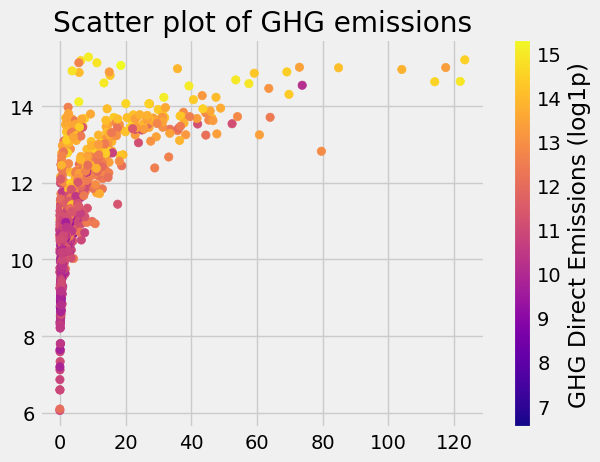

In [ ]:
# 散布図を描画
scatter = plt.scatter(x=df['GHG_TRI_rate_13'], y=df['GHG_13_log1p'],
                      c=df['GHG_Direct_Emissions_14_in_metric_tons_log1p'], cmap='plasma')

plt.colorbar(scatter, label='GHG Direct Emissions (log1p)')
plt.title('Scatter plot of GHG emissions')
plt.show()

# Locationにかかわる特徴量

In [ ]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as colors
# from IPython.display import display

# # 必要なデータを抽出し、新しいデータフレームを作成
# data = train_df[['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']].copy()

# # 緯度、経度、排出量のいずれかが欠損している行を削除
# data.dropna(subset=['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons'], inplace=True)

# # 各列のデータ型を float に変換
# for col in ['Latitude', 'Longitude', 'GHG_Direct_Emissions_14_in_metric_tons']:
#     data[col] = data[col].astype(float)

# # 地図の中心をデータの緯度と経度の平均位置に設定
# map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
# m = folium.Map(location=map_center, zoom_start=5)

# # 排出量の最大値と最小値を取得
# max_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].max()
# min_emission = data['GHG_Direct_Emissions_14_in_metric_tons'].min()

# # カラーマップを設定（排出量が少ない地点は黄色、多い地点は赤色で表示）
# colormap = cm.get_cmap('YlOrRd')
# normalize = colors.Normalize(vmin=min_emission, vmax=max_emission)

# # 各地点に対して、排出量に応じた色の円マーカーを作成し地図に追加
# for idx, row in data.iterrows():
#     # 排出量に基づいて色を設定
#     color = colors.rgb2hex(colormap(normalize(row['GHG_Direct_Emissions_14_in_metric_tons'])))

#     # 円マーカーを作成
#     folium.CircleMarker(
#         location=[row['Latitude'], row['Longitude']],  # 緯度・経度
#         radius=5,  # 円のサイズ
#         popup=f"Emissions: {row['GHG_Direct_Emissions_14_in_metric_tons']}",  # ポップアップに排出量を表示
#         color=color,  # 枠の色
#         fill=True,  # 円を塗りつぶす
#         fill_color=color  # 塗りつぶしの色
#     ).add_to(m)

# # 地図を表示（Jupyter Notebook 上で表示可能）
# display(m)


GHGが高い場所はまばら。地域差や業種に集約できる可能性はあり。
欠損値はそのままとして進める。

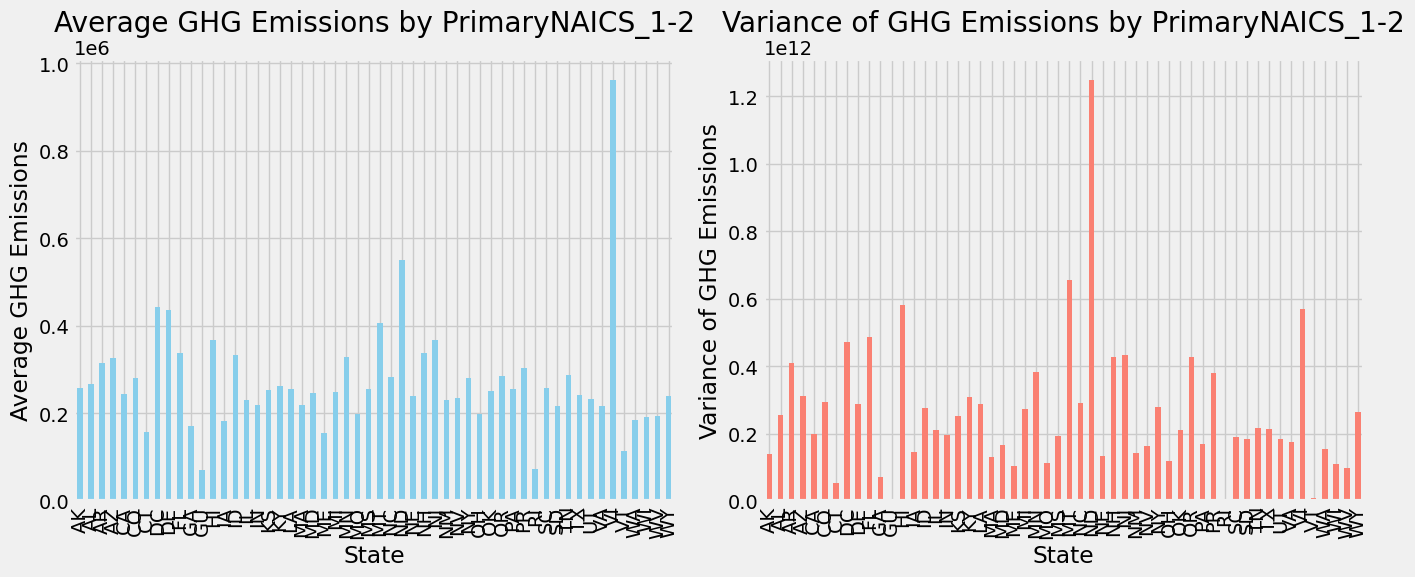

In [ ]:
# Stateの特徴量
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].agg(['mean', 'var'])

# グラフの設定
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 平均のプロット
grouped['mean'].plot(kind='bar', ax=ax[0], color='skyblue', title='Average GHG Emissions by PrimaryNAICS_1-2')
ax[0].set_ylabel('Average GHG Emissions')

# 分散のプロット
grouped['var'].plot(kind='bar', ax=ax[1], color='salmon', title='Variance of GHG Emissions by PrimaryNAICS_1-2')
ax[1].set_ylabel('Variance of GHG Emissions')

plt.tight_layout()
plt.show()

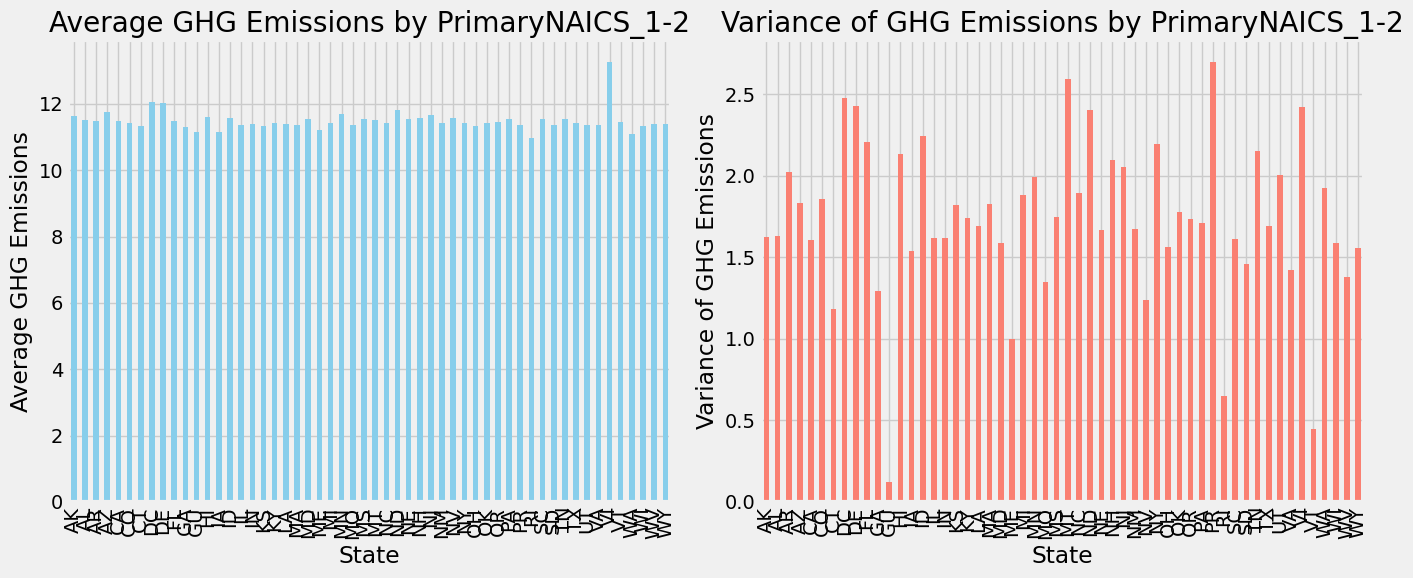

In [ ]:
# Stateの特徴量
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons_log1p'].agg(['mean', 'var'])

# グラフの設定
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 平均のプロット
grouped['mean'].plot(kind='bar', ax=ax[0], color='skyblue', title='Average GHG Emissions by PrimaryNAICS_1-2')
ax[0].set_ylabel('Average GHG Emissions')

# 分散のプロット
grouped['var'].plot(kind='bar', ax=ax[1], color='salmon', title='Variance of GHG Emissions by PrimaryNAICS_1-2')
ax[1].set_ylabel('Variance of GHG Emissions')

plt.tight_layout()
plt.show()

In [ ]:
# ターゲットエンコーディング（State）

# Stateごとの平均、分散、変動係数の計算
grouped = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].agg(['mean', 'var'])
grouped['std'] = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].std()
grouped['cv'] = grouped['std'] / grouped['mean']  # 変動係数

# dfにターゲットエンコーディングを適用
df = df.merge(grouped[['mean', 'var', 'cv']], on='State', how='left')
df.rename(columns={'mean': 'State_GHG_mean', 'var': 'State_GHG_var', 'cv': 'State_GHG_cv'}, inplace=True)

# Stateごとの平均、分散、変動係数の計算
grouped_log1p = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons_log1p'].agg(['mean', 'var'])
grouped_log1p['std'] = train_df.groupby('State')['GHG_Direct_Emissions_14_in_metric_tons'].std()
grouped_log1p['cv'] = grouped['std'] / grouped['mean']  # 変動係数

# dfにターゲットエンコーディングを適用
df = df.merge(grouped_log1p[['mean', 'var', 'cv']], on='State', how='left')
df.rename(columns={'mean': 'State_GHG_mean_log1p', 'var': 'State_GHG_var_log1p', 'cv': 'State_GHG_cv_log1p'}, inplace=True)

# df.columns.tolist()

# industryにかかわる特徴量

'PrimaryNAICS'について

数字に応じたグループあり。
特に最初の2文字が業種を表す。

In [ ]:
# PrimaryNAICSの最初の２文字の分類
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}

# PrimaryNAICSを文字数ごとに分割
df['PrimaryNAICS_1-2'] = df['PrimaryNAICS'].astype(str).str[:2].astype(int)
df['PrimaryNAICS_1-3'] = df['PrimaryNAICS'].astype(str).str[:3].astype(int)
df['PrimaryNAICS_1-4'] = df['PrimaryNAICS'].astype(str).str[:4].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
df['NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# SecondPrimaryNAICSを分類してカテゴリ変数へ変換
df['SecondPrimaryNAICS_1-2'] = pd.to_numeric(df['SecondPrimaryNAICS'].astype(str).str[:2], errors='coerce')
df['Sub_NAICS_Type'] = df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

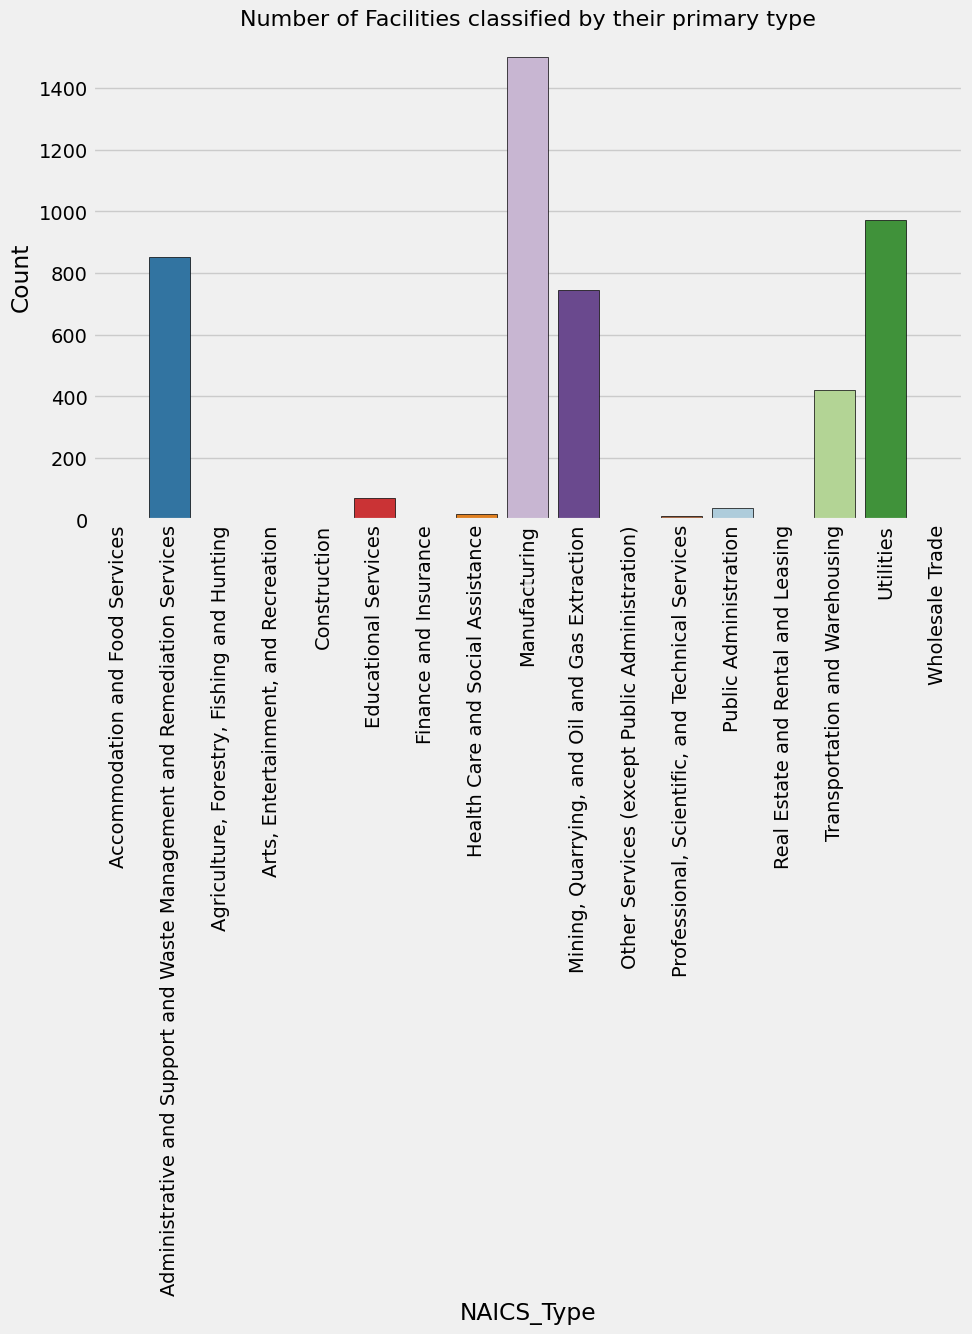

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# データの集計
df_summary = train_df.groupby('NAICS_Type').size().reset_index(name='count')
df_summary = df_summary.sort_values('count', ascending=False)

# カラーパレットの設定
colors = sns.color_palette("Paired", n_colors=20)

# プロットの作成
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=df_summary,
    x='NAICS_Type',
    y='count',
    palette=colors,
    edgecolor='black'
)

# Y軸を対数スケールに設定
# plt.yscale('log')

# タイトルとラベルの設定
plt.title('Number of Facilities classified by their primary type', fontsize=16)
plt.xlabel('NAICS_Type')
plt.ylabel('Count')

# 軸と凡例の設定
plt.xticks(rotation=90)  # x軸のラベルを回転して表示
plt.legend(
    title='',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=5,
    fontsize=6
)

# グラフの表示
plt.tight_layout()
plt.show()


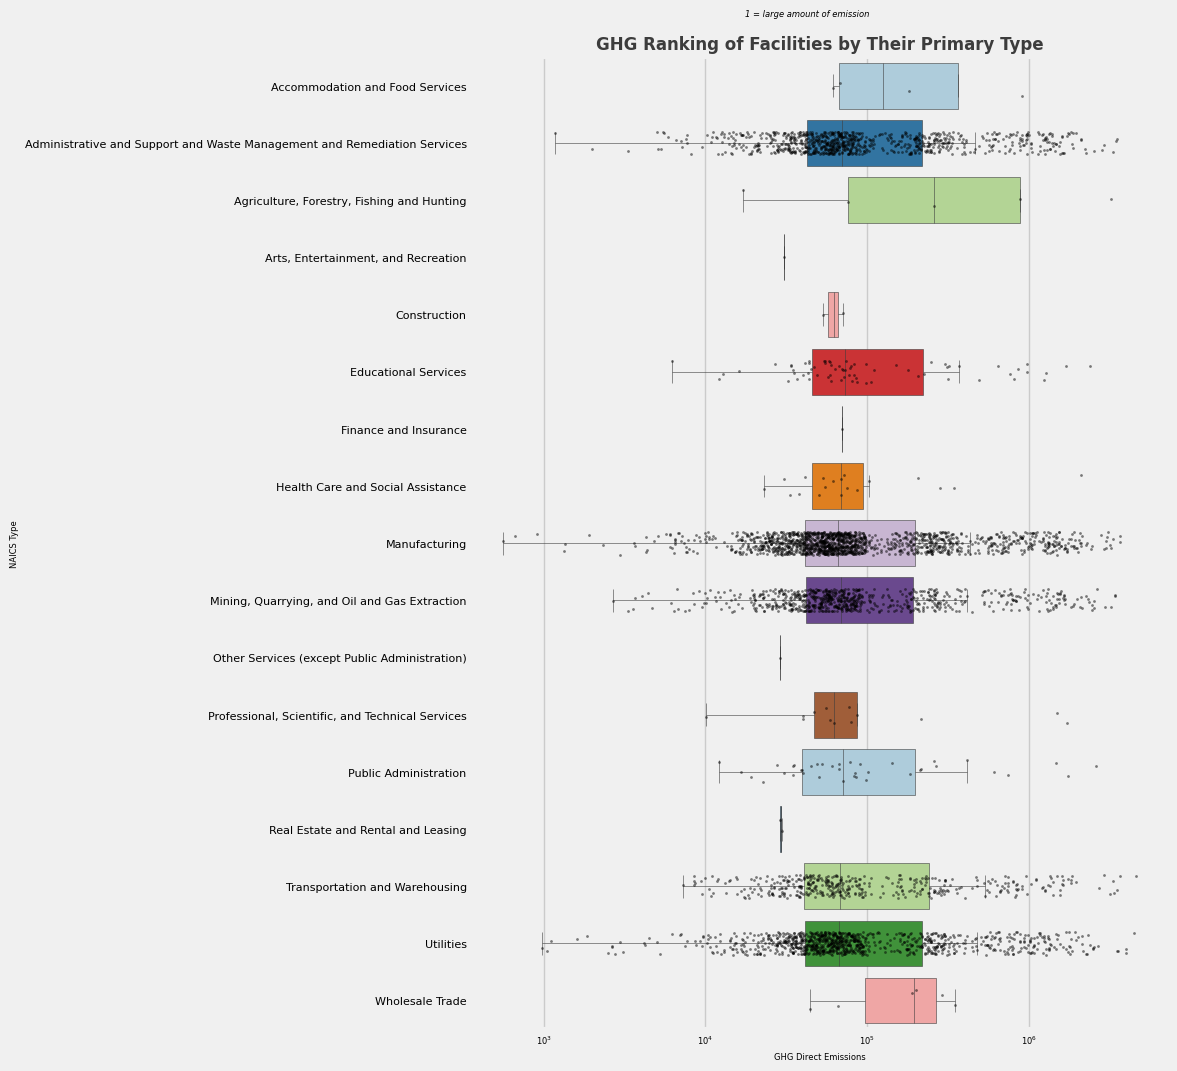

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Assuming df is already loaded as a pandas DataFrame
ghg_df = train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons']]

# Set the style to replicate theme_fivethirtyeight
plt.style.use('fivethirtyeight')

# Create color palette
palette = sns.color_palette("Paired", n_colors=20)

# Set up the figure
plt.figure(figsize=(8, 12))

# Create the boxplot with jitter
sns.boxplot(
    y='NAICS_Type',
    x='GHG_Direct_Emissions_14_in_metric_tons',
    data=ghg_df,
    palette=palette,
    linewidth=0.4,
    fliersize=0,
    whis=1.5
)
sns.stripplot(
    y='NAICS_Type',
    x='GHG_Direct_Emissions_14_in_metric_tons',
    data=ghg_df,
    color='black',
    size=2,
    jitter=0.2,
    alpha=0.5
)

# Set titles and labels
plt.title("GHG Ranking of Facilities by Their Primary Type", fontsize=12, fontweight='bold', color="#3C3C3C")
plt.suptitle("1 = large amount of emission", fontsize=6, style='italic', y=0.92)

# Hide legend
plt.legend([], [], frameon=False)

# Adjust layout
plt.tight_layout()

# Y軸を対数スケールに設定
plt.xscale('log')

# Show the plot
plt.xlabel('GHG Direct Emissions', fontsize=6)
plt.ylabel('NAICS Type', fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=8)

plt.show()


In [ ]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('GHG_Direct_Emissions_14_in_metric_tons', 'size'), meanTri=('GHG_Direct_Emissions_14_in_metric_tons', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
8,Manufacturing,1502,242241.779348
15,Utilities,973,249955.050176
1,Administrative and Support and Waste Managemen...,853,250811.821049
9,"Mining, Quarrying, and Oil and Gas Extraction",744,252928.100287
14,Transportation and Warehousing,420,293777.481256
5,Educational Services,70,251472.609850
12,Public Administration,39,265045.537769
7,Health Care and Social Assistance,19,199722.193130
11,"Professional, Scientific, and Technical Services",13,306494.681102
16,Wholesale Trade,6,189978.439316


データ数の多い５つのグループは若干の平均には違いはあるものの、データの分布数は全体と変わらないように見受けられる。

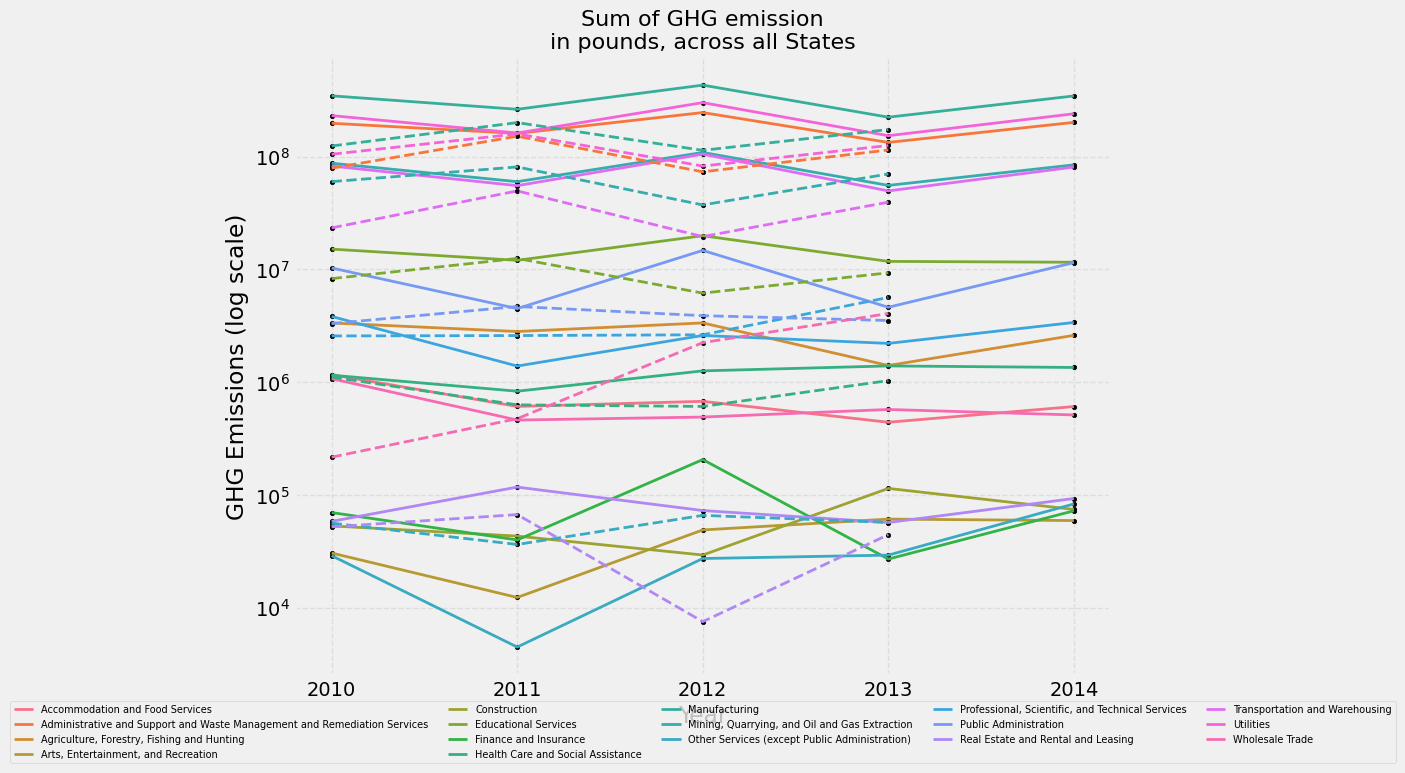

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG.direct.emissions.10': 'sum.GHG.10',
                     'GHG.direct.emissions.11': 'sum.GHG.11',
                     'GHG.direct.emissions.12': 'sum.GHG.12',
                     'GHG.direct.emissions.13': 'sum.GHG.13',
                     'GHG.direct.emissions.14': 'sum.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Data preparation for test GHG_sum
test_ghg_sum = (
    test_df[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'sum.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'sum.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'sum.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'sum.GHG.13'})
)

# Transpose and prepare for plotting
temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['NAICS_Type'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Sum of GHG emission\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


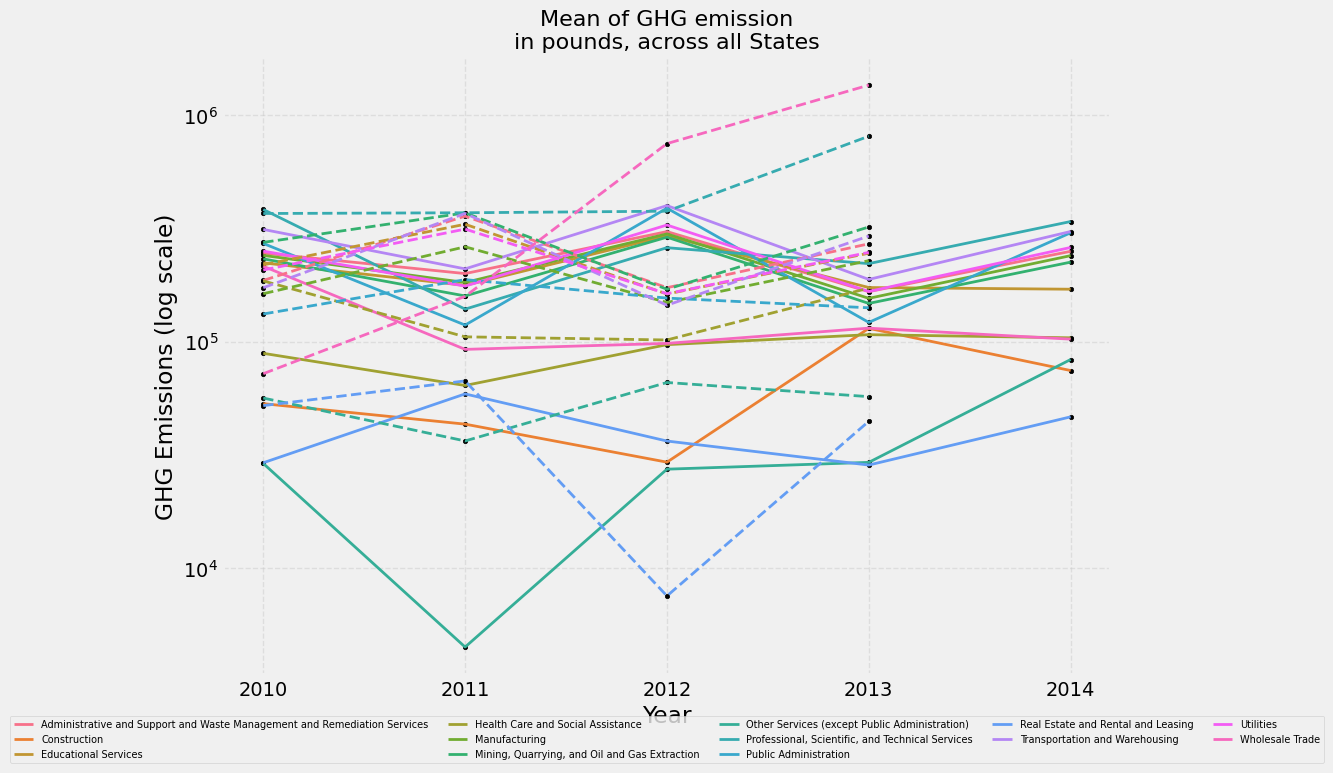

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Data preparation for test GHG_mean
test_ghg_mean = (
    test_df[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13'})
)

# Transpose and prepare for plotting
temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Filter temp_ghg_melt and temp_merged_ghg_melt to include only NAICS_Type present in test data
valid_naics_types = test_ghg_mean['NAICS_Type'].unique()
temp_ghg_melt = temp_ghg_melt[temp_ghg_melt['primary.industry'].isin(valid_naics_types)]
temp_test_ghg_melt = temp_test_ghg_melt[temp_test_ghg_melt['NAICS_Type'].isin(valid_naics_types)]

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['primary.industry'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions with solid lines (train)
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (test, no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Mean of GHG emission\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


合計値や平均なので一概にはいえないが、上位6つのデータでは、trainデータで2010,2012 vs 2011,2013の構図ができている。単純に戻るを回すと2012や2010が重要度が高い理由になっていると思われる。対して、testデータはtrainデータと真逆の挙動を示しており、trainデータを信頼しすぎると、精度が背反する可能性が高い。

In [ ]:
# 各年の差から予測
df['GHG_diff_13_12'] = df['GHG_Direct_Emissions_13_in_metric_tons'] - df['GHG_Direct_Emissions_12_in_metric_tons']
df['GHG_diff_12_11'] = df['GHG_Direct_Emissions_12_in_metric_tons'] - df['GHG_Direct_Emissions_11_in_metric_tons']
df['GHG_diff_11_10'] = df['GHG_Direct_Emissions_11_in_metric_tons'] - df['GHG_Direct_Emissions_10_in_metric_tons']

df['GHG_from_diff_13_12'] = df['GHG_Direct_Emissions_13_in_metric_tons'] + df['GHG_diff_13_12']
df['GHG_from_diff_12_11'] = df['GHG_Direct_Emissions_13_in_metric_tons'] + df['GHG_diff_12_11']

# 直近トレンドをエンコーディング
df['trend_13_12'] = np.where(df['GHG_diff_13_12'] > 0, 1, 0)
df['trend_13_11'] = np.where((df['GHG_diff_13_12'] > 0) & (df['GHG_diff_12_11'] > 0), 1, 0)

In [ ]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = train_df[['NAICS_Type', 'TRI_Air_Emissions_13_in_lbs']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('TRI_Air_Emissions_13_in_lbs', 'size'), meanTri=('TRI_Air_Emissions_13_in_lbs', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
8,Manufacturing,1262,54932.424354
15,Utilities,327,63195.604577
9,"Mining, Quarrying, and Oil and Gas Extraction",20,24554.673169
12,Public Administration,18,28348.151346
16,Wholesale Trade,3,34440.297642
1,Administrative and Support and Waste Managemen...,2,206397.851863
11,"Professional, Scientific, and Technical Services",2,15905.041731
14,Transportation and Warehousing,1,32616.566141
5,Educational Services,0,NaN
6,Finance and Insurance,0,NaN


In [ ]:
# dfからprimary.industryとRank.TRI.14の列を選択し、欠損値を除外
df_filtered = test_df[['NAICS_Type', 'TRI_Air_Emissions_13_in_lbs']].dropna()

# primary.industryでグループ化し、countとmeanを計算
df_summary = (df_filtered
              .groupby('NAICS_Type')
              .agg(count=('TRI_Air_Emissions_13_in_lbs', 'size'), meanTri=('TRI_Air_Emissions_13_in_lbs', 'mean'))
              .reset_index()
              .sort_values(by='count', ascending=False))

df_summary

,NAICS_Type,count,meanTri
4,Manufacturing,650,47436.901056
11,Utilities,197,61593.783965
5,"Mining, Quarrying, and Oil and Gas Extraction",12,29710.991157
8,Public Administration,7,30170.225615
0,Administrative and Support and Waste Managemen...,4,147963.783117
7,"Professional, Scientific, and Technical Services",3,31248.622434
12,Wholesale Trade,1,352529.159773
1,Construction,0,NaN
2,Educational Services,0,NaN
3,Health Care and Social Assistance,0,NaN


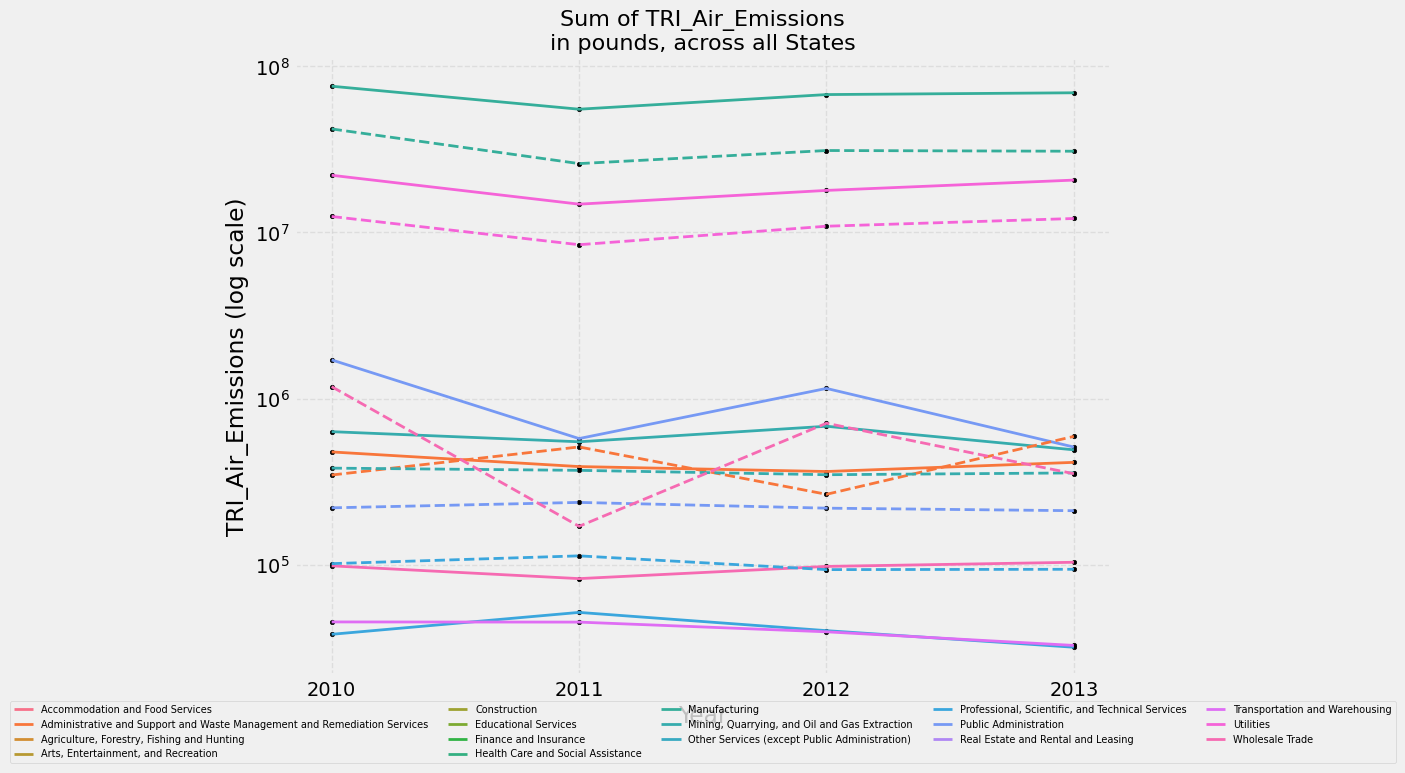

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'TRI_Air_Emissions_10_in_lbs': 'sum.TRI.10',
                     'TRI_Air_Emissions_11_in_lbs': 'sum.TRI.11',
                     'TRI_Air_Emissions_12_in_lbs': 'sum.TRI.12',
                     'TRI_Air_Emissions_13_in_lbs': 'sum.TRI.13',})
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Data preparation for test GHG_sum
test_ghg_sum = (
    test_df[['NAICS_Type', 'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs', 'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'TRI_Air_Emissions_10_in_lbs': 'sum.TRI.10',
                     'TRI_Air_Emissions_11_in_lbs': 'sum.TRI.11',
                     'TRI_Air_Emissions_12_in_lbs': 'sum.TRI.12',
                     'TRI_Air_Emissions_13_in_lbs': 'sum.TRI.13',})
)


# Transpose and prepare for plotting
temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['NAICS_Type'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Sum of TRI_Air_Emissions\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('TRI_Air_Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


データ数が少なく、十分な特徴量を作成するのが難しそう。上位2つのデータは傾向が似ている。GHGのトレンドとは大きく異なる。


# データインプット

In [ ]:
df.columns.tolist()

['Unnamed: 0',
 'FacilityName',
 'Latitude',
 'Longitude',
 'LocationAddress',
 'City',
 'State',
 'ZIP',
 'County',
 'FIPScode',
 'PrimaryNAICS',
 'SecondPrimaryNAICS',
 'IndustryType',
 'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons_log1p',
 'is_train',
 'GHG_10_log1p',
 'GHG_11_log1p',
 'GHG_12_log1p',
 'GHG_13_log1p',
 'TRI_diff_11-10',
 'TRI_diff_12-11',
 'TRI_diff_13-12',
 'TRI_Growth_Rate_11',
 'TRI_Growth_Rate_12',
 'TRI_Growth_Rate_13',
 'TRI_10_log1p',
 'TRI_11_log1p',
 'TRI_12_log1p',
 'TRI_13_log1p',
 'TRI_diff_11-10_log1p',
 'TRI_diff_12-11_log1p',
 'TRI_diff_13-12_log1p',
 'GHG_TRI_rate_10',
 'GHG_TRI_rate_11',
 'GHG_TRI_rate_12',
 'GHG_TRI_r

In [ ]:
features = [
                        'TRI_Air_Emissions_10_in_lbs', 'TRI_Air_Emissions_11_in_lbs',
                    'TRI_Air_Emissions_12_in_lbs', 'TRI_Air_Emissions_13_in_lbs','PrimaryNAICS',
                    'GHG_Direct_Emissions_10_in_metric_tons', 'GHG_Direct_Emissions_11_in_metric_tons',
                    'GHG_Direct_Emissions_12_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons',
                        'Latitude','Longitude',
                        # 'TRI_diff_11-10',
                        'TRI_diff_12-11','TRI_diff_13-12',
                        # 'TRI_Growth_Rate_11',
                        'TRI_Growth_Rate_12','TRI_Growth_Rate_13',
                        'NAICS_Type',
                        # 'GHG_diff_13_12',
 'GHG_diff_12_11',
#  'GHG_diff_11_10',
#  'GHG_from_diff_13_12',
#  'GHG_from_diff_12_11',
 'trend_13_12',
#  'trend_13_11'
]

In [ ]:
train_df, test_df = split_train_test(df)

train = train_df[features]
target = train_df['GHG_Direct_Emissions_14_in_metric_tons']
test = test_df[features]

# ハイパラ調整（Optuna）

In [ ]:
pip install optuna

In [ ]:
import optuna
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold
import numpy as np
import gc

N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

def objective(trial, train, target):
    # Optunaで探索するパラメータ
    lgbm_params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": 3,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.05, 0.5),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 0.01, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1.0, 10.0),
        "random_state": 42,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 50),
        "max_bin": trial.suggest_int("max_bin", 150, 200),
    }

    oof_predictions = np.zeros(len(train))
    fold_rmsle = []
    train_predictions = np.zeros(len(train))

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model = LGBMRegressor(**lgbm_params)
        model.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds = np.expm1(model.predict(X_valid))
        train_preds = np.expm1(model.predict(X_train))

        rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
        rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

        oof_predictions[valid_index] = valid_preds
        train_predictions[train_index] = train_preds

        print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
    print("-" * 50)

    return RMSLE

# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target), n_trials=100)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-12-01 15:49:17,126] A new study created in memory with name: no-name-7ba44cc1-67d9-4477-b584-9f5f425c70da


Fold 0 - Train RMSLE: 0.79565, Valid RMSLE: 0.71899
Fold 1 - Train RMSLE: 0.78951, Valid RMSLE: 0.83716
Fold 2 - Train RMSLE: 0.79231, Valid RMSLE: 0.81785
Fold 3 - Train RMSLE: 0.79625, Valid RMSLE: 0.73613
Fold 4 - Train RMSLE: 0.79046, Valid RMSLE: 0.81971
Fold 5 - Train RMSLE: 0.79000, Valid RMSLE: 0.82756
Fold 6 - Train RMSLE: 0.79344, Valid RMSLE: 0.77235
Fold 7 - Train RMSLE: 0.79069, Valid RMSLE: 0.83704
Fold 8 - Train RMSLE: 0.78561, Valid RMSLE: 0.88863
Fold 9 - Train RMSLE: 0.78858, Valid RMSLE: 0.86050
Fold 10 - Train RMSLE: 0.79191, Valid RMSLE: 0.80081
Fold 11 - Train RMSLE: 0.79198, Valid RMSLE: 0.78240
Fold 12 - Train RMSLE: 0.79404, Valid RMSLE: 0.76563


[I 2024-12-01 15:49:18,429] Trial 0 finished with value: 0.806629790042022 and parameters: {'n_estimators': 30, 'learning_rate': 0.051759996154695176, 'lambda_l1': 0.38841258465837936, 'lambda_l2': 6.588121444045215, 'min_data_in_leaf': 34, 'max_bin': 156}. Best is trial 0 with value: 0.806629790042022.


Fold 13 - Train RMSLE: 0.79048, Valid RMSLE: 0.82257
Fold 14 - Train RMSLE: 0.79105, Valid RMSLE: 0.79462
[CV] tr:0.79064 va:0.80663
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72569, Valid RMSLE: 0.68102
Fold 1 - Train RMSLE: 0.71979, Valid RMSLE: 0.78507
Fold 2 - Train RMSLE: 0.72300, Valid RMSLE: 0.75933
Fold 3 - Train RMSLE: 0.72441, Valid RMSLE: 0.68867
Fold 4 - Train RMSLE: 0.72069, Valid RMSLE: 0.76165
Fold 5 - Train RMSLE: 0.72079, Valid RMSLE: 0.78188
Fold 6 - Train RMSLE: 0.72202, Valid RMSLE: 0.74336
Fold 7 - Train RMSLE: 0.72025, Valid RMSLE: 0.77164
Fold 8 - Train RMSLE: 0.71519, Valid RMSLE: 0.82767
Fold 9 - Train RMSLE: 0.71728, Valid RMSLE: 0.80371
Fold 10 - Train RMSLE: 0.72123, Valid RMSLE: 0.76169
Fold 11 - Train RMSLE: 0.72342, Valid RMSLE: 0.74393
Fold 12 - Train RMSLE: 0.72415, Valid RMSLE: 0.72018
Fold 13 - Train RMSLE: 0.72074, Valid RMSLE: 0.78948


[I 2024-12-01 15:49:21,986] Trial 1 finished with value: 0.7595740502535381 and parameters: {'n_estimators': 81, 'learning_rate': 0.07341736353452073, 'lambda_l1': 0.014591875562161578, 'lambda_l2': 2.947550160570937, 'min_data_in_leaf': 49, 'max_bin': 181}. Best is trial 1 with value: 0.7595740502535381.


Fold 14 - Train RMSLE: 0.72030, Valid RMSLE: 0.76021
[CV] tr:0.72064 va:0.75957
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71224, Valid RMSLE: 0.69865
Fold 1 - Train RMSLE: 0.65446, Valid RMSLE: 0.80758
Fold 2 - Train RMSLE: 0.69534, Valid RMSLE: 0.76891
Fold 3 - Train RMSLE: 0.66772, Valid RMSLE: 0.70740
Fold 4 - Train RMSLE: 0.66851, Valid RMSLE: 0.77356
Fold 5 - Train RMSLE: 0.68826, Valid RMSLE: 0.79385
Fold 6 - Train RMSLE: 0.69156, Valid RMSLE: 0.75931
Fold 7 - Train RMSLE: 0.67234, Valid RMSLE: 0.79576
Fold 8 - Train RMSLE: 0.71313, Valid RMSLE: 0.82939
Fold 9 - Train RMSLE: 0.67984, Valid RMSLE: 0.82679
Fold 10 - Train RMSLE: 0.66449, Valid RMSLE: 0.77553
Fold 11 - Train RMSLE: 0.66323, Valid RMSLE: 0.75947
Fold 12 - Train RMSLE: 0.67199, Valid RMSLE: 0.74555
Fold 13 - Train RMSLE: 0.66355, Valid RMSLE: 0.80750


[I 2024-12-01 15:49:28,014] Trial 2 finished with value: 0.7759031791117174 and parameters: {'n_estimators': 98, 'learning_rate': 0.31002524629431577, 'lambda_l1': 0.3250571138095741, 'lambda_l2': 3.3184442212600063, 'min_data_in_leaf': 37, 'max_bin': 195}. Best is trial 1 with value: 0.7595740502535381.


Fold 14 - Train RMSLE: 0.66063, Valid RMSLE: 0.77655
[CV] tr:0.66212 va:0.77590
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75302, Valid RMSLE: 0.68785
Fold 1 - Train RMSLE: 0.74686, Valid RMSLE: 0.79292
Fold 2 - Train RMSLE: 0.74948, Valid RMSLE: 0.77347
Fold 3 - Train RMSLE: 0.75311, Valid RMSLE: 0.69399
Fold 4 - Train RMSLE: 0.74802, Valid RMSLE: 0.77992
Fold 5 - Train RMSLE: 0.74785, Valid RMSLE: 0.78759
Fold 6 - Train RMSLE: 0.74951, Valid RMSLE: 0.74521
Fold 7 - Train RMSLE: 0.74836, Valid RMSLE: 0.79050
Fold 8 - Train RMSLE: 0.74242, Valid RMSLE: 0.84918
Fold 9 - Train RMSLE: 0.74606, Valid RMSLE: 0.81778
Fold 10 - Train RMSLE: 0.74806, Valid RMSLE: 0.77232
Fold 11 - Train RMSLE: 0.74896, Valid RMSLE: 0.74933
Fold 12 - Train RMSLE: 0.75189, Valid RMSLE: 0.73278
Fold 13 - Train RMSLE: 0.74770, Valid RMSLE: 0.79104


[I 2024-12-01 15:49:30,853] Trial 3 finished with value: 0.7692201481126628 and parameters: {'n_estimators': 15, 'learning_rate': 0.15853769033009849, 'lambda_l1': 0.1374667853765827, 'lambda_l2': 5.623603391800636, 'min_data_in_leaf': 40, 'max_bin': 166}. Best is trial 1 with value: 0.7595740502535381.


Fold 14 - Train RMSLE: 0.74792, Valid RMSLE: 0.75823
[CV] tr:0.74772 va:0.76922
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72909, Valid RMSLE: 0.68649
Fold 1 - Train RMSLE: 0.72227, Valid RMSLE: 0.78282
Fold 2 - Train RMSLE: 0.72467, Valid RMSLE: 0.76135
Fold 3 - Train RMSLE: 0.72850, Valid RMSLE: 0.68762
Fold 4 - Train RMSLE: 0.72345, Valid RMSLE: 0.76540
Fold 5 - Train RMSLE: 0.72371, Valid RMSLE: 0.77916
Fold 6 - Train RMSLE: 0.72565, Valid RMSLE: 0.74174
Fold 7 - Train RMSLE: 0.72324, Valid RMSLE: 0.77000
Fold 8 - Train RMSLE: 0.71840, Valid RMSLE: 0.83279
Fold 9 - Train RMSLE: 0.72037, Valid RMSLE: 0.80791
Fold 10 - Train RMSLE: 0.72449, Valid RMSLE: 0.76287
Fold 11 - Train RMSLE: 0.72481, Valid RMSLE: 0.74548
Fold 12 - Train RMSLE: 0.72696, Valid RMSLE: 0.72114
Fold 13 - Train RMSLE: 0.72228, Valid RMSLE: 0.78691


[I 2024-12-01 15:49:35,099] Trial 4 finished with value: 0.7601834887781803 and parameters: {'n_estimators': 74, 'learning_rate': 0.07006853970420977, 'lambda_l1': 0.02708516787492903, 'lambda_l2': 6.6156730367328995, 'min_data_in_leaf': 43, 'max_bin': 191}. Best is trial 1 with value: 0.7595740502535381.


Fold 14 - Train RMSLE: 0.72211, Valid RMSLE: 0.75693
[CV] tr:0.72240 va:0.76018
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72629, Valid RMSLE: 0.68188
Fold 1 - Train RMSLE: 0.72134, Valid RMSLE: 0.78700
Fold 2 - Train RMSLE: 0.72358, Valid RMSLE: 0.76182
Fold 3 - Train RMSLE: 0.72552, Valid RMSLE: 0.68310
Fold 4 - Train RMSLE: 0.72173, Valid RMSLE: 0.76622
Fold 5 - Train RMSLE: 0.72277, Valid RMSLE: 0.78025
Fold 6 - Train RMSLE: 0.72367, Valid RMSLE: 0.74047
Fold 7 - Train RMSLE: 0.72246, Valid RMSLE: 0.76494
Fold 8 - Train RMSLE: 0.71969, Valid RMSLE: 0.83200
Fold 9 - Train RMSLE: 0.71721, Valid RMSLE: 0.80776
Fold 10 - Train RMSLE: 0.72413, Valid RMSLE: 0.75926
Fold 11 - Train RMSLE: 0.72315, Valid RMSLE: 0.74109
Fold 12 - Train RMSLE: 0.72555, Valid RMSLE: 0.72181
Fold 13 - Train RMSLE: 0.72153, Valid RMSLE: 0.78767


[I 2024-12-01 15:49:37,987] Trial 5 finished with value: 0.7589270367741038 and parameters: {'n_estimators': 41, 'learning_rate': 0.14964044132601856, 'lambda_l1': 0.1323238630473236, 'lambda_l2': 4.657413317144985, 'min_data_in_leaf': 49, 'max_bin': 156}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.72099, Valid RMSLE: 0.75338
[CV] tr:0.72155 va:0.75893
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71575, Valid RMSLE: 0.68720
Fold 1 - Train RMSLE: 0.68656, Valid RMSLE: 0.79129
Fold 2 - Train RMSLE: 0.70249, Valid RMSLE: 0.77368
Fold 3 - Train RMSLE: 0.69822, Valid RMSLE: 0.68872
Fold 4 - Train RMSLE: 0.68689, Valid RMSLE: 0.76535
Fold 5 - Train RMSLE: 0.70148, Valid RMSLE: 0.77094
Fold 6 - Train RMSLE: 0.72454, Valid RMSLE: 0.74130
Fold 7 - Train RMSLE: 0.67872, Valid RMSLE: 0.77875
Fold 8 - Train RMSLE: 0.68716, Valid RMSLE: 0.82115
Fold 9 - Train RMSLE: 0.68650, Valid RMSLE: 0.81919
Fold 10 - Train RMSLE: 0.69668, Valid RMSLE: 0.77604
Fold 11 - Train RMSLE: 0.68978, Valid RMSLE: 0.74598
Fold 12 - Train RMSLE: 0.69099, Valid RMSLE: 0.73095
Fold 13 - Train RMSLE: 0.67908, Valid RMSLE: 0.80016


[I 2024-12-01 15:49:45,941] Trial 6 finished with value: 0.7652980298855102 and parameters: {'n_estimators': 92, 'learning_rate': 0.21143766049044105, 'lambda_l1': 0.3229716659784444, 'lambda_l2': 2.785559239183237, 'min_data_in_leaf': 31, 'max_bin': 194}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.68334, Valid RMSLE: 0.77443
[CV] tr:0.68429 va:0.76530
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72010, Valid RMSLE: 0.70441
Fold 1 - Train RMSLE: 0.70381, Valid RMSLE: 0.78163
Fold 2 - Train RMSLE: 0.70954, Valid RMSLE: 0.76570
Fold 3 - Train RMSLE: 0.70549, Valid RMSLE: 0.69048
Fold 4 - Train RMSLE: 0.72665, Valid RMSLE: 0.77057
Fold 5 - Train RMSLE: 0.70348, Valid RMSLE: 0.80079
Fold 6 - Train RMSLE: 0.71803, Valid RMSLE: 0.75350
Fold 7 - Train RMSLE: 0.69976, Valid RMSLE: 0.78416
Fold 8 - Train RMSLE: 0.71292, Valid RMSLE: 0.82427
Fold 9 - Train RMSLE: 0.71427, Valid RMSLE: 0.81487
Fold 10 - Train RMSLE: 0.70082, Valid RMSLE: 0.77037
Fold 11 - Train RMSLE: 0.69871, Valid RMSLE: 0.75725


[I 2024-12-01 15:49:48,231] Trial 7 finished with value: 0.7686188866514208 and parameters: {'n_estimators': 36, 'learning_rate': 0.3997795290232163, 'lambda_l1': 0.16625705132538374, 'lambda_l2': 9.319108447714747, 'min_data_in_leaf': 44, 'max_bin': 189}. Best is trial 5 with value: 0.7589270367741038.


Fold 12 - Train RMSLE: 0.71572, Valid RMSLE: 0.73237
Fold 13 - Train RMSLE: 0.70642, Valid RMSLE: 0.79690
Fold 14 - Train RMSLE: 0.69671, Valid RMSLE: 0.76981
[CV] tr:0.69811 va:0.76862
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73928, Valid RMSLE: 0.68402
Fold 1 - Train RMSLE: 0.73250, Valid RMSLE: 0.78278
Fold 2 - Train RMSLE: 0.73495, Valid RMSLE: 0.76079
Fold 3 - Train RMSLE: 0.73809, Valid RMSLE: 0.68896
Fold 4 - Train RMSLE: 0.73455, Valid RMSLE: 0.76497
Fold 5 - Train RMSLE: 0.73322, Valid RMSLE: 0.78356
Fold 6 - Train RMSLE: 0.73497, Valid RMSLE: 0.73759
Fold 7 - Train RMSLE: 0.73414, Valid RMSLE: 0.77657
Fold 8 - Train RMSLE: 0.72952, Valid RMSLE: 0.83677
Fold 9 - Train RMSLE: 0.73122, Valid RMSLE: 0.81107
Fold 10 - Train RMSLE: 0.73396, Valid RMSLE: 0.76459
Fold 11 - Train RMSLE: 0.73606, Valid RMSLE: 0.74862


[I 2024-12-01 15:49:49,545] Trial 8 finished with value: 0.7618943124661415 and parameters: {'n_estimators': 46, 'learning_rate': 0.0815697634133539, 'lambda_l1': 5.592304442211266, 'lambda_l2': 2.2707433792335014, 'min_data_in_leaf': 48, 'max_bin': 162}. Best is trial 5 with value: 0.7589270367741038.


Fold 12 - Train RMSLE: 0.73682, Valid RMSLE: 0.72963
Fold 13 - Train RMSLE: 0.73296, Valid RMSLE: 0.78425
Fold 14 - Train RMSLE: 0.73378, Valid RMSLE: 0.75963
[CV] tr:0.73396 va:0.76189
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71473, Valid RMSLE: 0.68619
Fold 1 - Train RMSLE: 0.69165, Valid RMSLE: 0.78585
Fold 2 - Train RMSLE: 0.70086, Valid RMSLE: 0.76747
Fold 3 - Train RMSLE: 0.69063, Valid RMSLE: 0.69627
Fold 4 - Train RMSLE: 0.68511, Valid RMSLE: 0.76089
Fold 5 - Train RMSLE: 0.68319, Valid RMSLE: 0.78344
Fold 6 - Train RMSLE: 0.71940, Valid RMSLE: 0.74931
Fold 7 - Train RMSLE: 0.68319, Valid RMSLE: 0.77332
Fold 8 - Train RMSLE: 0.68287, Valid RMSLE: 0.82308
Fold 9 - Train RMSLE: 0.68704, Valid RMSLE: 0.81552
Fold 10 - Train RMSLE: 0.70537, Valid RMSLE: 0.76864
Fold 11 - Train RMSLE: 0.68377, Valid RMSLE: 0.74620
Fold 12 - Train RMSLE: 0.68795, Valid RMSLE: 0.72388
Fold 13 - Train RMSLE: 0.68599, Valid RMSLE: 0.78688


[I 2024-12-01 15:49:51,579] Trial 9 finished with value: 0.7633461621790347 and parameters: {'n_estimators': 98, 'learning_rate': 0.18813903862355216, 'lambda_l1': 0.014760239552117246, 'lambda_l2': 1.0052575121260725, 'min_data_in_leaf': 48, 'max_bin': 193}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.68760, Valid RMSLE: 0.77022
[CV] tr:0.68852 va:0.76335
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72702, Valid RMSLE: 0.68618
Fold 1 - Train RMSLE: 0.71538, Valid RMSLE: 0.77942
Fold 2 - Train RMSLE: 0.71772, Valid RMSLE: 0.76234
Fold 3 - Train RMSLE: 0.72230, Valid RMSLE: 0.69010
Fold 4 - Train RMSLE: 0.71792, Valid RMSLE: 0.75924
Fold 5 - Train RMSLE: 0.71617, Valid RMSLE: 0.77682
Fold 6 - Train RMSLE: 0.72025, Valid RMSLE: 0.74170
Fold 7 - Train RMSLE: 0.71619, Valid RMSLE: 0.77233
Fold 8 - Train RMSLE: 0.71269, Valid RMSLE: 0.82941
Fold 9 - Train RMSLE: 0.71417, Valid RMSLE: 0.80416
Fold 10 - Train RMSLE: 0.71829, Valid RMSLE: 0.76649
Fold 11 - Train RMSLE: 0.71808, Valid RMSLE: 0.74046
Fold 12 - Train RMSLE: 0.71977, Valid RMSLE: 0.72405


[I 2024-12-01 15:49:53,160] Trial 10 finished with value: 0.7593312895125484 and parameters: {'n_estimators': 63, 'learning_rate': 0.11832634134162565, 'lambda_l1': 2.342228270495289, 'lambda_l2': 1.537364619078407, 'min_data_in_leaf': 43, 'max_bin': 150}. Best is trial 5 with value: 0.7589270367741038.


Fold 13 - Train RMSLE: 0.71419, Valid RMSLE: 0.78769
Fold 14 - Train RMSLE: 0.71403, Valid RMSLE: 0.75632
[CV] tr:0.71458 va:0.75933
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72569, Valid RMSLE: 0.68483
Fold 1 - Train RMSLE: 0.71763, Valid RMSLE: 0.78228
Fold 2 - Train RMSLE: 0.71977, Valid RMSLE: 0.76475
Fold 3 - Train RMSLE: 0.72313, Valid RMSLE: 0.68544
Fold 4 - Train RMSLE: 0.72042, Valid RMSLE: 0.76083
Fold 5 - Train RMSLE: 0.71783, Valid RMSLE: 0.78126
Fold 6 - Train RMSLE: 0.72325, Valid RMSLE: 0.74163
Fold 7 - Train RMSLE: 0.71799, Valid RMSLE: 0.77112
Fold 8 - Train RMSLE: 0.71419, Valid RMSLE: 0.83037
Fold 9 - Train RMSLE: 0.71594, Valid RMSLE: 0.80543
Fold 10 - Train RMSLE: 0.71995, Valid RMSLE: 0.76679
Fold 11 - Train RMSLE: 0.72017, Valid RMSLE: 0.74249
Fold 12 - Train RMSLE: 0.72134, Valid RMSLE: 0.72211


[I 2024-12-01 15:49:54,722] Trial 11 finished with value: 0.7596851259795072 and parameters: {'n_estimators': 63, 'learning_rate': 0.11130306166306658, 'lambda_l1': 2.804606513666762, 'lambda_l2': 1.3322373427074958, 'min_data_in_leaf': 44, 'max_bin': 154}. Best is trial 5 with value: 0.7589270367741038.


Fold 13 - Train RMSLE: 0.71953, Valid RMSLE: 0.78295
Fold 14 - Train RMSLE: 0.71889, Valid RMSLE: 0.75890
[CV] tr:0.71942 va:0.75969
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72495, Valid RMSLE: 0.68553
Fold 1 - Train RMSLE: 0.71826, Valid RMSLE: 0.77910
Fold 2 - Train RMSLE: 0.72086, Valid RMSLE: 0.76274
Fold 3 - Train RMSLE: 0.72337, Valid RMSLE: 0.68877
Fold 4 - Train RMSLE: 0.72057, Valid RMSLE: 0.76154
Fold 5 - Train RMSLE: 0.72064, Valid RMSLE: 0.77538
Fold 6 - Train RMSLE: 0.72262, Valid RMSLE: 0.74201
Fold 7 - Train RMSLE: 0.71956, Valid RMSLE: 0.77142
Fold 8 - Train RMSLE: 0.71705, Valid RMSLE: 0.83011
Fold 9 - Train RMSLE: 0.71592, Valid RMSLE: 0.80481
Fold 10 - Train RMSLE: 0.72071, Valid RMSLE: 0.76089
Fold 11 - Train RMSLE: 0.72290, Valid RMSLE: 0.74237
Fold 12 - Train RMSLE: 0.72452, Valid RMSLE: 0.72299
Fold 13 - Train RMSLE: 0.71652, Valid RMSLE: 0.78830
Fold 14 - Train RMSLE: 0.71875, Valid RMSLE: 0.75725


[I 2024-12-01 15:49:56,205] Trial 12 finished with value: 0.759113474275297 and parameters: {'n_estimators': 57, 'learning_rate': 0.11758822181138401, 'lambda_l1': 1.4476817706935339, 'lambda_l2': 1.7480562764649863, 'min_data_in_leaf': 50, 'max_bin': 150}. Best is trial 5 with value: 0.7589270367741038.


[CV] tr:0.71904 va:0.75911
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72826, Valid RMSLE: 0.68025
Fold 1 - Train RMSLE: 0.72114, Valid RMSLE: 0.78342
Fold 2 - Train RMSLE: 0.72400, Valid RMSLE: 0.76070
Fold 3 - Train RMSLE: 0.72748, Valid RMSLE: 0.69004
Fold 4 - Train RMSLE: 0.72255, Valid RMSLE: 0.76489
Fold 5 - Train RMSLE: 0.72189, Valid RMSLE: 0.77937
Fold 6 - Train RMSLE: 0.72616, Valid RMSLE: 0.74173
Fold 7 - Train RMSLE: 0.72201, Valid RMSLE: 0.77678
Fold 8 - Train RMSLE: 0.71738, Valid RMSLE: 0.83185
Fold 9 - Train RMSLE: 0.71926, Valid RMSLE: 0.80964
Fold 10 - Train RMSLE: 0.72380, Valid RMSLE: 0.76413
Fold 11 - Train RMSLE: 0.72314, Valid RMSLE: 0.74522
Fold 12 - Train RMSLE: 0.72651, Valid RMSLE: 0.72479
Fold 13 - Train RMSLE: 0.72184, Valid RMSLE: 0.78631


[I 2024-12-01 15:49:57,796] Trial 13 finished with value: 0.76056805613554 and parameters: {'n_estimators': 49, 'learning_rate': 0.12121890804296472, 'lambda_l1': 1.1834710754853859, 'lambda_l2': 4.66577605511247, 'min_data_in_leaf': 50, 'max_bin': 167}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.72252, Valid RMSLE: 0.75490
[CV] tr:0.72289 va:0.76057
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72816, Valid RMSLE: 0.68460
Fold 1 - Train RMSLE: 0.72130, Valid RMSLE: 0.77827
Fold 2 - Train RMSLE: 0.72458, Valid RMSLE: 0.76607
Fold 3 - Train RMSLE: 0.72898, Valid RMSLE: 0.68761
Fold 4 - Train RMSLE: 0.72575, Valid RMSLE: 0.76337
Fold 5 - Train RMSLE: 0.72457, Valid RMSLE: 0.78618
Fold 6 - Train RMSLE: 0.72717, Valid RMSLE: 0.73592
Fold 7 - Train RMSLE: 0.72329, Valid RMSLE: 0.77559
Fold 8 - Train RMSLE: 0.71736, Valid RMSLE: 0.83326
Fold 9 - Train RMSLE: 0.72090, Valid RMSLE: 0.80761
Fold 10 - Train RMSLE: 0.72403, Valid RMSLE: 0.76277
Fold 11 - Train RMSLE: 0.72426, Valid RMSLE: 0.74296


[I 2024-12-01 15:49:59,322] Trial 14 finished with value: 0.76056146016202 and parameters: {'n_estimators': 27, 'learning_rate': 0.19727407095672023, 'lambda_l1': 0.04841379533661493, 'lambda_l2': 1.9187822889636406, 'min_data_in_leaf': 46, 'max_bin': 173}. Best is trial 5 with value: 0.7589270367741038.


Fold 12 - Train RMSLE: 0.72646, Valid RMSLE: 0.72417
Fold 13 - Train RMSLE: 0.72374, Valid RMSLE: 0.78471
Fold 14 - Train RMSLE: 0.72489, Valid RMSLE: 0.76081
[CV] tr:0.72504 va:0.76056
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71718, Valid RMSLE: 0.68737
Fold 1 - Train RMSLE: 0.69286, Valid RMSLE: 0.78457
Fold 2 - Train RMSLE: 0.69920, Valid RMSLE: 0.77176
Fold 3 - Train RMSLE: 0.71444, Valid RMSLE: 0.68785
Fold 4 - Train RMSLE: 0.69768, Valid RMSLE: 0.75872
Fold 5 - Train RMSLE: 0.70294, Valid RMSLE: 0.77512
Fold 6 - Train RMSLE: 0.72522, Valid RMSLE: 0.74672
Fold 7 - Train RMSLE: 0.69751, Valid RMSLE: 0.77671
Fold 8 - Train RMSLE: 0.68904, Valid RMSLE: 0.82940
Fold 9 - Train RMSLE: 0.69775, Valid RMSLE: 0.82160
Fold 10 - Train RMSLE: 0.70879, Valid RMSLE: 0.77120
Fold 11 - Train RMSLE: 0.70123, Valid RMSLE: 0.74649
Fold 12 - Train RMSLE: 0.69569, Valid RMSLE: 0.73291
Fold 13 - Train RMSLE: 0.69744, Valid RMSLE: 0.79112


[I 2024-12-01 15:50:01,516] Trial 15 finished with value: 0.7640673332271262 and parameters: {'n_estimators': 58, 'learning_rate': 0.2702936086335652, 'lambda_l1': 0.8604172143629956, 'lambda_l2': 4.3763077626995655, 'min_data_in_leaf': 39, 'max_bin': 158}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.69312, Valid RMSLE: 0.76518
[CV] tr:0.69417 va:0.76407
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73732, Valid RMSLE: 0.68160
Fold 1 - Train RMSLE: 0.73045, Valid RMSLE: 0.78266
Fold 2 - Train RMSLE: 0.73273, Valid RMSLE: 0.76290
Fold 3 - Train RMSLE: 0.73625, Valid RMSLE: 0.68740
Fold 4 - Train RMSLE: 0.73219, Valid RMSLE: 0.76692
Fold 5 - Train RMSLE: 0.73176, Valid RMSLE: 0.78201
Fold 6 - Train RMSLE: 0.73397, Valid RMSLE: 0.73839
Fold 7 - Train RMSLE: 0.73217, Valid RMSLE: 0.77644
Fold 8 - Train RMSLE: 0.72759, Valid RMSLE: 0.83795
Fold 9 - Train RMSLE: 0.72921, Valid RMSLE: 0.80285
Fold 10 - Train RMSLE: 0.73329, Valid RMSLE: 0.76514
Fold 11 - Train RMSLE: 0.73238, Valid RMSLE: 0.74685
Fold 12 - Train RMSLE: 0.73479, Valid RMSLE: 0.72258
Fold 13 - Train RMSLE: 0.72993, Valid RMSLE: 0.78795


[I 2024-12-01 15:50:02,993] Trial 16 finished with value: 0.7608239503763488 and parameters: {'n_estimators': 36, 'learning_rate': 0.10076746063300099, 'lambda_l1': 0.07614852534580137, 'lambda_l2': 4.094603498444811, 'min_data_in_leaf': 47, 'max_bin': 150}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.73166, Valid RMSLE: 0.75562
[CV] tr:0.73197 va:0.76082
--------------------------------------------------
Fold 0 - Train RMSLE: 0.76438, Valid RMSLE: 0.69559
Fold 1 - Train RMSLE: 0.75806, Valid RMSLE: 0.80701
Fold 2 - Train RMSLE: 0.75947, Valid RMSLE: 0.78677
Fold 3 - Train RMSLE: 0.76408, Valid RMSLE: 0.70960
Fold 4 - Train RMSLE: 0.75897, Valid RMSLE: 0.78641
Fold 5 - Train RMSLE: 0.75777, Valid RMSLE: 0.79983
Fold 6 - Train RMSLE: 0.76024, Valid RMSLE: 0.75077
Fold 7 - Train RMSLE: 0.75784, Valid RMSLE: 0.80397
Fold 8 - Train RMSLE: 0.75380, Valid RMSLE: 0.85911
Fold 9 - Train RMSLE: 0.75634, Valid RMSLE: 0.82541
Fold 10 - Train RMSLE: 0.75856, Valid RMSLE: 0.77352


[I 2024-12-01 15:50:03,858] Trial 17 finished with value: 0.7787707605152774 and parameters: {'n_estimators': 15, 'learning_rate': 0.13508656694259238, 'lambda_l1': 0.9063340763070087, 'lambda_l2': 1.943505910117263, 'min_data_in_leaf': 50, 'max_bin': 176}. Best is trial 5 with value: 0.7589270367741038.


Fold 11 - Train RMSLE: 0.75844, Valid RMSLE: 0.75815
Fold 12 - Train RMSLE: 0.76227, Valid RMSLE: 0.73993
Fold 13 - Train RMSLE: 0.75799, Valid RMSLE: 0.79857
Fold 14 - Train RMSLE: 0.75819, Valid RMSLE: 0.77084
[CV] tr:0.75803 va:0.77877
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72226, Valid RMSLE: 0.69695
Fold 1 - Train RMSLE: 0.68011, Valid RMSLE: 0.76563
Fold 2 - Train RMSLE: 0.68076, Valid RMSLE: 0.77879
Fold 3 - Train RMSLE: 0.67937, Valid RMSLE: 0.71256
Fold 4 - Train RMSLE: 0.67835, Valid RMSLE: 0.76954
Fold 5 - Train RMSLE: 0.68900, Valid RMSLE: 0.78468
Fold 6 - Train RMSLE: 0.70503, Valid RMSLE: 0.74180
Fold 7 - Train RMSLE: 0.67584, Valid RMSLE: 0.78552
Fold 8 - Train RMSLE: 0.67651, Valid RMSLE: 0.83129
Fold 9 - Train RMSLE: 0.68202, Valid RMSLE: 0.81994
Fold 10 - Train RMSLE: 0.68349, Valid RMSLE: 0.76823
Fold 11 - Train RMSLE: 0.71746, Valid RMSLE: 0.74990
Fold 12 - Train RMSLE: 0.68583, Valid RMSLE: 0.74331
Fold 13 - Train RMSLE: 0.67469,

[I 2024-12-01 15:50:05,695] Trial 18 finished with value: 0.7687542029305843 and parameters: {'n_estimators': 74, 'learning_rate': 0.48870039656030545, 'lambda_l1': 9.679010820019181, 'lambda_l2': 1.3170884710224617, 'min_data_in_leaf': 46, 'max_bin': 161}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.67748, Valid RMSLE: 0.78042
[CV] tr:0.67829 va:0.76875
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72120, Valid RMSLE: 0.68738
Fold 1 - Train RMSLE: 0.71520, Valid RMSLE: 0.78262
Fold 2 - Train RMSLE: 0.71474, Valid RMSLE: 0.76938
Fold 3 - Train RMSLE: 0.71964, Valid RMSLE: 0.68590
Fold 4 - Train RMSLE: 0.71794, Valid RMSLE: 0.76366
Fold 5 - Train RMSLE: 0.71461, Valid RMSLE: 0.77983
Fold 6 - Train RMSLE: 0.71941, Valid RMSLE: 0.74183
Fold 7 - Train RMSLE: 0.71577, Valid RMSLE: 0.77286
Fold 8 - Train RMSLE: 0.71150, Valid RMSLE: 0.82602
Fold 9 - Train RMSLE: 0.71520, Valid RMSLE: 0.81156
Fold 10 - Train RMSLE: 0.71582, Valid RMSLE: 0.76622
Fold 11 - Train RMSLE: 0.71565, Valid RMSLE: 0.74497
Fold 12 - Train RMSLE: 0.71913, Valid RMSLE: 0.72236


[I 2024-12-01 15:50:07,056] Trial 19 finished with value: 0.7605765397476546 and parameters: {'n_estimators': 48, 'learning_rate': 0.15663988642034501, 'lambda_l1': 0.13086900542643745, 'lambda_l2': 2.435445501507082, 'min_data_in_leaf': 41, 'max_bin': 168}. Best is trial 5 with value: 0.7589270367741038.


Fold 13 - Train RMSLE: 0.71566, Valid RMSLE: 0.78320
Fold 14 - Train RMSLE: 0.71314, Valid RMSLE: 0.75706
[CV] tr:0.71353 va:0.76058
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71970, Valid RMSLE: 0.69473
Fold 1 - Train RMSLE: 0.71474, Valid RMSLE: 0.78227
Fold 2 - Train RMSLE: 0.71264, Valid RMSLE: 0.77208
Fold 3 - Train RMSLE: 0.71611, Valid RMSLE: 0.68621
Fold 4 - Train RMSLE: 0.70897, Valid RMSLE: 0.76009
Fold 5 - Train RMSLE: 0.70855, Valid RMSLE: 0.78152
Fold 6 - Train RMSLE: 0.71785, Valid RMSLE: 0.74604
Fold 7 - Train RMSLE: 0.70879, Valid RMSLE: 0.77138
Fold 8 - Train RMSLE: 0.70969, Valid RMSLE: 0.82473
Fold 9 - Train RMSLE: 0.71154, Valid RMSLE: 0.81352
Fold 10 - Train RMSLE: 0.71543, Valid RMSLE: 0.76868
Fold 11 - Train RMSLE: 0.71169, Valid RMSLE: 0.74121


[I 2024-12-01 15:50:08,327] Trial 20 finished with value: 0.7631573194645328 and parameters: {'n_estimators': 40, 'learning_rate': 0.25393005603233837, 'lambda_l1': 0.5944439665180535, 'lambda_l2': 9.47129251004124, 'min_data_in_leaf': 30, 'max_bin': 200}. Best is trial 5 with value: 0.7589270367741038.


Fold 12 - Train RMSLE: 0.71205, Valid RMSLE: 0.73175
Fold 13 - Train RMSLE: 0.71180, Valid RMSLE: 0.79333
Fold 14 - Train RMSLE: 0.70711, Valid RMSLE: 0.76675
[CV] tr:0.70796 va:0.76316
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72679, Valid RMSLE: 0.68206
Fold 1 - Train RMSLE: 0.72028, Valid RMSLE: 0.78105
Fold 2 - Train RMSLE: 0.72105, Valid RMSLE: 0.76422
Fold 3 - Train RMSLE: 0.72438, Valid RMSLE: 0.68545
Fold 4 - Train RMSLE: 0.72143, Valid RMSLE: 0.76036
Fold 5 - Train RMSLE: 0.72094, Valid RMSLE: 0.77610
Fold 6 - Train RMSLE: 0.72317, Valid RMSLE: 0.74069
Fold 7 - Train RMSLE: 0.72029, Valid RMSLE: 0.77204
Fold 8 - Train RMSLE: 0.71706, Valid RMSLE: 0.83119
Fold 9 - Train RMSLE: 0.71797, Valid RMSLE: 0.80502
Fold 10 - Train RMSLE: 0.72111, Valid RMSLE: 0.76312
Fold 11 - Train RMSLE: 0.72334, Valid RMSLE: 0.74151
Fold 12 - Train RMSLE: 0.72390, Valid RMSLE: 0.72493
Fold 13 - Train RMSLE: 0.71892, Valid RMSLE: 0.78595


[I 2024-12-01 15:50:09,939] Trial 21 finished with value: 0.7590850026250541 and parameters: {'n_estimators': 64, 'learning_rate': 0.0957904832791202, 'lambda_l1': 1.7398323914812706, 'lambda_l2': 1.5025582280455698, 'min_data_in_leaf': 42, 'max_bin': 150}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.71970, Valid RMSLE: 0.75835
[CV] tr:0.71993 va:0.75909
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72693, Valid RMSLE: 0.68372
Fold 1 - Train RMSLE: 0.71920, Valid RMSLE: 0.78339
Fold 2 - Train RMSLE: 0.72009, Valid RMSLE: 0.76598
Fold 3 - Train RMSLE: 0.72421, Valid RMSLE: 0.68560
Fold 4 - Train RMSLE: 0.72038, Valid RMSLE: 0.76179
Fold 5 - Train RMSLE: 0.71835, Valid RMSLE: 0.77782
Fold 6 - Train RMSLE: 0.72010, Valid RMSLE: 0.74056
Fold 7 - Train RMSLE: 0.71927, Valid RMSLE: 0.77461
Fold 8 - Train RMSLE: 0.71568, Valid RMSLE: 0.82796
Fold 9 - Train RMSLE: 0.71621, Valid RMSLE: 0.81060
Fold 10 - Train RMSLE: 0.71951, Valid RMSLE: 0.76295
Fold 11 - Train RMSLE: 0.72011, Valid RMSLE: 0.74376
Fold 12 - Train RMSLE: 0.72107, Valid RMSLE: 0.72328


[I 2024-12-01 15:50:11,621] Trial 22 finished with value: 0.7604995007664284 and parameters: {'n_estimators': 68, 'learning_rate': 0.0931724680232347, 'lambda_l1': 1.8717474471470434, 'lambda_l2': 1.0764874176056438, 'min_data_in_leaf': 37, 'max_bin': 153}. Best is trial 5 with value: 0.7589270367741038.


Fold 13 - Train RMSLE: 0.71762, Valid RMSLE: 0.79195
Fold 14 - Train RMSLE: 0.71822, Valid RMSLE: 0.75897
[CV] tr:0.71866 va:0.76050
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74389, Valid RMSLE: 0.68379
Fold 1 - Train RMSLE: 0.73743, Valid RMSLE: 0.78790
Fold 2 - Train RMSLE: 0.73978, Valid RMSLE: 0.76530
Fold 3 - Train RMSLE: 0.74420, Valid RMSLE: 0.68764
Fold 4 - Train RMSLE: 0.73801, Valid RMSLE: 0.76896
Fold 5 - Train RMSLE: 0.73794, Valid RMSLE: 0.78433
Fold 6 - Train RMSLE: 0.73997, Valid RMSLE: 0.74000
Fold 7 - Train RMSLE: 0.73835, Valid RMSLE: 0.78146
Fold 8 - Train RMSLE: 0.73326, Valid RMSLE: 0.83820
Fold 9 - Train RMSLE: 0.73569, Valid RMSLE: 0.80980
Fold 10 - Train RMSLE: 0.73895, Valid RMSLE: 0.76730
Fold 11 - Train RMSLE: 0.74076, Valid RMSLE: 0.74378
Fold 12 - Train RMSLE: 0.74169, Valid RMSLE: 0.72542
Fold 13 - Train RMSLE: 0.73782, Valid RMSLE: 0.78668


[I 2024-12-01 15:50:13,485] Trial 23 finished with value: 0.763087574066539 and parameters: {'n_estimators': 55, 'learning_rate': 0.056297074234295384, 'lambda_l1': 4.134690203540446, 'lambda_l2': 1.7597697627115536, 'min_data_in_leaf': 46, 'max_bin': 159}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.73852, Valid RMSLE: 0.76030
[CV] tr:0.73864 va:0.76309
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71400, Valid RMSLE: 0.68948
Fold 1 - Train RMSLE: 0.70393, Valid RMSLE: 0.78419
Fold 2 - Train RMSLE: 0.70743, Valid RMSLE: 0.76919
Fold 3 - Train RMSLE: 0.71106, Valid RMSLE: 0.68745
Fold 4 - Train RMSLE: 0.71117, Valid RMSLE: 0.76203
Fold 5 - Train RMSLE: 0.70558, Valid RMSLE: 0.77389
Fold 6 - Train RMSLE: 0.70603, Valid RMSLE: 0.73913
Fold 7 - Train RMSLE: 0.70436, Valid RMSLE: 0.76992
Fold 8 - Train RMSLE: 0.70170, Valid RMSLE: 0.81989
Fold 9 - Train RMSLE: 0.70697, Valid RMSLE: 0.80855
Fold 10 - Train RMSLE: 0.70824, Valid RMSLE: 0.76620
Fold 11 - Train RMSLE: 0.70890, Valid RMSLE: 0.74401
Fold 12 - Train RMSLE: 0.70921, Valid RMSLE: 0.72493
Fold 13 - Train RMSLE: 0.71436, Valid RMSLE: 0.78919


[I 2024-12-01 15:50:16,199] Trial 24 finished with value: 0.7601123045958781 and parameters: {'n_estimators': 81, 'learning_rate': 0.14294171944968428, 'lambda_l1': 0.5115310195616043, 'lambda_l2': 3.610590937397965, 'min_data_in_leaf': 50, 'max_bin': 150}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.70403, Valid RMSLE: 0.76082
[CV] tr:0.70520 va:0.76011
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73209, Valid RMSLE: 0.68184
Fold 1 - Train RMSLE: 0.72555, Valid RMSLE: 0.78059
Fold 2 - Train RMSLE: 0.72659, Valid RMSLE: 0.76147
Fold 3 - Train RMSLE: 0.73097, Valid RMSLE: 0.68501
Fold 4 - Train RMSLE: 0.72659, Valid RMSLE: 0.76356
Fold 5 - Train RMSLE: 0.72567, Valid RMSLE: 0.77849
Fold 6 - Train RMSLE: 0.72800, Valid RMSLE: 0.74259
Fold 7 - Train RMSLE: 0.72727, Valid RMSLE: 0.77047
Fold 8 - Train RMSLE: 0.72125, Valid RMSLE: 0.83450
Fold 9 - Train RMSLE: 0.72302, Valid RMSLE: 0.80618
Fold 10 - Train RMSLE: 0.72635, Valid RMSLE: 0.76197
Fold 11 - Train RMSLE: 0.72740, Valid RMSLE: 0.74322
Fold 12 - Train RMSLE: 0.72968, Valid RMSLE: 0.72397
Fold 13 - Train RMSLE: 0.72516, Valid RMSLE: 0.78918


[I 2024-12-01 15:50:18,121] Trial 25 finished with value: 0.7597468906007364 and parameters: {'n_estimators': 53, 'learning_rate': 0.08637397847945885, 'lambda_l1': 1.352027674455248, 'lambda_l2': 1.3532733788133904, 'min_data_in_leaf': 45, 'max_bin': 155}. Best is trial 5 with value: 0.7589270367741038.


Fold 14 - Train RMSLE: 0.72521, Valid RMSLE: 0.75839
[CV] tr:0.72551 va:0.75975
--------------------------------------------------
Fold 0 - Train RMSLE: 0.74755, Valid RMSLE: 0.68375
Fold 1 - Train RMSLE: 0.74110, Valid RMSLE: 0.79249
Fold 2 - Train RMSLE: 0.74293, Valid RMSLE: 0.77191
Fold 3 - Train RMSLE: 0.74706, Valid RMSLE: 0.69246
Fold 4 - Train RMSLE: 0.74158, Valid RMSLE: 0.77391
Fold 5 - Train RMSLE: 0.74156, Valid RMSLE: 0.78918
Fold 6 - Train RMSLE: 0.74409, Valid RMSLE: 0.74057
Fold 7 - Train RMSLE: 0.74153, Valid RMSLE: 0.78570
Fold 8 - Train RMSLE: 0.73756, Valid RMSLE: 0.84375
Fold 9 - Train RMSLE: 0.73966, Valid RMSLE: 0.81383
Fold 10 - Train RMSLE: 0.74262, Valid RMSLE: 0.76592
Fold 11 - Train RMSLE: 0.74373, Valid RMSLE: 0.74813
Fold 12 - Train RMSLE: 0.74515, Valid RMSLE: 0.72600


[I 2024-12-01 15:50:19,429] Trial 26 finished with value: 0.7659924946146216 and parameters: {'n_estimators': 42, 'learning_rate': 0.06353163508384399, 'lambda_l1': 0.19935758816194346, 'lambda_l2': 1.68777215877659, 'min_data_in_leaf': 42, 'max_bin': 163}. Best is trial 5 with value: 0.7589270367741038.


Fold 13 - Train RMSLE: 0.74110, Valid RMSLE: 0.78419
Fold 14 - Train RMSLE: 0.74176, Valid RMSLE: 0.76203
[CV] tr:0.74186 va:0.76599
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73531, Valid RMSLE: 0.68378
Fold 1 - Train RMSLE: 0.72922, Valid RMSLE: 0.78537
Fold 2 - Train RMSLE: 0.73161, Valid RMSLE: 0.76382
Fold 3 - Train RMSLE: 0.73478, Valid RMSLE: 0.68396
Fold 4 - Train RMSLE: 0.73068, Valid RMSLE: 0.76387
Fold 5 - Train RMSLE: 0.72955, Valid RMSLE: 0.78145
Fold 6 - Train RMSLE: 0.73175, Valid RMSLE: 0.74076
Fold 7 - Train RMSLE: 0.72961, Valid RMSLE: 0.77386
Fold 8 - Train RMSLE: 0.72675, Valid RMSLE: 0.83481
Fold 9 - Train RMSLE: 0.72868, Valid RMSLE: 0.80650
Fold 10 - Train RMSLE: 0.73042, Valid RMSLE: 0.76738
Fold 11 - Train RMSLE: 0.73252, Valid RMSLE: 0.74468
Fold 12 - Train RMSLE: 0.73592, Valid RMSLE: 0.72377


[I 2024-12-01 15:50:20,432] Trial 27 finished with value: 0.7609559181100554 and parameters: {'n_estimators': 26, 'learning_rate': 0.16619901900595815, 'lambda_l1': 4.2453460609974405, 'lambda_l2': 2.4899005217311987, 'min_data_in_leaf': 48, 'max_bin': 154}. Best is trial 5 with value: 0.7589270367741038.


Fold 13 - Train RMSLE: 0.72970, Valid RMSLE: 0.78461
Fold 14 - Train RMSLE: 0.73093, Valid RMSLE: 0.76082
[CV] tr:0.73091 va:0.76096
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71950, Valid RMSLE: 0.68440
Fold 1 - Train RMSLE: 0.71185, Valid RMSLE: 0.78623
Fold 2 - Train RMSLE: 0.71437, Valid RMSLE: 0.75916
Fold 3 - Train RMSLE: 0.71738, Valid RMSLE: 0.69090
Fold 4 - Train RMSLE: 0.71505, Valid RMSLE: 0.76135
Fold 5 - Train RMSLE: 0.71394, Valid RMSLE: 0.77623
Fold 6 - Train RMSLE: 0.71912, Valid RMSLE: 0.73959
Fold 7 - Train RMSLE: 0.71229, Valid RMSLE: 0.77033
Fold 8 - Train RMSLE: 0.71071, Valid RMSLE: 0.82184
Fold 9 - Train RMSLE: 0.71060, Valid RMSLE: 0.80415
Fold 10 - Train RMSLE: 0.71363, Valid RMSLE: 0.76353
Fold 11 - Train RMSLE: 0.71596, Valid RMSLE: 0.74232
Fold 12 - Train RMSLE: 0.71770, Valid RMSLE: 0.72121
Fold 13 - Train RMSLE: 0.71264, Valid RMSLE: 0.78774


[I 2024-12-01 15:50:22,196] Trial 28 finished with value: 0.7585763275788893 and parameters: {'n_estimators': 73, 'learning_rate': 0.10328181547100884, 'lambda_l1': 0.05212956373397868, 'lambda_l2': 2.1286660459041045, 'min_data_in_leaf': 38, 'max_bin': 183}. Best is trial 28 with value: 0.7585763275788893.


Fold 14 - Train RMSLE: 0.71317, Valid RMSLE: 0.75663
[CV] tr:0.71347 va:0.75858
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71648, Valid RMSLE: 0.68413
Fold 1 - Train RMSLE: 0.70995, Valid RMSLE: 0.78196
Fold 2 - Train RMSLE: 0.71192, Valid RMSLE: 0.76243
Fold 3 - Train RMSLE: 0.71563, Valid RMSLE: 0.68929
Fold 4 - Train RMSLE: 0.71088, Valid RMSLE: 0.75943
Fold 5 - Train RMSLE: 0.71149, Valid RMSLE: 0.78442
Fold 6 - Train RMSLE: 0.71212, Valid RMSLE: 0.74015
Fold 7 - Train RMSLE: 0.70809, Valid RMSLE: 0.76927
Fold 8 - Train RMSLE: 0.70646, Valid RMSLE: 0.82868
Fold 9 - Train RMSLE: 0.70735, Valid RMSLE: 0.80273
Fold 10 - Train RMSLE: 0.71267, Valid RMSLE: 0.76082
Fold 11 - Train RMSLE: 0.71286, Valid RMSLE: 0.74481
Fold 12 - Train RMSLE: 0.71435, Valid RMSLE: 0.72699


[I 2024-12-01 15:50:24,083] Trial 29 finished with value: 0.7600140241999016 and parameters: {'n_estimators': 83, 'learning_rate': 0.107042386077569, 'lambda_l1': 0.06420829202643616, 'lambda_l2': 6.870153157304686, 'min_data_in_leaf': 34, 'max_bin': 180}. Best is trial 28 with value: 0.7585763275788893.


Fold 13 - Train RMSLE: 0.71006, Valid RMSLE: 0.78665
Fold 14 - Train RMSLE: 0.70853, Valid RMSLE: 0.76505
[CV] tr:0.70924 va:0.76001
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72664, Valid RMSLE: 0.68087
Fold 1 - Train RMSLE: 0.72000, Valid RMSLE: 0.78212
Fold 2 - Train RMSLE: 0.72202, Valid RMSLE: 0.76046
Fold 3 - Train RMSLE: 0.72543, Valid RMSLE: 0.68555
Fold 4 - Train RMSLE: 0.72133, Valid RMSLE: 0.76526
Fold 5 - Train RMSLE: 0.72028, Valid RMSLE: 0.78094
Fold 6 - Train RMSLE: 0.72192, Valid RMSLE: 0.74090
Fold 7 - Train RMSLE: 0.72014, Valid RMSLE: 0.76935
Fold 8 - Train RMSLE: 0.71622, Valid RMSLE: 0.82868
Fold 9 - Train RMSLE: 0.71834, Valid RMSLE: 0.80399
Fold 10 - Train RMSLE: 0.72126, Valid RMSLE: 0.76061
Fold 11 - Train RMSLE: 0.72151, Valid RMSLE: 0.74064
Fold 12 - Train RMSLE: 0.72549, Valid RMSLE: 0.72220
Fold 13 - Train RMSLE: 0.71923, Valid RMSLE: 0.78526


[I 2024-12-01 15:50:25,886] Trial 30 finished with value: 0.7584896594983729 and parameters: {'n_estimators': 71, 'learning_rate': 0.07719086654301237, 'lambda_l1': 0.040071041890313956, 'lambda_l2': 2.2051944965525103, 'min_data_in_leaf': 37, 'max_bin': 184}. Best is trial 30 with value: 0.7584896594983729.


Fold 14 - Train RMSLE: 0.72157, Valid RMSLE: 0.75620
[CV] tr:0.72182 va:0.75849
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73355, Valid RMSLE: 0.67867
Fold 1 - Train RMSLE: 0.72683, Valid RMSLE: 0.78536
Fold 2 - Train RMSLE: 0.72894, Valid RMSLE: 0.76087
Fold 3 - Train RMSLE: 0.73298, Valid RMSLE: 0.68473
Fold 4 - Train RMSLE: 0.72780, Valid RMSLE: 0.76494
Fold 5 - Train RMSLE: 0.72757, Valid RMSLE: 0.78295
Fold 6 - Train RMSLE: 0.72925, Valid RMSLE: 0.73939
Fold 7 - Train RMSLE: 0.72841, Valid RMSLE: 0.77438
Fold 8 - Train RMSLE: 0.72345, Valid RMSLE: 0.83283
Fold 9 - Train RMSLE: 0.72489, Valid RMSLE: 0.80782
Fold 10 - Train RMSLE: 0.72862, Valid RMSLE: 0.76160
Fold 11 - Train RMSLE: 0.72919, Valid RMSLE: 0.74322
Fold 12 - Train RMSLE: 0.73155, Valid RMSLE: 0.72149


[I 2024-12-01 15:50:27,899] Trial 31 finished with value: 0.7592818515654256 and parameters: {'n_estimators': 71, 'learning_rate': 0.05596899202603876, 'lambda_l1': 0.030888107487544877, 'lambda_l2': 2.174041643233683, 'min_data_in_leaf': 37, 'max_bin': 185}. Best is trial 30 with value: 0.7584896594983729.


Fold 13 - Train RMSLE: 0.72715, Valid RMSLE: 0.78278
Fold 14 - Train RMSLE: 0.72790, Valid RMSLE: 0.75274
[CV] tr:0.72823 va:0.75928
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72433, Valid RMSLE: 0.68388
Fold 1 - Train RMSLE: 0.71781, Valid RMSLE: 0.78452
Fold 2 - Train RMSLE: 0.72040, Valid RMSLE: 0.76118
Fold 3 - Train RMSLE: 0.72359, Valid RMSLE: 0.68650
Fold 4 - Train RMSLE: 0.71746, Valid RMSLE: 0.75991
Fold 5 - Train RMSLE: 0.71787, Valid RMSLE: 0.78187
Fold 6 - Train RMSLE: 0.72053, Valid RMSLE: 0.73777
Fold 7 - Train RMSLE: 0.71760, Valid RMSLE: 0.76899
Fold 8 - Train RMSLE: 0.71402, Valid RMSLE: 0.83075
Fold 9 - Train RMSLE: 0.71461, Valid RMSLE: 0.80489
Fold 10 - Train RMSLE: 0.71967, Valid RMSLE: 0.76181
Fold 11 - Train RMSLE: 0.71940, Valid RMSLE: 0.73870
Fold 12 - Train RMSLE: 0.72329, Valid RMSLE: 0.72413
Fold 13 - Train RMSLE: 0.71721, Valid RMSLE: 0.78596


[I 2024-12-01 15:50:30,939] Trial 32 finished with value: 0.7586842587448458 and parameters: {'n_estimators': 85, 'learning_rate': 0.07487123327238443, 'lambda_l1': 0.0908012987962593, 'lambda_l2': 5.390640817443068, 'min_data_in_leaf': 35, 'max_bin': 185}. Best is trial 30 with value: 0.7584896594983729.


Fold 14 - Train RMSLE: 0.71723, Valid RMSLE: 0.75509
[CV] tr:0.71772 va:0.75868
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72402, Valid RMSLE: 0.68255
Fold 1 - Train RMSLE: 0.71652, Valid RMSLE: 0.78377
Fold 2 - Train RMSLE: 0.72039, Valid RMSLE: 0.75791
Fold 3 - Train RMSLE: 0.72300, Valid RMSLE: 0.68674
Fold 4 - Train RMSLE: 0.71776, Valid RMSLE: 0.76214
Fold 5 - Train RMSLE: 0.71848, Valid RMSLE: 0.77995
Fold 6 - Train RMSLE: 0.72018, Valid RMSLE: 0.73801
Fold 7 - Train RMSLE: 0.71722, Valid RMSLE: 0.77073
Fold 8 - Train RMSLE: 0.71265, Valid RMSLE: 0.82831
Fold 9 - Train RMSLE: 0.71428, Valid RMSLE: 0.80805
Fold 10 - Train RMSLE: 0.71879, Valid RMSLE: 0.76059
Fold 11 - Train RMSLE: 0.71845, Valid RMSLE: 0.74288
Fold 12 - Train RMSLE: 0.72202, Valid RMSLE: 0.72166
Fold 13 - Train RMSLE: 0.71655, Valid RMSLE: 0.78952


[I 2024-12-01 15:50:33,526] Trial 33 finished with value: 0.7587906803896974 and parameters: {'n_estimators': 86, 'learning_rate': 0.07579910483572276, 'lambda_l1': 0.08985391503124888, 'lambda_l2': 5.42257738641016, 'min_data_in_leaf': 35, 'max_bin': 185}. Best is trial 30 with value: 0.7584896594983729.


Fold 14 - Train RMSLE: 0.71720, Valid RMSLE: 0.75458
[CV] tr:0.71779 va:0.75879
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72246, Valid RMSLE: 0.68455
Fold 1 - Train RMSLE: 0.71657, Valid RMSLE: 0.78354
Fold 2 - Train RMSLE: 0.71949, Valid RMSLE: 0.76248
Fold 3 - Train RMSLE: 0.72328, Valid RMSLE: 0.68464
Fold 4 - Train RMSLE: 0.71766, Valid RMSLE: 0.76339
Fold 5 - Train RMSLE: 0.71745, Valid RMSLE: 0.78058
Fold 6 - Train RMSLE: 0.71914, Valid RMSLE: 0.73920
Fold 7 - Train RMSLE: 0.71721, Valid RMSLE: 0.76891
Fold 8 - Train RMSLE: 0.71216, Valid RMSLE: 0.82638
Fold 9 - Train RMSLE: 0.71444, Valid RMSLE: 0.80694
Fold 10 - Train RMSLE: 0.71721, Valid RMSLE: 0.76175
Fold 11 - Train RMSLE: 0.71855, Valid RMSLE: 0.74183
Fold 12 - Train RMSLE: 0.72163, Valid RMSLE: 0.72277


[I 2024-12-01 15:50:35,568] Trial 34 finished with value: 0.7590159170647958 and parameters: {'n_estimators': 87, 'learning_rate': 0.07695094293826303, 'lambda_l1': 0.03141807637618361, 'lambda_l2': 5.528218340102302, 'min_data_in_leaf': 34, 'max_bin': 185}. Best is trial 30 with value: 0.7584896594983729.


Fold 13 - Train RMSLE: 0.71538, Valid RMSLE: 0.78790
Fold 14 - Train RMSLE: 0.71661, Valid RMSLE: 0.75625
[CV] tr:0.71698 va:0.75902
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72869, Valid RMSLE: 0.67974
Fold 1 - Train RMSLE: 0.72220, Valid RMSLE: 0.78121
Fold 2 - Train RMSLE: 0.72458, Valid RMSLE: 0.75898
Fold 3 - Train RMSLE: 0.72751, Valid RMSLE: 0.68583
Fold 4 - Train RMSLE: 0.72326, Valid RMSLE: 0.76473
Fold 5 - Train RMSLE: 0.72277, Valid RMSLE: 0.77987
Fold 6 - Train RMSLE: 0.72486, Valid RMSLE: 0.73923
Fold 7 - Train RMSLE: 0.72254, Valid RMSLE: 0.77086
Fold 8 - Train RMSLE: 0.71863, Valid RMSLE: 0.83013
Fold 9 - Train RMSLE: 0.72154, Valid RMSLE: 0.80675
Fold 10 - Train RMSLE: 0.72442, Valid RMSLE: 0.75945
Fold 11 - Train RMSLE: 0.72452, Valid RMSLE: 0.74767
Fold 12 - Train RMSLE: 0.72705, Valid RMSLE: 0.72647
Fold 13 - Train RMSLE: 0.72232, Valid RMSLE: 0.78543


[I 2024-12-01 15:50:37,525] Trial 35 finished with value: 0.7593040295344387 and parameters: {'n_estimators': 79, 'learning_rate': 0.06661124667411022, 'lambda_l1': 0.0890473554953165, 'lambda_l2': 8.028450442042038, 'min_data_in_leaf': 36, 'max_bin': 186}. Best is trial 30 with value: 0.7584896594983729.


Fold 14 - Train RMSLE: 0.72424, Valid RMSLE: 0.75886
[CV] tr:0.72459 va:0.75930
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73001, Valid RMSLE: 0.67919
Fold 1 - Train RMSLE: 0.72281, Valid RMSLE: 0.77985
Fold 2 - Train RMSLE: 0.72438, Valid RMSLE: 0.75837
Fold 3 - Train RMSLE: 0.72847, Valid RMSLE: 0.69022
Fold 4 - Train RMSLE: 0.72360, Valid RMSLE: 0.76174
Fold 5 - Train RMSLE: 0.72266, Valid RMSLE: 0.78040
Fold 6 - Train RMSLE: 0.72527, Valid RMSLE: 0.74004
Fold 7 - Train RMSLE: 0.72271, Valid RMSLE: 0.76959
Fold 8 - Train RMSLE: 0.71952, Valid RMSLE: 0.83168
Fold 9 - Train RMSLE: 0.72125, Valid RMSLE: 0.79980
Fold 10 - Train RMSLE: 0.72510, Valid RMSLE: 0.75857
Fold 11 - Train RMSLE: 0.72533, Valid RMSLE: 0.74347
Fold 12 - Train RMSLE: 0.72688, Valid RMSLE: 0.72331


[I 2024-12-01 15:50:39,668] Trial 36 finished with value: 0.7580591424798694 and parameters: {'n_estimators': 91, 'learning_rate': 0.051719455013079355, 'lambda_l1': 0.011155879129284351, 'lambda_l2': 3.454621277981807, 'min_data_in_leaf': 32, 'max_bin': 179}. Best is trial 36 with value: 0.7580591424798694.


Fold 13 - Train RMSLE: 0.72253, Valid RMSLE: 0.78443
Fold 14 - Train RMSLE: 0.72477, Valid RMSLE: 0.75639
[CV] tr:0.72508 va:0.75806
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72619, Valid RMSLE: 0.68132
Fold 1 - Train RMSLE: 0.71997, Valid RMSLE: 0.77951
Fold 2 - Train RMSLE: 0.72214, Valid RMSLE: 0.75970
Fold 3 - Train RMSLE: 0.72458, Valid RMSLE: 0.69016
Fold 4 - Train RMSLE: 0.71958, Valid RMSLE: 0.76210
Fold 5 - Train RMSLE: 0.71907, Valid RMSLE: 0.78005
Fold 6 - Train RMSLE: 0.72094, Valid RMSLE: 0.74069
Fold 7 - Train RMSLE: 0.71880, Valid RMSLE: 0.76800
Fold 8 - Train RMSLE: 0.71612, Valid RMSLE: 0.83043
Fold 9 - Train RMSLE: 0.71877, Valid RMSLE: 0.80412
Fold 10 - Train RMSLE: 0.72224, Valid RMSLE: 0.75922
Fold 11 - Train RMSLE: 0.72195, Valid RMSLE: 0.74217
Fold 12 - Train RMSLE: 0.72278, Valid RMSLE: 0.72097
Fold 13 - Train RMSLE: 0.71803, Valid RMSLE: 0.78465


[I 2024-12-01 15:50:41,813] Trial 37 finished with value: 0.7583479681323778 and parameters: {'n_estimators': 93, 'learning_rate': 0.0596502336061393, 'lambda_l1': 0.010550202969681264, 'lambda_l2': 3.145109015766587, 'min_data_in_leaf': 32, 'max_bin': 179}. Best is trial 36 with value: 0.7580591424798694.


Fold 14 - Train RMSLE: 0.72065, Valid RMSLE: 0.75828
[CV] tr:0.72090 va:0.75835
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72907, Valid RMSLE: 0.67997
Fold 1 - Train RMSLE: 0.72221, Valid RMSLE: 0.78061
Fold 2 - Train RMSLE: 0.72445, Valid RMSLE: 0.75653
Fold 3 - Train RMSLE: 0.72772, Valid RMSLE: 0.68826
Fold 4 - Train RMSLE: 0.72389, Valid RMSLE: 0.76323
Fold 5 - Train RMSLE: 0.72172, Valid RMSLE: 0.78365
Fold 6 - Train RMSLE: 0.72452, Valid RMSLE: 0.74073
Fold 7 - Train RMSLE: 0.72106, Valid RMSLE: 0.77002
Fold 8 - Train RMSLE: 0.71903, Valid RMSLE: 0.83223
Fold 9 - Train RMSLE: 0.72107, Valid RMSLE: 0.80050
Fold 10 - Train RMSLE: 0.72392, Valid RMSLE: 0.75957
Fold 11 - Train RMSLE: 0.72485, Valid RMSLE: 0.73991
Fold 12 - Train RMSLE: 0.72606, Valid RMSLE: 0.72149
Fold 13 - Train RMSLE: 0.72222, Valid RMSLE: 0.78486


[I 2024-12-01 15:50:44,775] Trial 38 finished with value: 0.7582426054054093 and parameters: {'n_estimators': 92, 'learning_rate': 0.052367894279920016, 'lambda_l1': 0.010013129945538626, 'lambda_l2': 3.2878839705043204, 'min_data_in_leaf': 32, 'max_bin': 179}. Best is trial 36 with value: 0.7580591424798694.


Fold 14 - Train RMSLE: 0.72456, Valid RMSLE: 0.75774
[CV] tr:0.72492 va:0.75824
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72891, Valid RMSLE: 0.68101
Fold 1 - Train RMSLE: 0.72190, Valid RMSLE: 0.78189
Fold 2 - Train RMSLE: 0.72400, Valid RMSLE: 0.75975
Fold 3 - Train RMSLE: 0.72793, Valid RMSLE: 0.68824
Fold 4 - Train RMSLE: 0.72378, Valid RMSLE: 0.76087
Fold 5 - Train RMSLE: 0.72236, Valid RMSLE: 0.78204
Fold 6 - Train RMSLE: 0.72411, Valid RMSLE: 0.73835
Fold 7 - Train RMSLE: 0.72197, Valid RMSLE: 0.76769
Fold 8 - Train RMSLE: 0.71812, Valid RMSLE: 0.83130
Fold 9 - Train RMSLE: 0.72147, Valid RMSLE: 0.80123
Fold 10 - Train RMSLE: 0.72432, Valid RMSLE: 0.75959
Fold 11 - Train RMSLE: 0.72451, Valid RMSLE: 0.74134
Fold 12 - Train RMSLE: 0.72622, Valid RMSLE: 0.72156


[I 2024-12-01 15:50:48,015] Trial 39 finished with value: 0.7580740291286951 and parameters: {'n_estimators': 94, 'learning_rate': 0.0512699290214084, 'lambda_l1': 0.010233193647801595, 'lambda_l2': 3.041671750744088, 'min_data_in_leaf': 32, 'max_bin': 179}. Best is trial 36 with value: 0.7580591424798694.


Fold 13 - Train RMSLE: 0.72290, Valid RMSLE: 0.78451
Fold 14 - Train RMSLE: 0.72438, Valid RMSLE: 0.75758
[CV] tr:0.72478 va:0.75807
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72843, Valid RMSLE: 0.67922
Fold 1 - Train RMSLE: 0.72143, Valid RMSLE: 0.77985
Fold 2 - Train RMSLE: 0.72314, Valid RMSLE: 0.75912
Fold 3 - Train RMSLE: 0.72656, Valid RMSLE: 0.68828
Fold 4 - Train RMSLE: 0.72252, Valid RMSLE: 0.76303
Fold 5 - Train RMSLE: 0.72091, Valid RMSLE: 0.78251
Fold 6 - Train RMSLE: 0.72250, Valid RMSLE: 0.74061
Fold 7 - Train RMSLE: 0.72102, Valid RMSLE: 0.76830
Fold 8 - Train RMSLE: 0.71747, Valid RMSLE: 0.83066
Fold 9 - Train RMSLE: 0.71982, Valid RMSLE: 0.80206
Fold 10 - Train RMSLE: 0.72311, Valid RMSLE: 0.75891
Fold 11 - Train RMSLE: 0.72394, Valid RMSLE: 0.74315
Fold 12 - Train RMSLE: 0.72454, Valid RMSLE: 0.72325
Fold 13 - Train RMSLE: 0.72067, Valid RMSLE: 0.78511


[I 2024-12-01 15:50:50,268] Trial 40 finished with value: 0.7583316191012348 and parameters: {'n_estimators': 100, 'learning_rate': 0.050760105282043694, 'lambda_l1': 0.01018909293120963, 'lambda_l2': 3.0972571399436566, 'min_data_in_leaf': 32, 'max_bin': 178}. Best is trial 36 with value: 0.7580591424798694.


Fold 14 - Train RMSLE: 0.72193, Valid RMSLE: 0.75678
[CV] tr:0.72237 va:0.75833
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72957, Valid RMSLE: 0.68007
Fold 1 - Train RMSLE: 0.72265, Valid RMSLE: 0.77840
Fold 2 - Train RMSLE: 0.72406, Valid RMSLE: 0.75992
Fold 3 - Train RMSLE: 0.72812, Valid RMSLE: 0.68857
Fold 4 - Train RMSLE: 0.72385, Valid RMSLE: 0.75978
Fold 5 - Train RMSLE: 0.72247, Valid RMSLE: 0.78030
Fold 6 - Train RMSLE: 0.72478, Valid RMSLE: 0.74002
Fold 7 - Train RMSLE: 0.72187, Valid RMSLE: 0.76914
Fold 8 - Train RMSLE: 0.71952, Valid RMSLE: 0.83171
Fold 9 - Train RMSLE: 0.72148, Valid RMSLE: 0.80264
Fold 10 - Train RMSLE: 0.72466, Valid RMSLE: 0.75861
Fold 11 - Train RMSLE: 0.72528, Valid RMSLE: 0.74199
Fold 12 - Train RMSLE: 0.72633, Valid RMSLE: 0.72219
Fold 13 - Train RMSLE: 0.72176, Valid RMSLE: 0.78603


[I 2024-12-01 15:50:52,473] Trial 41 finished with value: 0.7579992304605357 and parameters: {'n_estimators': 95, 'learning_rate': 0.050566364127724986, 'lambda_l1': 0.011332112727148165, 'lambda_l2': 3.4596851051985436, 'min_data_in_leaf': 32, 'max_bin': 178}. Best is trial 41 with value: 0.7579992304605357.


Fold 14 - Train RMSLE: 0.72488, Valid RMSLE: 0.75649
[CV] tr:0.72518 va:0.75800
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72626, Valid RMSLE: 0.67963
Fold 1 - Train RMSLE: 0.71943, Valid RMSLE: 0.77991
Fold 2 - Train RMSLE: 0.72328, Valid RMSLE: 0.76238
Fold 3 - Train RMSLE: 0.72756, Valid RMSLE: 0.68701
Fold 4 - Train RMSLE: 0.72311, Valid RMSLE: 0.76128
Fold 5 - Train RMSLE: 0.72094, Valid RMSLE: 0.78171
Fold 6 - Train RMSLE: 0.72247, Valid RMSLE: 0.74281
Fold 7 - Train RMSLE: 0.72119, Valid RMSLE: 0.77083
Fold 8 - Train RMSLE: 0.71704, Valid RMSLE: 0.82753
Fold 9 - Train RMSLE: 0.71893, Valid RMSLE: 0.80672
Fold 10 - Train RMSLE: 0.72245, Valid RMSLE: 0.76083
Fold 11 - Train RMSLE: 0.72413, Valid RMSLE: 0.74240
Fold 12 - Train RMSLE: 0.72522, Valid RMSLE: 0.72457


[I 2024-12-01 15:50:54,707] Trial 42 finished with value: 0.7587666062234889 and parameters: {'n_estimators': 100, 'learning_rate': 0.05176550229876567, 'lambda_l1': 0.019931420668704375, 'lambda_l2': 2.8221831848413297, 'min_data_in_leaf': 32, 'max_bin': 173}. Best is trial 41 with value: 0.7579992304605357.


Fold 13 - Train RMSLE: 0.72130, Valid RMSLE: 0.78374
Fold 14 - Train RMSLE: 0.72127, Valid RMSLE: 0.75608
[CV] tr:0.72169 va:0.75877
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72920, Valid RMSLE: 0.68244
Fold 1 - Train RMSLE: 0.72186, Valid RMSLE: 0.78049
Fold 2 - Train RMSLE: 0.72497, Valid RMSLE: 0.76265
Fold 3 - Train RMSLE: 0.72801, Valid RMSLE: 0.68747
Fold 4 - Train RMSLE: 0.72538, Valid RMSLE: 0.76293
Fold 5 - Train RMSLE: 0.72321, Valid RMSLE: 0.78322
Fold 6 - Train RMSLE: 0.72571, Valid RMSLE: 0.73921
Fold 7 - Train RMSLE: 0.72259, Valid RMSLE: 0.76833
Fold 8 - Train RMSLE: 0.71938, Valid RMSLE: 0.83025
Fold 9 - Train RMSLE: 0.72258, Valid RMSLE: 0.80455
Fold 10 - Train RMSLE: 0.72509, Valid RMSLE: 0.75995
Fold 11 - Train RMSLE: 0.72532, Valid RMSLE: 0.74120
Fold 12 - Train RMSLE: 0.72698, Valid RMSLE: 0.72395
Fold 13 - Train RMSLE: 0.72206, Valid RMSLE: 0.78186


[I 2024-12-01 15:50:56,869] Trial 43 finished with value: 0.7586968213718138 and parameters: {'n_estimators': 93, 'learning_rate': 0.05081549281347615, 'lambda_l1': 0.012566877136627649, 'lambda_l2': 3.649601547436857, 'min_data_in_leaf': 32, 'max_bin': 176}. Best is trial 41 with value: 0.7579992304605357.


Fold 14 - Train RMSLE: 0.72418, Valid RMSLE: 0.75798
[CV] tr:0.72444 va:0.75870
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72404, Valid RMSLE: 0.68070
Fold 1 - Train RMSLE: 0.71734, Valid RMSLE: 0.78206
Fold 2 - Train RMSLE: 0.72094, Valid RMSLE: 0.76104
Fold 3 - Train RMSLE: 0.72272, Valid RMSLE: 0.68578
Fold 4 - Train RMSLE: 0.71885, Valid RMSLE: 0.76188
Fold 5 - Train RMSLE: 0.71848, Valid RMSLE: 0.78148
Fold 6 - Train RMSLE: 0.72001, Valid RMSLE: 0.73949
Fold 7 - Train RMSLE: 0.71682, Valid RMSLE: 0.76864
Fold 8 - Train RMSLE: 0.71540, Valid RMSLE: 0.82941
Fold 9 - Train RMSLE: 0.71695, Valid RMSLE: 0.80306
Fold 10 - Train RMSLE: 0.72028, Valid RMSLE: 0.75621
Fold 11 - Train RMSLE: 0.72000, Valid RMSLE: 0.74202
Fold 12 - Train RMSLE: 0.72153, Valid RMSLE: 0.72578
Fold 13 - Train RMSLE: 0.71702, Valid RMSLE: 0.78686


[I 2024-12-01 15:50:59,802] Trial 44 finished with value: 0.7585478261570636 and parameters: {'n_estimators': 95, 'learning_rate': 0.06263558664517749, 'lambda_l1': 0.018655034025878484, 'lambda_l2': 3.415240217753744, 'min_data_in_leaf': 30, 'max_bin': 178}. Best is trial 41 with value: 0.7579992304605357.


Fold 14 - Train RMSLE: 0.71890, Valid RMSLE: 0.75962
[CV] tr:0.71923 va:0.75855
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73004, Valid RMSLE: 0.68010
Fold 1 - Train RMSLE: 0.72239, Valid RMSLE: 0.78136
Fold 2 - Train RMSLE: 0.72598, Valid RMSLE: 0.76082
Fold 3 - Train RMSLE: 0.73083, Valid RMSLE: 0.68713
Fold 4 - Train RMSLE: 0.72555, Valid RMSLE: 0.76322
Fold 5 - Train RMSLE: 0.72520, Valid RMSLE: 0.78310
Fold 6 - Train RMSLE: 0.72613, Valid RMSLE: 0.74108
Fold 7 - Train RMSLE: 0.72384, Valid RMSLE: 0.77357
Fold 8 - Train RMSLE: 0.72058, Valid RMSLE: 0.82918
Fold 9 - Train RMSLE: 0.72183, Valid RMSLE: 0.80376
Fold 10 - Train RMSLE: 0.72520, Valid RMSLE: 0.75921
Fold 11 - Train RMSLE: 0.72752, Valid RMSLE: 0.74375
Fold 12 - Train RMSLE: 0.72794, Valid RMSLE: 0.72405


[I 2024-12-01 15:51:02,985] Trial 45 finished with value: 0.7589644145648838 and parameters: {'n_estimators': 90, 'learning_rate': 0.050329201662697914, 'lambda_l1': 0.01881137146179046, 'lambda_l2': 2.9699603742673917, 'min_data_in_leaf': 33, 'max_bin': 173}. Best is trial 41 with value: 0.7579992304605357.


Fold 13 - Train RMSLE: 0.72391, Valid RMSLE: 0.78463
Fold 14 - Train RMSLE: 0.72405, Valid RMSLE: 0.75535
[CV] tr:0.72454 va:0.75896
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72242, Valid RMSLE: 0.68483
Fold 1 - Train RMSLE: 0.71593, Valid RMSLE: 0.78138
Fold 2 - Train RMSLE: 0.71848, Valid RMSLE: 0.76264
Fold 3 - Train RMSLE: 0.72200, Valid RMSLE: 0.68852
Fold 4 - Train RMSLE: 0.71767, Valid RMSLE: 0.76178
Fold 5 - Train RMSLE: 0.71604, Valid RMSLE: 0.78135
Fold 6 - Train RMSLE: 0.72112, Valid RMSLE: 0.74080
Fold 7 - Train RMSLE: 0.71730, Valid RMSLE: 0.76819
Fold 8 - Train RMSLE: 0.71211, Valid RMSLE: 0.82979
Fold 9 - Train RMSLE: 0.71392, Valid RMSLE: 0.81077
Fold 10 - Train RMSLE: 0.71917, Valid RMSLE: 0.76178
Fold 11 - Train RMSLE: 0.72010, Valid RMSLE: 0.73812
Fold 12 - Train RMSLE: 0.72136, Valid RMSLE: 0.72347
Fold 13 - Train RMSLE: 0.71534, Valid RMSLE: 0.78633


[I 2024-12-01 15:51:05,128] Trial 46 finished with value: 0.759217736950904 and parameters: {'n_estimators': 96, 'learning_rate': 0.06832104829879938, 'lambda_l1': 0.010336084995635663, 'lambda_l2': 3.979660764602971, 'min_data_in_leaf': 31, 'max_bin': 170}. Best is trial 41 with value: 0.7579992304605357.


Fold 14 - Train RMSLE: 0.71576, Valid RMSLE: 0.75433
[CV] tr:0.71636 va:0.75922
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72862, Valid RMSLE: 0.67881
Fold 1 - Train RMSLE: 0.72151, Valid RMSLE: 0.78162
Fold 2 - Train RMSLE: 0.72320, Valid RMSLE: 0.75753
Fold 3 - Train RMSLE: 0.72722, Valid RMSLE: 0.68665
Fold 4 - Train RMSLE: 0.72282, Valid RMSLE: 0.76505
Fold 5 - Train RMSLE: 0.72115, Valid RMSLE: 0.77976
Fold 6 - Train RMSLE: 0.72436, Valid RMSLE: 0.73957
Fold 7 - Train RMSLE: 0.72192, Valid RMSLE: 0.76905
Fold 8 - Train RMSLE: 0.71812, Valid RMSLE: 0.82712
Fold 9 - Train RMSLE: 0.72001, Valid RMSLE: 0.80388
Fold 10 - Train RMSLE: 0.72299, Valid RMSLE: 0.76033
Fold 11 - Train RMSLE: 0.72411, Valid RMSLE: 0.74341
Fold 12 - Train RMSLE: 0.72562, Valid RMSLE: 0.72117


[I 2024-12-01 15:51:07,255] Trial 47 finished with value: 0.7581103654356833 and parameters: {'n_estimators': 89, 'learning_rate': 0.05607365781030498, 'lambda_l1': 0.015280259701168735, 'lambda_l2': 2.5003016855948874, 'min_data_in_leaf': 33, 'max_bin': 182}. Best is trial 41 with value: 0.7579992304605357.


Fold 13 - Train RMSLE: 0.72148, Valid RMSLE: 0.78676
Fold 14 - Train RMSLE: 0.72295, Valid RMSLE: 0.75668
[CV] tr:0.72328 va:0.75811
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72689, Valid RMSLE: 0.68441
Fold 1 - Train RMSLE: 0.71984, Valid RMSLE: 0.78344
Fold 2 - Train RMSLE: 0.72325, Valid RMSLE: 0.75745
Fold 3 - Train RMSLE: 0.72715, Valid RMSLE: 0.68689
Fold 4 - Train RMSLE: 0.72257, Valid RMSLE: 0.76255
Fold 5 - Train RMSLE: 0.72254, Valid RMSLE: 0.78181
Fold 6 - Train RMSLE: 0.72354, Valid RMSLE: 0.74068
Fold 7 - Train RMSLE: 0.72242, Valid RMSLE: 0.76947
Fold 8 - Train RMSLE: 0.71676, Valid RMSLE: 0.83012
Fold 9 - Train RMSLE: 0.71872, Valid RMSLE: 0.80763
Fold 10 - Train RMSLE: 0.72232, Valid RMSLE: 0.76011
Fold 11 - Train RMSLE: 0.72305, Valid RMSLE: 0.74354
Fold 12 - Train RMSLE: 0.72564, Valid RMSLE: 0.72213
Fold 13 - Train RMSLE: 0.72196, Valid RMSLE: 0.78902


[I 2024-12-01 15:51:09,447] Trial 48 finished with value: 0.7593241281985595 and parameters: {'n_estimators': 89, 'learning_rate': 0.05677849889495207, 'lambda_l1': 0.01554797172568892, 'lambda_l2': 2.6998674380706387, 'min_data_in_leaf': 31, 'max_bin': 189}. Best is trial 41 with value: 0.7579992304605357.


Fold 14 - Train RMSLE: 0.72155, Valid RMSLE: 0.75631
[CV] tr:0.72201 va:0.75932
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73036, Valid RMSLE: 0.68191
Fold 1 - Train RMSLE: 0.72287, Valid RMSLE: 0.78135
Fold 2 - Train RMSLE: 0.72398, Valid RMSLE: 0.75717
Fold 3 - Train RMSLE: 0.72881, Valid RMSLE: 0.68633
Fold 4 - Train RMSLE: 0.72449, Valid RMSLE: 0.76341
Fold 5 - Train RMSLE: 0.72318, Valid RMSLE: 0.78075
Fold 6 - Train RMSLE: 0.72584, Valid RMSLE: 0.74069
Fold 7 - Train RMSLE: 0.72360, Valid RMSLE: 0.77185
Fold 8 - Train RMSLE: 0.71990, Valid RMSLE: 0.83074
Fold 9 - Train RMSLE: 0.72175, Valid RMSLE: 0.80430
Fold 10 - Train RMSLE: 0.72517, Valid RMSLE: 0.76101
Fold 11 - Train RMSLE: 0.72546, Valid RMSLE: 0.74562
Fold 12 - Train RMSLE: 0.72720, Valid RMSLE: 0.72316


[I 2024-12-01 15:51:11,361] Trial 49 finished with value: 0.759196611729187 and parameters: {'n_estimators': 77, 'learning_rate': 0.05998059144343534, 'lambda_l1': 0.021055740377404906, 'lambda_l2': 2.5960394775063733, 'min_data_in_leaf': 33, 'max_bin': 182}. Best is trial 41 with value: 0.7579992304605357.


Fold 13 - Train RMSLE: 0.72228, Valid RMSLE: 0.78530
Fold 14 - Train RMSLE: 0.72458, Valid RMSLE: 0.76021
[CV] tr:0.72479 va:0.75920
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72379, Valid RMSLE: 0.68522
Fold 1 - Train RMSLE: 0.71740, Valid RMSLE: 0.78569
Fold 2 - Train RMSLE: 0.72050, Valid RMSLE: 0.76157
Fold 3 - Train RMSLE: 0.72369, Valid RMSLE: 0.68762
Fold 4 - Train RMSLE: 0.71885, Valid RMSLE: 0.76627
Fold 5 - Train RMSLE: 0.71690, Valid RMSLE: 0.78261
Fold 6 - Train RMSLE: 0.72086, Valid RMSLE: 0.74002
Fold 7 - Train RMSLE: 0.71619, Valid RMSLE: 0.77116
Fold 8 - Train RMSLE: 0.71274, Valid RMSLE: 0.82721
Fold 9 - Train RMSLE: 0.71542, Valid RMSLE: 0.80777
Fold 10 - Train RMSLE: 0.71823, Valid RMSLE: 0.76315
Fold 11 - Train RMSLE: 0.71892, Valid RMSLE: 0.74035
Fold 12 - Train RMSLE: 0.72259, Valid RMSLE: 0.72396
Fold 13 - Train RMSLE: 0.71583, Valid RMSLE: 0.78566


[I 2024-12-01 15:51:13,865] Trial 50 finished with value: 0.7599775707816409 and parameters: {'n_estimators': 90, 'learning_rate': 0.06940036489889692, 'lambda_l1': 0.025789701987207172, 'lambda_l2': 3.818727781113487, 'min_data_in_leaf': 33, 'max_bin': 188}. Best is trial 41 with value: 0.7579992304605357.


Fold 14 - Train RMSLE: 0.71768, Valid RMSLE: 0.75747
[CV] tr:0.71837 va:0.75998
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72625, Valid RMSLE: 0.67968
Fold 1 - Train RMSLE: 0.71972, Valid RMSLE: 0.78031
Fold 2 - Train RMSLE: 0.72119, Valid RMSLE: 0.75963
Fold 3 - Train RMSLE: 0.72455, Valid RMSLE: 0.68704
Fold 4 - Train RMSLE: 0.72158, Valid RMSLE: 0.76539
Fold 5 - Train RMSLE: 0.72123, Valid RMSLE: 0.77903
Fold 6 - Train RMSLE: 0.72125, Valid RMSLE: 0.74225
Fold 7 - Train RMSLE: 0.71961, Valid RMSLE: 0.77446
Fold 8 - Train RMSLE: 0.71545, Valid RMSLE: 0.82806
Fold 9 - Train RMSLE: 0.71768, Valid RMSLE: 0.80802
Fold 10 - Train RMSLE: 0.72119, Valid RMSLE: 0.76038
Fold 11 - Train RMSLE: 0.72249, Valid RMSLE: 0.74446
Fold 12 - Train RMSLE: 0.72430, Valid RMSLE: 0.72420
Fold 13 - Train RMSLE: 0.71874, Valid RMSLE: 0.78469


[I 2024-12-01 15:51:17,426] Trial 51 finished with value: 0.7592230254999368 and parameters: {'n_estimators': 100, 'learning_rate': 0.0540697786271937, 'lambda_l1': 0.013631588947243612, 'lambda_l2': 3.1670266580718085, 'min_data_in_leaf': 30, 'max_bin': 181}. Best is trial 41 with value: 0.7579992304605357.


Fold 14 - Train RMSLE: 0.72034, Valid RMSLE: 0.75655
[CV] tr:0.72063 va:0.75922
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72360, Valid RMSLE: 0.68397
Fold 1 - Train RMSLE: 0.71860, Valid RMSLE: 0.78137
Fold 2 - Train RMSLE: 0.72141, Valid RMSLE: 0.76101
Fold 3 - Train RMSLE: 0.72319, Valid RMSLE: 0.68721
Fold 4 - Train RMSLE: 0.72028, Valid RMSLE: 0.75979
Fold 5 - Train RMSLE: 0.71891, Valid RMSLE: 0.78219
Fold 6 - Train RMSLE: 0.72108, Valid RMSLE: 0.73831
Fold 7 - Train RMSLE: 0.71743, Valid RMSLE: 0.77123
Fold 8 - Train RMSLE: 0.71543, Valid RMSLE: 0.82794
Fold 9 - Train RMSLE: 0.71729, Valid RMSLE: 0.80761
Fold 10 - Train RMSLE: 0.72080, Valid RMSLE: 0.76033
Fold 11 - Train RMSLE: 0.72072, Valid RMSLE: 0.74158
Fold 12 - Train RMSLE: 0.72288, Valid RMSLE: 0.72531
Fold 13 - Train RMSLE: 0.71893, Valid RMSLE: 0.78635


[I 2024-12-01 15:51:19,795] Trial 52 finished with value: 0.7592160039933279 and parameters: {'n_estimators': 96, 'learning_rate': 0.06192411596819559, 'lambda_l1': 0.010834164669001622, 'lambda_l2': 4.785530082099171, 'min_data_in_leaf': 32, 'max_bin': 176}. Best is trial 41 with value: 0.7579992304605357.


Fold 14 - Train RMSLE: 0.72020, Valid RMSLE: 0.76009
[CV] tr:0.72071 va:0.75922
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72789, Valid RMSLE: 0.68019
Fold 1 - Train RMSLE: 0.72167, Valid RMSLE: 0.78120
Fold 2 - Train RMSLE: 0.72301, Valid RMSLE: 0.75832
Fold 3 - Train RMSLE: 0.72662, Valid RMSLE: 0.68778
Fold 4 - Train RMSLE: 0.72212, Valid RMSLE: 0.76159
Fold 5 - Train RMSLE: 0.72131, Valid RMSLE: 0.78053
Fold 6 - Train RMSLE: 0.72399, Valid RMSLE: 0.73712
Fold 7 - Train RMSLE: 0.72133, Valid RMSLE: 0.76688
Fold 8 - Train RMSLE: 0.71843, Valid RMSLE: 0.83130
Fold 9 - Train RMSLE: 0.72073, Valid RMSLE: 0.80181
Fold 10 - Train RMSLE: 0.72388, Valid RMSLE: 0.76076
Fold 11 - Train RMSLE: 0.72365, Valid RMSLE: 0.74372
Fold 12 - Train RMSLE: 0.72548, Valid RMSLE: 0.72184


[I 2024-12-01 15:51:22,023] Trial 53 finished with value: 0.7578947887616944 and parameters: {'n_estimators': 98, 'learning_rate': 0.05106174016237001, 'lambda_l1': 0.015437462847044937, 'lambda_l2': 3.3434428505175746, 'min_data_in_leaf': 34, 'max_bin': 179}. Best is trial 53 with value: 0.7578947887616944.


Fold 13 - Train RMSLE: 0.72147, Valid RMSLE: 0.78531
Fold 14 - Train RMSLE: 0.72341, Valid RMSLE: 0.75583
[CV] tr:0.72363 va:0.75789
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71650, Valid RMSLE: 0.68825
Fold 1 - Train RMSLE: 0.71248, Valid RMSLE: 0.77813
Fold 2 - Train RMSLE: 0.71502, Valid RMSLE: 0.76051
Fold 3 - Train RMSLE: 0.71891, Valid RMSLE: 0.68543
Fold 4 - Train RMSLE: 0.71386, Valid RMSLE: 0.76307
Fold 5 - Train RMSLE: 0.71343, Valid RMSLE: 0.77865
Fold 6 - Train RMSLE: 0.71393, Valid RMSLE: 0.74440
Fold 7 - Train RMSLE: 0.71357, Valid RMSLE: 0.77080
Fold 8 - Train RMSLE: 0.70832, Valid RMSLE: 0.82474
Fold 9 - Train RMSLE: 0.70992, Valid RMSLE: 0.80804
Fold 10 - Train RMSLE: 0.71517, Valid RMSLE: 0.76013
Fold 11 - Train RMSLE: 0.71536, Valid RMSLE: 0.73919
Fold 12 - Train RMSLE: 0.71533, Valid RMSLE: 0.72613
Fold 13 - Train RMSLE: 0.71313, Valid RMSLE: 0.78198


[I 2024-12-01 15:51:24,058] Trial 54 finished with value: 0.7586827149750699 and parameters: {'n_estimators': 92, 'learning_rate': 0.08554498325356107, 'lambda_l1': 0.01582905171274184, 'lambda_l2': 4.255792355995921, 'min_data_in_leaf': 35, 'max_bin': 170}. Best is trial 53 with value: 0.7578947887616944.


Fold 14 - Train RMSLE: 0.71195, Valid RMSLE: 0.75780
[CV] tr:0.71246 va:0.75868
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73029, Valid RMSLE: 0.67898
Fold 1 - Train RMSLE: 0.72314, Valid RMSLE: 0.78016
Fold 2 - Train RMSLE: 0.72650, Valid RMSLE: 0.76231
Fold 3 - Train RMSLE: 0.72861, Valid RMSLE: 0.68638
Fold 4 - Train RMSLE: 0.72552, Valid RMSLE: 0.76324
Fold 5 - Train RMSLE: 0.72381, Valid RMSLE: 0.78413
Fold 6 - Train RMSLE: 0.72586, Valid RMSLE: 0.73732
Fold 7 - Train RMSLE: 0.72378, Valid RMSLE: 0.77100
Fold 8 - Train RMSLE: 0.71987, Valid RMSLE: 0.83113
Fold 9 - Train RMSLE: 0.72184, Valid RMSLE: 0.80797
Fold 10 - Train RMSLE: 0.72496, Valid RMSLE: 0.75858
Fold 11 - Train RMSLE: 0.72558, Valid RMSLE: 0.74187
Fold 12 - Train RMSLE: 0.72798, Valid RMSLE: 0.72306
Fold 13 - Train RMSLE: 0.72371, Valid RMSLE: 0.78270


[I 2024-12-01 15:51:26,611] Trial 55 finished with value: 0.7587153928806077 and parameters: {'n_estimators': 83, 'learning_rate': 0.0561485069365339, 'lambda_l1': 0.02324595372457528, 'lambda_l2': 3.497504668850584, 'min_data_in_leaf': 34, 'max_bin': 174}. Best is trial 53 with value: 0.7578947887616944.


Fold 14 - Train RMSLE: 0.72369, Valid RMSLE: 0.75701
[CV] tr:0.72409 va:0.75872
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72326, Valid RMSLE: 0.68264
Fold 1 - Train RMSLE: 0.71583, Valid RMSLE: 0.78128
Fold 2 - Train RMSLE: 0.71911, Valid RMSLE: 0.75782
Fold 3 - Train RMSLE: 0.72313, Valid RMSLE: 0.68549
Fold 4 - Train RMSLE: 0.71836, Valid RMSLE: 0.76094
Fold 5 - Train RMSLE: 0.71774, Valid RMSLE: 0.78123
Fold 6 - Train RMSLE: 0.72062, Valid RMSLE: 0.74054
Fold 7 - Train RMSLE: 0.71709, Valid RMSLE: 0.77102
Fold 8 - Train RMSLE: 0.71164, Valid RMSLE: 0.82478
Fold 9 - Train RMSLE: 0.71497, Valid RMSLE: 0.80725
Fold 10 - Train RMSLE: 0.71860, Valid RMSLE: 0.76034
Fold 11 - Train RMSLE: 0.71929, Valid RMSLE: 0.74420
Fold 12 - Train RMSLE: 0.72140, Valid RMSLE: 0.72524
Fold 13 - Train RMSLE: 0.71679, Valid RMSLE: 0.78765


[I 2024-12-01 15:51:29,368] Trial 56 finished with value: 0.7590650975255125 and parameters: {'n_estimators': 96, 'learning_rate': 0.06439611941834457, 'lambda_l1': 0.03851430352044394, 'lambda_l2': 2.85232511321315, 'min_data_in_leaf': 31, 'max_bin': 181}. Best is trial 53 with value: 0.7578947887616944.


Fold 14 - Train RMSLE: 0.71763, Valid RMSLE: 0.76175
[CV] tr:0.71817 va:0.75907
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72718, Valid RMSLE: 0.68065
Fold 1 - Train RMSLE: 0.72079, Valid RMSLE: 0.78098
Fold 2 - Train RMSLE: 0.72198, Valid RMSLE: 0.76196
Fold 3 - Train RMSLE: 0.72600, Valid RMSLE: 0.68688
Fold 4 - Train RMSLE: 0.72174, Valid RMSLE: 0.76306
Fold 5 - Train RMSLE: 0.72016, Valid RMSLE: 0.78213
Fold 6 - Train RMSLE: 0.72290, Valid RMSLE: 0.74148
Fold 7 - Train RMSLE: 0.71949, Valid RMSLE: 0.76867
Fold 8 - Train RMSLE: 0.71759, Valid RMSLE: 0.82961
Fold 9 - Train RMSLE: 0.71997, Valid RMSLE: 0.80374
Fold 10 - Train RMSLE: 0.72234, Valid RMSLE: 0.75889
Fold 11 - Train RMSLE: 0.72353, Valid RMSLE: 0.74166
Fold 12 - Train RMSLE: 0.72395, Valid RMSLE: 0.72536
Fold 13 - Train RMSLE: 0.71988, Valid RMSLE: 0.78635
Fold 14 - Train RMSLE: 0.72229, Valid RMSLE: 0.75827


[I 2024-12-01 15:51:32,634] Trial 57 finished with value: 0.7589188549602942 and parameters: {'n_estimators': 90, 'learning_rate': 0.05820903677423089, 'lambda_l1': 0.015168754655115095, 'lambda_l2': 2.366076704630845, 'min_data_in_leaf': 33, 'max_bin': 178}. Best is trial 53 with value: 0.7578947887616944.


[CV] tr:0.72269 va:0.75892
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72606, Valid RMSLE: 0.68322
Fold 1 - Train RMSLE: 0.72009, Valid RMSLE: 0.78101
Fold 2 - Train RMSLE: 0.72217, Valid RMSLE: 0.75789
Fold 3 - Train RMSLE: 0.72597, Valid RMSLE: 0.68818
Fold 4 - Train RMSLE: 0.72035, Valid RMSLE: 0.76461
Fold 5 - Train RMSLE: 0.72117, Valid RMSLE: 0.78463
Fold 6 - Train RMSLE: 0.72288, Valid RMSLE: 0.74316
Fold 7 - Train RMSLE: 0.72071, Valid RMSLE: 0.77197
Fold 8 - Train RMSLE: 0.71573, Valid RMSLE: 0.82648
Fold 9 - Train RMSLE: 0.71715, Valid RMSLE: 0.80810
Fold 10 - Train RMSLE: 0.72147, Valid RMSLE: 0.76367
Fold 11 - Train RMSLE: 0.72189, Valid RMSLE: 0.74218
Fold 12 - Train RMSLE: 0.72366, Valid RMSLE: 0.72423
Fold 13 - Train RMSLE: 0.72084, Valid RMSLE: 0.78638


[I 2024-12-01 15:51:34,707] Trial 58 finished with value: 0.7598239279684716 and parameters: {'n_estimators': 78, 'learning_rate': 0.07009436079400717, 'lambda_l1': 0.0278762787505405, 'lambda_l2': 4.916941990361261, 'min_data_in_leaf': 31, 'max_bin': 187}. Best is trial 53 with value: 0.7578947887616944.


Fold 14 - Train RMSLE: 0.72114, Valid RMSLE: 0.75783
[CV] tr:0.72156 va:0.75982
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72916, Valid RMSLE: 0.68207
Fold 1 - Train RMSLE: 0.72278, Valid RMSLE: 0.77874
Fold 2 - Train RMSLE: 0.72583, Valid RMSLE: 0.76165
Fold 3 - Train RMSLE: 0.72953, Valid RMSLE: 0.68502
Fold 4 - Train RMSLE: 0.72478, Valid RMSLE: 0.76482
Fold 5 - Train RMSLE: 0.72413, Valid RMSLE: 0.77713
Fold 6 - Train RMSLE: 0.72593, Valid RMSLE: 0.74251
Fold 7 - Train RMSLE: 0.72405, Valid RMSLE: 0.77061
Fold 8 - Train RMSLE: 0.71997, Valid RMSLE: 0.82854
Fold 9 - Train RMSLE: 0.72136, Valid RMSLE: 0.80424
Fold 10 - Train RMSLE: 0.72518, Valid RMSLE: 0.75959
Fold 11 - Train RMSLE: 0.72605, Valid RMSLE: 0.74049
Fold 12 - Train RMSLE: 0.72661, Valid RMSLE: 0.72233


[I 2024-12-01 15:51:36,779] Trial 59 finished with value: 0.7581685679634341 and parameters: {'n_estimators': 87, 'learning_rate': 0.053682086472436136, 'lambda_l1': 0.013357110054435387, 'lambda_l2': 3.3613719017792314, 'min_data_in_leaf': 34, 'max_bin': 171}. Best is trial 53 with value: 0.7578947887616944.


Fold 13 - Train RMSLE: 0.72236, Valid RMSLE: 0.78478
Fold 14 - Train RMSLE: 0.72376, Valid RMSLE: 0.75602
[CV] tr:0.72406 va:0.75817
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72890, Valid RMSLE: 0.68087
Fold 1 - Train RMSLE: 0.72375, Valid RMSLE: 0.78159
Fold 2 - Train RMSLE: 0.72585, Valid RMSLE: 0.76114
Fold 3 - Train RMSLE: 0.73012, Valid RMSLE: 0.68587
Fold 4 - Train RMSLE: 0.72509, Valid RMSLE: 0.76362
Fold 5 - Train RMSLE: 0.72305, Valid RMSLE: 0.77873
Fold 6 - Train RMSLE: 0.72573, Valid RMSLE: 0.74046
Fold 7 - Train RMSLE: 0.72429, Valid RMSLE: 0.77150
Fold 8 - Train RMSLE: 0.72067, Valid RMSLE: 0.82852
Fold 9 - Train RMSLE: 0.72131, Valid RMSLE: 0.80515
Fold 10 - Train RMSLE: 0.72543, Valid RMSLE: 0.75833
Fold 11 - Train RMSLE: 0.72629, Valid RMSLE: 0.73939
Fold 12 - Train RMSLE: 0.72699, Valid RMSLE: 0.72131
Fold 13 - Train RMSLE: 0.72285, Valid RMSLE: 0.78483


[I 2024-12-01 15:51:38,809] Trial 60 finished with value: 0.758100975390695 and parameters: {'n_estimators': 86, 'learning_rate': 0.05432937469454521, 'lambda_l1': 0.01307864867348759, 'lambda_l2': 3.852193181518547, 'min_data_in_leaf': 36, 'max_bin': 171}. Best is trial 53 with value: 0.7578947887616944.


Fold 14 - Train RMSLE: 0.72459, Valid RMSLE: 0.75585
[CV] tr:0.72487 va:0.75810
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72926, Valid RMSLE: 0.67934
Fold 1 - Train RMSLE: 0.72249, Valid RMSLE: 0.77892
Fold 2 - Train RMSLE: 0.72569, Valid RMSLE: 0.76136
Fold 3 - Train RMSLE: 0.72837, Valid RMSLE: 0.68329
Fold 4 - Train RMSLE: 0.72425, Valid RMSLE: 0.76434
Fold 5 - Train RMSLE: 0.72319, Valid RMSLE: 0.77935
Fold 6 - Train RMSLE: 0.72567, Valid RMSLE: 0.74051
Fold 7 - Train RMSLE: 0.72426, Valid RMSLE: 0.77120
Fold 8 - Train RMSLE: 0.71929, Valid RMSLE: 0.83102
Fold 9 - Train RMSLE: 0.72059, Valid RMSLE: 0.80629
Fold 10 - Train RMSLE: 0.72531, Valid RMSLE: 0.75889
Fold 11 - Train RMSLE: 0.72566, Valid RMSLE: 0.74072
Fold 12 - Train RMSLE: 0.72711, Valid RMSLE: 0.72331


[I 2024-12-01 15:51:40,856] Trial 61 finished with value: 0.7581647172093614 and parameters: {'n_estimators': 88, 'learning_rate': 0.05438167903916393, 'lambda_l1': 0.01392721336675426, 'lambda_l2': 3.8733435271942183, 'min_data_in_leaf': 36, 'max_bin': 169}. Best is trial 53 with value: 0.7578947887616944.


Fold 13 - Train RMSLE: 0.72245, Valid RMSLE: 0.78217
Fold 14 - Train RMSLE: 0.72410, Valid RMSLE: 0.75700
[CV] tr:0.72440 va:0.75816
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72954, Valid RMSLE: 0.68241
Fold 1 - Train RMSLE: 0.72230, Valid RMSLE: 0.78205
Fold 2 - Train RMSLE: 0.72465, Valid RMSLE: 0.76363
Fold 3 - Train RMSLE: 0.72918, Valid RMSLE: 0.68684
Fold 4 - Train RMSLE: 0.72432, Valid RMSLE: 0.76605
Fold 5 - Train RMSLE: 0.72354, Valid RMSLE: 0.77848
Fold 6 - Train RMSLE: 0.72611, Valid RMSLE: 0.73850
Fold 7 - Train RMSLE: 0.72337, Valid RMSLE: 0.77178
Fold 8 - Train RMSLE: 0.71961, Valid RMSLE: 0.83217
Fold 9 - Train RMSLE: 0.72089, Valid RMSLE: 0.80960
Fold 10 - Train RMSLE: 0.72471, Valid RMSLE: 0.75915
Fold 11 - Train RMSLE: 0.72616, Valid RMSLE: 0.74241
Fold 12 - Train RMSLE: 0.72661, Valid RMSLE: 0.72000
Fold 13 - Train RMSLE: 0.72277, Valid RMSLE: 0.78282


[I 2024-12-01 15:51:44,399] Trial 62 finished with value: 0.7589953453973867 and parameters: {'n_estimators': 83, 'learning_rate': 0.05914719280673245, 'lambda_l1': 0.01733582281139152, 'lambda_l2': 4.451160354560146, 'min_data_in_leaf': 36, 'max_bin': 165}. Best is trial 53 with value: 0.7578947887616944.


Fold 14 - Train RMSLE: 0.72366, Valid RMSLE: 0.75428
[CV] tr:0.72401 va:0.75900
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68853, Valid RMSLE: 0.69847
Fold 1 - Train RMSLE: 0.68328, Valid RMSLE: 0.80326
Fold 2 - Train RMSLE: 0.70463, Valid RMSLE: 0.76500
Fold 3 - Train RMSLE: 0.70483, Valid RMSLE: 0.68832
Fold 4 - Train RMSLE: 0.66799, Valid RMSLE: 0.78146
Fold 5 - Train RMSLE: 0.66334, Valid RMSLE: 0.80394
Fold 6 - Train RMSLE: 0.67568, Valid RMSLE: 0.76137
Fold 7 - Train RMSLE: 0.65451, Valid RMSLE: 0.79694
Fold 8 - Train RMSLE: 0.66095, Valid RMSLE: 0.83296
Fold 9 - Train RMSLE: 0.66596, Valid RMSLE: 0.82924
Fold 10 - Train RMSLE: 0.67908, Valid RMSLE: 0.77468
Fold 11 - Train RMSLE: 0.65959, Valid RMSLE: 0.76654
Fold 12 - Train RMSLE: 0.70353, Valid RMSLE: 0.74105
Fold 13 - Train RMSLE: 0.69940, Valid RMSLE: 0.79220


[I 2024-12-01 15:51:47,494] Trial 63 finished with value: 0.7754610906263465 and parameters: {'n_estimators': 97, 'learning_rate': 0.3385157126332519, 'lambda_l1': 0.023850215138693346, 'lambda_l2': 3.8733047801622447, 'min_data_in_leaf': 39, 'max_bin': 175}. Best is trial 53 with value: 0.7578947887616944.


Fold 14 - Train RMSLE: 0.67952, Valid RMSLE: 0.78165
[CV] tr:0.68179 va:0.77546
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72399, Valid RMSLE: 0.68306
Fold 1 - Train RMSLE: 0.71784, Valid RMSLE: 0.78116
Fold 2 - Train RMSLE: 0.72039, Valid RMSLE: 0.76416
Fold 3 - Train RMSLE: 0.72417, Valid RMSLE: 0.68464
Fold 4 - Train RMSLE: 0.71955, Valid RMSLE: 0.76081
Fold 5 - Train RMSLE: 0.71933, Valid RMSLE: 0.77879
Fold 6 - Train RMSLE: 0.72160, Valid RMSLE: 0.73829
Fold 7 - Train RMSLE: 0.71835, Valid RMSLE: 0.77382
Fold 8 - Train RMSLE: 0.71395, Valid RMSLE: 0.82958
Fold 9 - Train RMSLE: 0.71659, Valid RMSLE: 0.80646
Fold 10 - Train RMSLE: 0.71997, Valid RMSLE: 0.76292
Fold 11 - Train RMSLE: 0.72197, Valid RMSLE: 0.74358
Fold 12 - Train RMSLE: 0.72221, Valid RMSLE: 0.71786
Fold 13 - Train RMSLE: 0.71766, Valid RMSLE: 0.78481


[I 2024-12-01 15:51:49,784] Trial 64 finished with value: 0.7587076887141091 and parameters: {'n_estimators': 94, 'learning_rate': 0.06488532780177257, 'lambda_l1': 0.038570561691334326, 'lambda_l2': 2.9648284226927233, 'min_data_in_leaf': 36, 'max_bin': 167}. Best is trial 53 with value: 0.7578947887616944.


Fold 14 - Train RMSLE: 0.71853, Valid RMSLE: 0.75608
[CV] tr:0.71891 va:0.75871
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72954, Valid RMSLE: 0.68007
Fold 1 - Train RMSLE: 0.72355, Valid RMSLE: 0.77796
Fold 2 - Train RMSLE: 0.72523, Valid RMSLE: 0.76254
Fold 3 - Train RMSLE: 0.72933, Valid RMSLE: 0.68341
Fold 4 - Train RMSLE: 0.72562, Valid RMSLE: 0.76670
Fold 5 - Train RMSLE: 0.72483, Valid RMSLE: 0.77881
Fold 6 - Train RMSLE: 0.72651, Valid RMSLE: 0.74128
Fold 7 - Train RMSLE: 0.72463, Valid RMSLE: 0.77107
Fold 8 - Train RMSLE: 0.71958, Valid RMSLE: 0.83114
Fold 9 - Train RMSLE: 0.72152, Valid RMSLE: 0.80671
Fold 10 - Train RMSLE: 0.72592, Valid RMSLE: 0.75977
Fold 11 - Train RMSLE: 0.72632, Valid RMSLE: 0.74084
Fold 12 - Train RMSLE: 0.72741, Valid RMSLE: 0.72303


[I 2024-12-01 15:51:51,805] Trial 65 finished with value: 0.7584173589019292 and parameters: {'n_estimators': 86, 'learning_rate': 0.05475047231159508, 'lambda_l1': 0.01295724885225099, 'lambda_l2': 3.7634318079204676, 'min_data_in_leaf': 38, 'max_bin': 169}. Best is trial 53 with value: 0.7578947887616944.


Fold 13 - Train RMSLE: 0.72293, Valid RMSLE: 0.78124
Fold 14 - Train RMSLE: 0.72415, Valid RMSLE: 0.75703
[CV] tr:0.72443 va:0.75842
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71983, Valid RMSLE: 0.68157
Fold 1 - Train RMSLE: 0.71399, Valid RMSLE: 0.77846
Fold 2 - Train RMSLE: 0.71769, Valid RMSLE: 0.76328
Fold 3 - Train RMSLE: 0.72108, Valid RMSLE: 0.68522
Fold 4 - Train RMSLE: 0.71653, Valid RMSLE: 0.75988
Fold 5 - Train RMSLE: 0.71539, Valid RMSLE: 0.78242
Fold 6 - Train RMSLE: 0.71732, Valid RMSLE: 0.74002
Fold 7 - Train RMSLE: 0.71591, Valid RMSLE: 0.76659
Fold 8 - Train RMSLE: 0.71257, Valid RMSLE: 0.82511
Fold 9 - Train RMSLE: 0.71308, Valid RMSLE: 0.80693
Fold 10 - Train RMSLE: 0.71703, Valid RMSLE: 0.75849
Fold 11 - Train RMSLE: 0.71860, Valid RMSLE: 0.74054
Fold 12 - Train RMSLE: 0.71961, Valid RMSLE: 0.72067
Fold 13 - Train RMSLE: 0.71436, Valid RMSLE: 0.78639


[I 2024-12-01 15:51:53,959] Trial 66 finished with value: 0.7576922614150428 and parameters: {'n_estimators': 98, 'learning_rate': 0.07124872149258375, 'lambda_l1': 0.01292705115972963, 'lambda_l2': 4.112239455674573, 'min_data_in_leaf': 35, 'max_bin': 172}. Best is trial 66 with value: 0.7576922614150428.


Fold 14 - Train RMSLE: 0.71595, Valid RMSLE: 0.75567
[CV] tr:0.71640 va:0.75769
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72869, Valid RMSLE: 0.68133
Fold 1 - Train RMSLE: 0.72209, Valid RMSLE: 0.78182
Fold 2 - Train RMSLE: 0.72409, Valid RMSLE: 0.76161
Fold 3 - Train RMSLE: 0.72869, Valid RMSLE: 0.68869
Fold 4 - Train RMSLE: 0.72471, Valid RMSLE: 0.76586
Fold 5 - Train RMSLE: 0.72236, Valid RMSLE: 0.78185
Fold 6 - Train RMSLE: 0.72475, Valid RMSLE: 0.73770
Fold 7 - Train RMSLE: 0.72219, Valid RMSLE: 0.76786
Fold 8 - Train RMSLE: 0.71830, Valid RMSLE: 0.83002
Fold 9 - Train RMSLE: 0.72132, Valid RMSLE: 0.80643
Fold 10 - Train RMSLE: 0.72395, Valid RMSLE: 0.75736
Fold 11 - Train RMSLE: 0.72499, Valid RMSLE: 0.74252
Fold 12 - Train RMSLE: 0.72635, Valid RMSLE: 0.72322


[I 2024-12-01 15:51:56,191] Trial 67 finished with value: 0.7588229217131606 and parameters: {'n_estimators': 98, 'learning_rate': 0.05009370747161323, 'lambda_l1': 0.021431481187249544, 'lambda_l2': 4.244056829410196, 'min_data_in_leaf': 35, 'max_bin': 177}. Best is trial 66 with value: 0.7576922614150428.


Fold 13 - Train RMSLE: 0.72142, Valid RMSLE: 0.78435
Fold 14 - Train RMSLE: 0.72390, Valid RMSLE: 0.75751
[CV] tr:0.72405 va:0.75882
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72265, Valid RMSLE: 0.68060
Fold 1 - Train RMSLE: 0.71636, Valid RMSLE: 0.78073
Fold 2 - Train RMSLE: 0.71913, Valid RMSLE: 0.76291
Fold 3 - Train RMSLE: 0.72210, Valid RMSLE: 0.68744
Fold 4 - Train RMSLE: 0.71748, Valid RMSLE: 0.76089
Fold 5 - Train RMSLE: 0.71568, Valid RMSLE: 0.78188
Fold 6 - Train RMSLE: 0.71902, Valid RMSLE: 0.73862
Fold 7 - Train RMSLE: 0.71547, Valid RMSLE: 0.77202
Fold 8 - Train RMSLE: 0.71254, Valid RMSLE: 0.82466
Fold 9 - Train RMSLE: 0.71387, Valid RMSLE: 0.80884
Fold 10 - Train RMSLE: 0.71736, Valid RMSLE: 0.75824
Fold 11 - Train RMSLE: 0.72007, Valid RMSLE: 0.73728
Fold 12 - Train RMSLE: 0.72068, Valid RMSLE: 0.72368
Fold 13 - Train RMSLE: 0.71591, Valid RMSLE: 0.78939


[I 2024-12-01 15:51:58,135] Trial 68 finished with value: 0.7585086861764304 and parameters: {'n_estimators': 80, 'learning_rate': 0.08434481379235614, 'lambda_l1': 0.03125125780224875, 'lambda_l2': 6.035449470633933, 'min_data_in_leaf': 33, 'max_bin': 172}. Best is trial 66 with value: 0.7576922614150428.


Fold 14 - Train RMSLE: 0.71578, Valid RMSLE: 0.75612
[CV] tr:0.71632 va:0.75851
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72295, Valid RMSLE: 0.68746
Fold 1 - Train RMSLE: 0.71693, Valid RMSLE: 0.78336
Fold 2 - Train RMSLE: 0.71980, Valid RMSLE: 0.76052
Fold 3 - Train RMSLE: 0.72228, Valid RMSLE: 0.68439
Fold 4 - Train RMSLE: 0.71826, Valid RMSLE: 0.76307
Fold 5 - Train RMSLE: 0.71818, Valid RMSLE: 0.77897
Fold 6 - Train RMSLE: 0.71912, Valid RMSLE: 0.74151
Fold 7 - Train RMSLE: 0.71719, Valid RMSLE: 0.76919
Fold 8 - Train RMSLE: 0.71394, Valid RMSLE: 0.82963
Fold 9 - Train RMSLE: 0.71528, Valid RMSLE: 0.80616
Fold 10 - Train RMSLE: 0.71773, Valid RMSLE: 0.76267
Fold 11 - Train RMSLE: 0.71906, Valid RMSLE: 0.74245
Fold 12 - Train RMSLE: 0.72068, Valid RMSLE: 0.72404
Fold 13 - Train RMSLE: 0.71719, Valid RMSLE: 0.78847


[I 2024-12-01 15:52:01,377] Trial 69 finished with value: 0.7595747544889485 and parameters: {'n_estimators': 91, 'learning_rate': 0.0715130715148104, 'lambda_l1': 0.04931849472181064, 'lambda_l2': 5.0257083614032885, 'min_data_in_leaf': 34, 'max_bin': 192}. Best is trial 66 with value: 0.7576922614150428.


Fold 14 - Train RMSLE: 0.71691, Valid RMSLE: 0.75780
[CV] tr:0.71732 va:0.75957
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72238, Valid RMSLE: 0.68274
Fold 1 - Train RMSLE: 0.71647, Valid RMSLE: 0.78237
Fold 2 - Train RMSLE: 0.71983, Valid RMSLE: 0.76157
Fold 3 - Train RMSLE: 0.72328, Valid RMSLE: 0.68682
Fold 4 - Train RMSLE: 0.71954, Valid RMSLE: 0.75918
Fold 5 - Train RMSLE: 0.71733, Valid RMSLE: 0.78347
Fold 6 - Train RMSLE: 0.71925, Valid RMSLE: 0.74037
Fold 7 - Train RMSLE: 0.71651, Valid RMSLE: 0.77285
Fold 8 - Train RMSLE: 0.71355, Valid RMSLE: 0.82527
Fold 9 - Train RMSLE: 0.71614, Valid RMSLE: 0.80814
Fold 10 - Train RMSLE: 0.71887, Valid RMSLE: 0.76111
Fold 11 - Train RMSLE: 0.71927, Valid RMSLE: 0.74041
Fold 12 - Train RMSLE: 0.72264, Valid RMSLE: 0.72462


[I 2024-12-01 15:52:04,277] Trial 70 finished with value: 0.7590713764034258 and parameters: {'n_estimators': 98, 'learning_rate': 0.06174921174567103, 'lambda_l1': 0.01764614937507963, 'lambda_l2': 2.5333139962046234, 'min_data_in_leaf': 30, 'max_bin': 175}. Best is trial 66 with value: 0.7576922614150428.


Fold 13 - Train RMSLE: 0.71673, Valid RMSLE: 0.78318
Fold 14 - Train RMSLE: 0.71804, Valid RMSLE: 0.76010
[CV] tr:0.71852 va:0.75907
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72972, Valid RMSLE: 0.67801
Fold 1 - Train RMSLE: 0.72269, Valid RMSLE: 0.78176
Fold 2 - Train RMSLE: 0.72440, Valid RMSLE: 0.75710
Fold 3 - Train RMSLE: 0.72834, Valid RMSLE: 0.68742
Fold 4 - Train RMSLE: 0.72388, Valid RMSLE: 0.76293
Fold 5 - Train RMSLE: 0.72301, Valid RMSLE: 0.77950
Fold 6 - Train RMSLE: 0.72492, Valid RMSLE: 0.74054
Fold 7 - Train RMSLE: 0.72264, Valid RMSLE: 0.76857
Fold 8 - Train RMSLE: 0.71912, Valid RMSLE: 0.83165
Fold 9 - Train RMSLE: 0.72150, Valid RMSLE: 0.80356
Fold 10 - Train RMSLE: 0.72451, Valid RMSLE: 0.75979
Fold 11 - Train RMSLE: 0.72482, Valid RMSLE: 0.74169
Fold 12 - Train RMSLE: 0.72699, Valid RMSLE: 0.72274
Fold 13 - Train RMSLE: 0.72283, Valid RMSLE: 0.78456


[I 2024-12-01 15:52:06,378] Trial 71 finished with value: 0.7581756364262107 and parameters: {'n_estimators': 87, 'learning_rate': 0.055376774871959, 'lambda_l1': 0.014233710814162802, 'lambda_l2': 3.552205829006888, 'min_data_in_leaf': 36, 'max_bin': 180}. Best is trial 66 with value: 0.7576922614150428.


Fold 14 - Train RMSLE: 0.72494, Valid RMSLE: 0.75831
[CV] tr:0.72521 va:0.75818
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72711, Valid RMSLE: 0.67997
Fold 1 - Train RMSLE: 0.72021, Valid RMSLE: 0.78048
Fold 2 - Train RMSLE: 0.72266, Valid RMSLE: 0.75790
Fold 3 - Train RMSLE: 0.72608, Valid RMSLE: 0.68732
Fold 4 - Train RMSLE: 0.72136, Valid RMSLE: 0.76434
Fold 5 - Train RMSLE: 0.72087, Valid RMSLE: 0.77934
Fold 6 - Train RMSLE: 0.72237, Valid RMSLE: 0.74083
Fold 7 - Train RMSLE: 0.72005, Valid RMSLE: 0.76917
Fold 8 - Train RMSLE: 0.71589, Valid RMSLE: 0.82876
Fold 9 - Train RMSLE: 0.71817, Valid RMSLE: 0.80563
Fold 10 - Train RMSLE: 0.72133, Valid RMSLE: 0.76055
Fold 11 - Train RMSLE: 0.72266, Valid RMSLE: 0.74065
Fold 12 - Train RMSLE: 0.72509, Valid RMSLE: 0.72226


[I 2024-12-01 15:52:08,512] Trial 72 finished with value: 0.7581111220188387 and parameters: {'n_estimators': 94, 'learning_rate': 0.05804169757807042, 'lambda_l1': 0.012271912782846582, 'lambda_l2': 4.129535073261626, 'min_data_in_leaf': 35, 'max_bin': 183}. Best is trial 66 with value: 0.7576922614150428.


Fold 13 - Train RMSLE: 0.71988, Valid RMSLE: 0.78519
Fold 14 - Train RMSLE: 0.72141, Valid RMSLE: 0.75505
[CV] tr:0.72165 va:0.75811
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72500, Valid RMSLE: 0.67911
Fold 1 - Train RMSLE: 0.71765, Valid RMSLE: 0.78141
Fold 2 - Train RMSLE: 0.71996, Valid RMSLE: 0.76054
Fold 3 - Train RMSLE: 0.72302, Valid RMSLE: 0.68699
Fold 4 - Train RMSLE: 0.71882, Valid RMSLE: 0.76160
Fold 5 - Train RMSLE: 0.71698, Valid RMSLE: 0.78434
Fold 6 - Train RMSLE: 0.72101, Valid RMSLE: 0.74035
Fold 7 - Train RMSLE: 0.71783, Valid RMSLE: 0.76824
Fold 8 - Train RMSLE: 0.71441, Valid RMSLE: 0.82672
Fold 9 - Train RMSLE: 0.71511, Valid RMSLE: 0.80521
Fold 10 - Train RMSLE: 0.71875, Valid RMSLE: 0.76179
Fold 11 - Train RMSLE: 0.71951, Valid RMSLE: 0.74571
Fold 12 - Train RMSLE: 0.72204, Valid RMSLE: 0.72514
Fold 13 - Train RMSLE: 0.71777, Valid RMSLE: 0.78540


[I 2024-12-01 15:52:10,658] Trial 73 finished with value: 0.7588278345618765 and parameters: {'n_estimators': 94, 'learning_rate': 0.06558366985336356, 'lambda_l1': 0.01301363340252942, 'lambda_l2': 4.416556264314621, 'min_data_in_leaf': 33, 'max_bin': 183}. Best is trial 66 with value: 0.7576922614150428.


Fold 14 - Train RMSLE: 0.71807, Valid RMSLE: 0.75579
[CV] tr:0.71858 va:0.75883
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72547, Valid RMSLE: 0.68052
Fold 1 - Train RMSLE: 0.71822, Valid RMSLE: 0.78087
Fold 2 - Train RMSLE: 0.72073, Valid RMSLE: 0.75930
Fold 3 - Train RMSLE: 0.72494, Valid RMSLE: 0.68717
Fold 4 - Train RMSLE: 0.71987, Valid RMSLE: 0.76256
Fold 5 - Train RMSLE: 0.71984, Valid RMSLE: 0.78075
Fold 6 - Train RMSLE: 0.72110, Valid RMSLE: 0.73924
Fold 7 - Train RMSLE: 0.71923, Valid RMSLE: 0.76763
Fold 8 - Train RMSLE: 0.71608, Valid RMSLE: 0.82968
Fold 9 - Train RMSLE: 0.71721, Valid RMSLE: 0.80316
Fold 10 - Train RMSLE: 0.72146, Valid RMSLE: 0.75913
Fold 11 - Train RMSLE: 0.72116, Valid RMSLE: 0.74175
Fold 12 - Train RMSLE: 0.72321, Valid RMSLE: 0.72233
Fold 13 - Train RMSLE: 0.71867, Valid RMSLE: 0.78730


[I 2024-12-01 15:52:12,966] Trial 74 finished with value: 0.7582675647431255 and parameters: {'n_estimators': 100, 'learning_rate': 0.058277855240425426, 'lambda_l1': 0.2632089140443458, 'lambda_l2': 3.2677986756020627, 'min_data_in_leaf': 35, 'max_bin': 180}. Best is trial 66 with value: 0.7576922614150428.


Fold 14 - Train RMSLE: 0.71925, Valid RMSLE: 0.75841
[CV] tr:0.71961 va:0.75827
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71039, Valid RMSLE: 0.68316
Fold 1 - Train RMSLE: 0.70386, Valid RMSLE: 0.78732
Fold 2 - Train RMSLE: 0.68306, Valid RMSLE: 0.76737
Fold 3 - Train RMSLE: 0.69663, Valid RMSLE: 0.69544
Fold 4 - Train RMSLE: 0.68902, Valid RMSLE: 0.77134
Fold 5 - Train RMSLE: 0.68901, Valid RMSLE: 0.78561
Fold 6 - Train RMSLE: 0.70604, Valid RMSLE: 0.74594
Fold 7 - Train RMSLE: 0.69655, Valid RMSLE: 0.77286
Fold 8 - Train RMSLE: 0.67917, Valid RMSLE: 0.82676
Fold 9 - Train RMSLE: 0.68506, Valid RMSLE: 0.81254
Fold 10 - Train RMSLE: 0.68451, Valid RMSLE: 0.76998
Fold 11 - Train RMSLE: 0.68561, Valid RMSLE: 0.75760
Fold 12 - Train RMSLE: 0.68989, Valid RMSLE: 0.72675


[I 2024-12-01 15:52:15,530] Trial 75 finished with value: 0.7645049864308319 and parameters: {'n_estimators': 84, 'learning_rate': 0.23955279391818543, 'lambda_l1': 0.01169007671001319, 'lambda_l2': 4.071706361669416, 'min_data_in_leaf': 34, 'max_bin': 183}. Best is trial 66 with value: 0.7576922614150428.


Fold 13 - Train RMSLE: 0.71467, Valid RMSLE: 0.78580
Fold 14 - Train RMSLE: 0.70026, Valid RMSLE: 0.76574
[CV] tr:0.70177 va:0.76450
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71435, Valid RMSLE: 0.68376
Fold 1 - Train RMSLE: 0.70924, Valid RMSLE: 0.78304
Fold 2 - Train RMSLE: 0.71349, Valid RMSLE: 0.76303
Fold 3 - Train RMSLE: 0.71462, Valid RMSLE: 0.68715
Fold 4 - Train RMSLE: 0.71179, Valid RMSLE: 0.76344
Fold 5 - Train RMSLE: 0.71101, Valid RMSLE: 0.78267
Fold 6 - Train RMSLE: 0.71324, Valid RMSLE: 0.74047
Fold 7 - Train RMSLE: 0.70854, Valid RMSLE: 0.76855
Fold 8 - Train RMSLE: 0.70591, Valid RMSLE: 0.82705
Fold 9 - Train RMSLE: 0.70750, Valid RMSLE: 0.80951
Fold 10 - Train RMSLE: 0.71086, Valid RMSLE: 0.76083
Fold 11 - Train RMSLE: 0.71286, Valid RMSLE: 0.74133
Fold 12 - Train RMSLE: 0.71546, Valid RMSLE: 0.72463
Fold 13 - Train RMSLE: 0.70714, Valid RMSLE: 0.78283


[I 2024-12-01 15:52:18,685] Trial 76 finished with value: 0.759219401898318 and parameters: {'n_estimators': 94, 'learning_rate': 0.09235464871208728, 'lambda_l1': 0.01688118638188097, 'lambda_l2': 2.700733747352115, 'min_data_in_leaf': 35, 'max_bin': 177}. Best is trial 66 with value: 0.7576922614150428.


Fold 14 - Train RMSLE: 0.71233, Valid RMSLE: 0.75606
[CV] tr:0.71246 va:0.75922
--------------------------------------------------
Fold 0 - Train RMSLE: 0.95406, Valid RMSLE: 0.89094
Fold 1 - Train RMSLE: 0.94792, Valid RMSLE: 0.99483
Fold 2 - Train RMSLE: 0.95037, Valid RMSLE: 0.97177
Fold 3 - Train RMSLE: 0.95435, Valid RMSLE: 0.89591
Fold 4 - Train RMSLE: 0.94846, Valid RMSLE: 0.97138
Fold 5 - Train RMSLE: 0.94925, Valid RMSLE: 0.96725
Fold 6 - Train RMSLE: 0.95226, Valid RMSLE: 0.90367
Fold 7 - Train RMSLE: 0.94848, Valid RMSLE: 0.99543
Fold 8 - Train RMSLE: 0.94398, Valid RMSLE: 1.05129
Fold 9 - Train RMSLE: 0.94677, Valid RMSLE: 1.02815
Fold 10 - Train RMSLE: 0.95118, Valid RMSLE: 0.94011
Fold 11 - Train RMSLE: 0.95039, Valid RMSLE: 0.92560
Fold 12 - Train RMSLE: 0.95271, Valid RMSLE: 0.91693


[I 2024-12-01 15:52:19,481] Trial 77 finished with value: 0.9576240975188811 and parameters: {'n_estimators': 11, 'learning_rate': 0.06042344285693349, 'lambda_l1': 0.01190698986896325, 'lambda_l2': 3.0185467838698172, 'min_data_in_leaf': 31, 'max_bin': 182}. Best is trial 66 with value: 0.7576922614150428.


Fold 13 - Train RMSLE: 0.94882, Valid RMSLE: 0.95397
Fold 14 - Train RMSLE: 0.95027, Valid RMSLE: 0.94088
[CV] tr:0.94904 va:0.95762
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72958, Valid RMSLE: 0.68265
Fold 1 - Train RMSLE: 0.72291, Valid RMSLE: 0.78125
Fold 2 - Train RMSLE: 0.72612, Valid RMSLE: 0.75800
Fold 3 - Train RMSLE: 0.72983, Valid RMSLE: 0.68632
Fold 4 - Train RMSLE: 0.72543, Valid RMSLE: 0.76784
Fold 5 - Train RMSLE: 0.72394, Valid RMSLE: 0.78387
Fold 6 - Train RMSLE: 0.72625, Valid RMSLE: 0.73910
Fold 7 - Train RMSLE: 0.72491, Valid RMSLE: 0.77271
Fold 8 - Train RMSLE: 0.71999, Valid RMSLE: 0.83029
Fold 9 - Train RMSLE: 0.72208, Valid RMSLE: 0.80624
Fold 10 - Train RMSLE: 0.72482, Valid RMSLE: 0.76099
Fold 11 - Train RMSLE: 0.72676, Valid RMSLE: 0.74318
Fold 12 - Train RMSLE: 0.72706, Valid RMSLE: 0.72340
Fold 13 - Train RMSLE: 0.72315, Valid RMSLE: 0.78708


[I 2024-12-01 15:52:21,693] Trial 78 finished with value: 0.7597362737976742 and parameters: {'n_estimators': 91, 'learning_rate': 0.050074999241596516, 'lambda_l1': 0.024141537746690825, 'lambda_l2': 3.576646494254751, 'min_data_in_leaf': 33, 'max_bin': 190}. Best is trial 66 with value: 0.7576922614150428.


Fold 14 - Train RMSLE: 0.72413, Valid RMSLE: 0.75868
[CV] tr:0.72452 va:0.75974
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71939, Valid RMSLE: 0.68535
Fold 1 - Train RMSLE: 0.71380, Valid RMSLE: 0.78229
Fold 2 - Train RMSLE: 0.71610, Valid RMSLE: 0.76624
Fold 3 - Train RMSLE: 0.71850, Valid RMSLE: 0.68952
Fold 4 - Train RMSLE: 0.71478, Valid RMSLE: 0.75971
Fold 5 - Train RMSLE: 0.71260, Valid RMSLE: 0.78203
Fold 6 - Train RMSLE: 0.71532, Valid RMSLE: 0.73903
Fold 7 - Train RMSLE: 0.71202, Valid RMSLE: 0.76661
Fold 8 - Train RMSLE: 0.70962, Valid RMSLE: 0.82523
Fold 9 - Train RMSLE: 0.71141, Valid RMSLE: 0.80639
Fold 10 - Train RMSLE: 0.71420, Valid RMSLE: 0.76058
Fold 11 - Train RMSLE: 0.71605, Valid RMSLE: 0.74019
Fold 12 - Train RMSLE: 0.71646, Valid RMSLE: 0.72533


[I 2024-12-01 15:52:23,869] Trial 79 finished with value: 0.7588253929195579 and parameters: {'n_estimators': 97, 'learning_rate': 0.0775701871023918, 'lambda_l1': 0.019710237020206578, 'lambda_l2': 1.9148488109108102, 'min_data_in_leaf': 38, 'max_bin': 174}. Best is trial 66 with value: 0.7576922614150428.


Fold 13 - Train RMSLE: 0.71266, Valid RMSLE: 0.78244
Fold 14 - Train RMSLE: 0.71502, Valid RMSLE: 0.75826
[CV] tr:0.71520 va:0.75883
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72473, Valid RMSLE: 0.67954
Fold 1 - Train RMSLE: 0.71855, Valid RMSLE: 0.78095
Fold 2 - Train RMSLE: 0.72112, Valid RMSLE: 0.75874
Fold 3 - Train RMSLE: 0.72519, Valid RMSLE: 0.68635
Fold 4 - Train RMSLE: 0.72096, Valid RMSLE: 0.76028
Fold 5 - Train RMSLE: 0.71898, Valid RMSLE: 0.77877
Fold 6 - Train RMSLE: 0.72078, Valid RMSLE: 0.73865
Fold 7 - Train RMSLE: 0.71861, Valid RMSLE: 0.76692
Fold 8 - Train RMSLE: 0.71502, Valid RMSLE: 0.82955
Fold 9 - Train RMSLE: 0.71771, Valid RMSLE: 0.80139
Fold 10 - Train RMSLE: 0.72089, Valid RMSLE: 0.75791
Fold 11 - Train RMSLE: 0.72175, Valid RMSLE: 0.73946
Fold 12 - Train RMSLE: 0.72336, Valid RMSLE: 0.72187
Fold 13 - Train RMSLE: 0.71795, Valid RMSLE: 0.78474


[I 2024-12-01 15:52:25,934] Trial 80 finished with value: 0.7570559350550101 and parameters: {'n_estimators': 89, 'learning_rate': 0.06651190855525979, 'lambda_l1': 0.010075671539000321, 'lambda_l2': 4.605744791291716, 'min_data_in_leaf': 37, 'max_bin': 179}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.71972, Valid RMSLE: 0.75654
[CV] tr:0.72000 va:0.75706
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72968, Valid RMSLE: 0.68319
Fold 1 - Train RMSLE: 0.72231, Valid RMSLE: 0.78078
Fold 2 - Train RMSLE: 0.72448, Valid RMSLE: 0.76204
Fold 3 - Train RMSLE: 0.72941, Valid RMSLE: 0.68725
Fold 4 - Train RMSLE: 0.72510, Valid RMSLE: 0.76326
Fold 5 - Train RMSLE: 0.72321, Valid RMSLE: 0.78364
Fold 6 - Train RMSLE: 0.72610, Valid RMSLE: 0.73887
Fold 7 - Train RMSLE: 0.72240, Valid RMSLE: 0.77199
Fold 8 - Train RMSLE: 0.71934, Valid RMSLE: 0.83067
Fold 9 - Train RMSLE: 0.72185, Valid RMSLE: 0.80496
Fold 10 - Train RMSLE: 0.72480, Valid RMSLE: 0.75813
Fold 11 - Train RMSLE: 0.72624, Valid RMSLE: 0.74322
Fold 12 - Train RMSLE: 0.72800, Valid RMSLE: 0.72353


[I 2024-12-01 15:52:28,026] Trial 81 finished with value: 0.7591887237242863 and parameters: {'n_estimators': 89, 'learning_rate': 0.05377261913637715, 'lambda_l1': 0.01018601835123373, 'lambda_l2': 4.476292365627676, 'min_data_in_leaf': 37, 'max_bin': 177}. Best is trial 80 with value: 0.7570559350550101.


Fold 13 - Train RMSLE: 0.72244, Valid RMSLE: 0.78306
Fold 14 - Train RMSLE: 0.72420, Valid RMSLE: 0.75917
[CV] tr:0.72436 va:0.75919
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72747, Valid RMSLE: 0.68163
Fold 1 - Train RMSLE: 0.72059, Valid RMSLE: 0.78069
Fold 2 - Train RMSLE: 0.72281, Valid RMSLE: 0.76078
Fold 3 - Train RMSLE: 0.72590, Valid RMSLE: 0.68895
Fold 4 - Train RMSLE: 0.72215, Valid RMSLE: 0.76284
Fold 5 - Train RMSLE: 0.72123, Valid RMSLE: 0.78019
Fold 6 - Train RMSLE: 0.72290, Valid RMSLE: 0.74092
Fold 7 - Train RMSLE: 0.71982, Valid RMSLE: 0.76699
Fold 8 - Train RMSLE: 0.71698, Valid RMSLE: 0.83159
Fold 9 - Train RMSLE: 0.71967, Valid RMSLE: 0.80245
Fold 10 - Train RMSLE: 0.72247, Valid RMSLE: 0.75970
Fold 11 - Train RMSLE: 0.72288, Valid RMSLE: 0.74138
Fold 12 - Train RMSLE: 0.72496, Valid RMSLE: 0.72289
Fold 13 - Train RMSLE: 0.71964, Valid RMSLE: 0.78494


[I 2024-12-01 15:52:30,610] Trial 82 finished with value: 0.75839626668051 and parameters: {'n_estimators': 76, 'learning_rate': 0.07274830066788239, 'lambda_l1': 0.015873918667435954, 'lambda_l2': 4.106230587707396, 'min_data_in_leaf': 40, 'max_bin': 179}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.72235, Valid RMSLE: 0.75607
[CV] tr:0.72267 va:0.75840
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72867, Valid RMSLE: 0.67957
Fold 1 - Train RMSLE: 0.72035, Valid RMSLE: 0.78530
Fold 2 - Train RMSLE: 0.72316, Valid RMSLE: 0.75897
Fold 3 - Train RMSLE: 0.72630, Valid RMSLE: 0.68855
Fold 4 - Train RMSLE: 0.72276, Valid RMSLE: 0.76265
Fold 5 - Train RMSLE: 0.72238, Valid RMSLE: 0.78193
Fold 6 - Train RMSLE: 0.72351, Valid RMSLE: 0.74247
Fold 7 - Train RMSLE: 0.72141, Valid RMSLE: 0.77300
Fold 8 - Train RMSLE: 0.71732, Valid RMSLE: 0.82697
Fold 9 - Train RMSLE: 0.71872, Valid RMSLE: 0.80856
Fold 10 - Train RMSLE: 0.72260, Valid RMSLE: 0.75710
Fold 11 - Train RMSLE: 0.72357, Valid RMSLE: 0.74662
Fold 12 - Train RMSLE: 0.72563, Valid RMSLE: 0.72328
Fold 13 - Train RMSLE: 0.72122, Valid RMSLE: 0.78682


[I 2024-12-01 15:52:33,472] Trial 83 finished with value: 0.759574373880785 and parameters: {'n_estimators': 82, 'learning_rate': 0.06552468212128447, 'lambda_l1': 0.012065889517419126, 'lambda_l2': 5.979414100056434, 'min_data_in_leaf': 35, 'max_bin': 181}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.72260, Valid RMSLE: 0.75755
[CV] tr:0.72285 va:0.75957
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72708, Valid RMSLE: 0.68094
Fold 1 - Train RMSLE: 0.72016, Valid RMSLE: 0.78099
Fold 2 - Train RMSLE: 0.72366, Valid RMSLE: 0.76282
Fold 3 - Train RMSLE: 0.72719, Valid RMSLE: 0.68714
Fold 4 - Train RMSLE: 0.72248, Valid RMSLE: 0.76334
Fold 5 - Train RMSLE: 0.72138, Valid RMSLE: 0.77858
Fold 6 - Train RMSLE: 0.72295, Valid RMSLE: 0.74095
Fold 7 - Train RMSLE: 0.72106, Valid RMSLE: 0.77028
Fold 8 - Train RMSLE: 0.71803, Valid RMSLE: 0.82698
Fold 9 - Train RMSLE: 0.71860, Valid RMSLE: 0.80296
Fold 10 - Train RMSLE: 0.72157, Valid RMSLE: 0.75985
Fold 11 - Train RMSLE: 0.72366, Valid RMSLE: 0.74091
Fold 12 - Train RMSLE: 0.72533, Valid RMSLE: 0.72159


[I 2024-12-01 15:52:35,614] Trial 84 finished with value: 0.7579804723529877 and parameters: {'n_estimators': 93, 'learning_rate': 0.057830655664402354, 'lambda_l1': 0.017687128520213938, 'lambda_l2': 5.130407395281525, 'min_data_in_leaf': 32, 'max_bin': 172}. Best is trial 80 with value: 0.7570559350550101.


Fold 13 - Train RMSLE: 0.72048, Valid RMSLE: 0.78536
Fold 14 - Train RMSLE: 0.72154, Valid RMSLE: 0.75312
[CV] tr:0.72194 va:0.75798
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72805, Valid RMSLE: 0.67992
Fold 1 - Train RMSLE: 0.72247, Valid RMSLE: 0.78108
Fold 2 - Train RMSLE: 0.72450, Valid RMSLE: 0.76305
Fold 3 - Train RMSLE: 0.72912, Valid RMSLE: 0.68539
Fold 4 - Train RMSLE: 0.72443, Valid RMSLE: 0.76422
Fold 5 - Train RMSLE: 0.72305, Valid RMSLE: 0.77855
Fold 6 - Train RMSLE: 0.72490, Valid RMSLE: 0.74082
Fold 7 - Train RMSLE: 0.72372, Valid RMSLE: 0.77356
Fold 8 - Train RMSLE: 0.71954, Valid RMSLE: 0.82898
Fold 9 - Train RMSLE: 0.71965, Valid RMSLE: 0.80337
Fold 10 - Train RMSLE: 0.72466, Valid RMSLE: 0.76085
Fold 11 - Train RMSLE: 0.72504, Valid RMSLE: 0.74053
Fold 12 - Train RMSLE: 0.72709, Valid RMSLE: 0.72288
Fold 13 - Train RMSLE: 0.72197, Valid RMSLE: 0.78681


[I 2024-12-01 15:52:37,759] Trial 85 finished with value: 0.7588088041954449 and parameters: {'n_estimators': 92, 'learning_rate': 0.05328525983074397, 'lambda_l1': 0.03271750434222924, 'lambda_l2': 5.274296985361238, 'min_data_in_leaf': 32, 'max_bin': 172}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.72306, Valid RMSLE: 0.75771
[CV] tr:0.72341 va:0.75881
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72549, Valid RMSLE: 0.68576
Fold 1 - Train RMSLE: 0.71829, Valid RMSLE: 0.78317
Fold 2 - Train RMSLE: 0.72128, Valid RMSLE: 0.76273
Fold 3 - Train RMSLE: 0.72490, Valid RMSLE: 0.68382
Fold 4 - Train RMSLE: 0.72071, Valid RMSLE: 0.76382
Fold 5 - Train RMSLE: 0.71979, Valid RMSLE: 0.78235
Fold 6 - Train RMSLE: 0.72116, Valid RMSLE: 0.73908
Fold 7 - Train RMSLE: 0.71934, Valid RMSLE: 0.77029
Fold 8 - Train RMSLE: 0.71515, Valid RMSLE: 0.83058
Fold 9 - Train RMSLE: 0.71661, Valid RMSLE: 0.80937
Fold 10 - Train RMSLE: 0.72027, Valid RMSLE: 0.76033
Fold 11 - Train RMSLE: 0.72191, Valid RMSLE: 0.73880
Fold 12 - Train RMSLE: 0.72272, Valid RMSLE: 0.72261


[I 2024-12-01 15:52:39,735] Trial 86 finished with value: 0.759045334011178 and parameters: {'n_estimators': 85, 'learning_rate': 0.06830504417720024, 'lambda_l1': 0.020601930659356147, 'lambda_l2': 2.327488382905918, 'min_data_in_leaf': 34, 'max_bin': 165}. Best is trial 80 with value: 0.7570559350550101.


Fold 13 - Train RMSLE: 0.71867, Valid RMSLE: 0.78046
Fold 14 - Train RMSLE: 0.71876, Valid RMSLE: 0.75799
[CV] tr:0.71917 va:0.75905
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72391, Valid RMSLE: 0.67979
Fold 1 - Train RMSLE: 0.71767, Valid RMSLE: 0.78286
Fold 2 - Train RMSLE: 0.72145, Valid RMSLE: 0.76125
Fold 3 - Train RMSLE: 0.72401, Valid RMSLE: 0.68850
Fold 4 - Train RMSLE: 0.71976, Valid RMSLE: 0.75885
Fold 5 - Train RMSLE: 0.71876, Valid RMSLE: 0.78166
Fold 6 - Train RMSLE: 0.72041, Valid RMSLE: 0.74103
Fold 7 - Train RMSLE: 0.71785, Valid RMSLE: 0.77163
Fold 8 - Train RMSLE: 0.71481, Valid RMSLE: 0.82743
Fold 9 - Train RMSLE: 0.71661, Valid RMSLE: 0.80732
Fold 10 - Train RMSLE: 0.72054, Valid RMSLE: 0.76059
Fold 11 - Train RMSLE: 0.72048, Valid RMSLE: 0.74430
Fold 12 - Train RMSLE: 0.72193, Valid RMSLE: 0.72477
Fold 13 - Train RMSLE: 0.71923, Valid RMSLE: 0.78402


[I 2024-12-01 15:52:41,993] Trial 87 finished with value: 0.7591510195163015 and parameters: {'n_estimators': 98, 'learning_rate': 0.061510258842441386, 'lambda_l1': 0.027549517098994086, 'lambda_l2': 4.637643918768647, 'min_data_in_leaf': 32, 'max_bin': 174}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.71921, Valid RMSLE: 0.75925
[CV] tr:0.71956 va:0.75915
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70762, Valid RMSLE: 0.68936
Fold 1 - Train RMSLE: 0.70477, Valid RMSLE: 0.77956
Fold 2 - Train RMSLE: 0.70624, Valid RMSLE: 0.77470
Fold 3 - Train RMSLE: 0.70611, Valid RMSLE: 0.69376
Fold 4 - Train RMSLE: 0.70483, Valid RMSLE: 0.76264
Fold 5 - Train RMSLE: 0.70493, Valid RMSLE: 0.77868
Fold 6 - Train RMSLE: 0.71276, Valid RMSLE: 0.74063
Fold 7 - Train RMSLE: 0.70003, Valid RMSLE: 0.77035
Fold 8 - Train RMSLE: 0.69760, Valid RMSLE: 0.82293
Fold 9 - Train RMSLE: 0.70132, Valid RMSLE: 0.81366
Fold 10 - Train RMSLE: 0.70224, Valid RMSLE: 0.76400
Fold 11 - Train RMSLE: 0.70239, Valid RMSLE: 0.74351
Fold 12 - Train RMSLE: 0.70767, Valid RMSLE: 0.73088


[I 2024-12-01 15:52:44,429] Trial 88 finished with value: 0.761096500418682 and parameters: {'n_estimators': 88, 'learning_rate': 0.12900187952564832, 'lambda_l1': 0.01621993405483532, 'lambda_l2': 5.874011851901856, 'min_data_in_leaf': 31, 'max_bin': 176}. Best is trial 80 with value: 0.7570559350550101.


Fold 13 - Train RMSLE: 0.70485, Valid RMSLE: 0.77881
Fold 14 - Train RMSLE: 0.70272, Valid RMSLE: 0.76071
[CV] tr:0.70368 va:0.76110
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72746, Valid RMSLE: 0.67939
Fold 1 - Train RMSLE: 0.72080, Valid RMSLE: 0.77923
Fold 2 - Train RMSLE: 0.72387, Valid RMSLE: 0.76169
Fold 3 - Train RMSLE: 0.72810, Valid RMSLE: 0.68367
Fold 4 - Train RMSLE: 0.72371, Valid RMSLE: 0.76643
Fold 5 - Train RMSLE: 0.72263, Valid RMSLE: 0.77900
Fold 6 - Train RMSLE: 0.72475, Valid RMSLE: 0.74061
Fold 7 - Train RMSLE: 0.72248, Valid RMSLE: 0.77315
Fold 8 - Train RMSLE: 0.71803, Valid RMSLE: 0.82818
Fold 9 - Train RMSLE: 0.71924, Valid RMSLE: 0.80364
Fold 10 - Train RMSLE: 0.72356, Valid RMSLE: 0.76146
Fold 11 - Train RMSLE: 0.72449, Valid RMSLE: 0.74095
Fold 12 - Train RMSLE: 0.72576, Valid RMSLE: 0.72403
Fold 13 - Train RMSLE: 0.72139, Valid RMSLE: 0.78316


[I 2024-12-01 15:52:47,863] Trial 89 finished with value: 0.75833605410987 and parameters: {'n_estimators': 95, 'learning_rate': 0.05258960521751275, 'lambda_l1': 0.018852019912315453, 'lambda_l2': 3.2403639587328246, 'min_data_in_leaf': 33, 'max_bin': 172}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.72292, Valid RMSLE: 0.75611
[CV] tr:0.72327 va:0.75834
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72326, Valid RMSLE: 0.68204
Fold 1 - Train RMSLE: 0.71693, Valid RMSLE: 0.77909
Fold 2 - Train RMSLE: 0.71918, Valid RMSLE: 0.75802
Fold 3 - Train RMSLE: 0.72201, Valid RMSLE: 0.69002
Fold 4 - Train RMSLE: 0.71908, Valid RMSLE: 0.76106
Fold 5 - Train RMSLE: 0.71654, Valid RMSLE: 0.78209
Fold 6 - Train RMSLE: 0.71721, Valid RMSLE: 0.73837
Fold 7 - Train RMSLE: 0.71673, Valid RMSLE: 0.76760
Fold 8 - Train RMSLE: 0.71229, Valid RMSLE: 0.82789
Fold 9 - Train RMSLE: 0.71426, Valid RMSLE: 0.80405
Fold 10 - Train RMSLE: 0.71910, Valid RMSLE: 0.75983
Fold 11 - Train RMSLE: 0.71884, Valid RMSLE: 0.74124
Fold 12 - Train RMSLE: 0.72104, Valid RMSLE: 0.72512
Fold 13 - Train RMSLE: 0.71559, Valid RMSLE: 0.78691


[I 2024-12-01 15:52:49,878] Trial 90 finished with value: 0.7583255486087083 and parameters: {'n_estimators': 81, 'learning_rate': 0.08048819135252701, 'lambda_l1': 0.011550067253361006, 'lambda_l2': 5.163834221060893, 'min_data_in_leaf': 34, 'max_bin': 179}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.71883, Valid RMSLE: 0.75799
[CV] tr:0.71913 va:0.75833
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72900, Valid RMSLE: 0.67963
Fold 1 - Train RMSLE: 0.72140, Valid RMSLE: 0.78073
Fold 2 - Train RMSLE: 0.72364, Valid RMSLE: 0.75825
Fold 3 - Train RMSLE: 0.72785, Valid RMSLE: 0.68807
Fold 4 - Train RMSLE: 0.72341, Valid RMSLE: 0.76558
Fold 5 - Train RMSLE: 0.72201, Valid RMSLE: 0.77887
Fold 6 - Train RMSLE: 0.72449, Valid RMSLE: 0.74043
Fold 7 - Train RMSLE: 0.72187, Valid RMSLE: 0.77379
Fold 8 - Train RMSLE: 0.71783, Valid RMSLE: 0.82792
Fold 9 - Train RMSLE: 0.71946, Valid RMSLE: 0.80394
Fold 10 - Train RMSLE: 0.72224, Valid RMSLE: 0.76127
Fold 11 - Train RMSLE: 0.72401, Valid RMSLE: 0.74358
Fold 12 - Train RMSLE: 0.72627, Valid RMSLE: 0.72264


[I 2024-12-01 15:52:52,031] Trial 91 finished with value: 0.7585942410044489 and parameters: {'n_estimators': 93, 'learning_rate': 0.057630327830175826, 'lambda_l1': 0.014751553223034808, 'lambda_l2': 6.690106755718635, 'min_data_in_leaf': 37, 'max_bin': 184}. Best is trial 80 with value: 0.7570559350550101.


Fold 13 - Train RMSLE: 0.72079, Valid RMSLE: 0.78333
Fold 14 - Train RMSLE: 0.72313, Valid RMSLE: 0.75695
[CV] tr:0.72346 va:0.75859
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72572, Valid RMSLE: 0.68068
Fold 1 - Train RMSLE: 0.71844, Valid RMSLE: 0.78024
Fold 2 - Train RMSLE: 0.72077, Valid RMSLE: 0.75723
Fold 3 - Train RMSLE: 0.72401, Valid RMSLE: 0.68872
Fold 4 - Train RMSLE: 0.71980, Valid RMSLE: 0.76311
Fold 5 - Train RMSLE: 0.72043, Valid RMSLE: 0.78174
Fold 6 - Train RMSLE: 0.72224, Valid RMSLE: 0.74043
Fold 7 - Train RMSLE: 0.71896, Valid RMSLE: 0.77038
Fold 8 - Train RMSLE: 0.71473, Valid RMSLE: 0.82577
Fold 9 - Train RMSLE: 0.71665, Valid RMSLE: 0.80654
Fold 10 - Train RMSLE: 0.72094, Valid RMSLE: 0.76027
Fold 11 - Train RMSLE: 0.72122, Valid RMSLE: 0.74293
Fold 12 - Train RMSLE: 0.72351, Valid RMSLE: 0.72373
Fold 13 - Train RMSLE: 0.71837, Valid RMSLE: 0.78482


[I 2024-12-01 15:52:54,321] Trial 92 finished with value: 0.758627993053256 and parameters: {'n_estimators': 100, 'learning_rate': 0.05783382611900974, 'lambda_l1': 0.010076709039098498, 'lambda_l2': 3.7052881386091188, 'min_data_in_leaf': 32, 'max_bin': 181}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.71952, Valid RMSLE: 0.75911
[CV] tr:0.71994 va:0.75863
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72671, Valid RMSLE: 0.68122
Fold 1 - Train RMSLE: 0.71836, Valid RMSLE: 0.78364
Fold 2 - Train RMSLE: 0.72041, Valid RMSLE: 0.75555
Fold 3 - Train RMSLE: 0.72362, Valid RMSLE: 0.68765
Fold 4 - Train RMSLE: 0.72074, Valid RMSLE: 0.76232
Fold 5 - Train RMSLE: 0.72041, Valid RMSLE: 0.77948
Fold 6 - Train RMSLE: 0.72232, Valid RMSLE: 0.74039
Fold 7 - Train RMSLE: 0.71966, Valid RMSLE: 0.76884
Fold 8 - Train RMSLE: 0.71580, Valid RMSLE: 0.82641
Fold 9 - Train RMSLE: 0.71711, Valid RMSLE: 0.80566
Fold 10 - Train RMSLE: 0.72002, Valid RMSLE: 0.75859
Fold 11 - Train RMSLE: 0.72195, Valid RMSLE: 0.74275
Fold 12 - Train RMSLE: 0.72380, Valid RMSLE: 0.72367


[I 2024-12-01 15:52:56,507] Trial 93 finished with value: 0.7583158611998857 and parameters: {'n_estimators': 95, 'learning_rate': 0.06225284935192096, 'lambda_l1': 0.0119126517274425, 'lambda_l2': 4.759673208659366, 'min_data_in_leaf': 39, 'max_bin': 182}. Best is trial 80 with value: 0.7570559350550101.


Fold 13 - Train RMSLE: 0.71858, Valid RMSLE: 0.78698
Fold 14 - Train RMSLE: 0.72054, Valid RMSLE: 0.75770
[CV] tr:0.72076 va:0.75832
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72864, Valid RMSLE: 0.67688
Fold 1 - Train RMSLE: 0.72171, Valid RMSLE: 0.78004
Fold 2 - Train RMSLE: 0.72338, Valid RMSLE: 0.75803
Fold 3 - Train RMSLE: 0.72743, Valid RMSLE: 0.68732
Fold 4 - Train RMSLE: 0.72290, Valid RMSLE: 0.76359
Fold 5 - Train RMSLE: 0.72198, Valid RMSLE: 0.77881
Fold 6 - Train RMSLE: 0.72362, Valid RMSLE: 0.74118
Fold 7 - Train RMSLE: 0.72025, Valid RMSLE: 0.76709
Fold 8 - Train RMSLE: 0.71770, Valid RMSLE: 0.83086
Fold 9 - Train RMSLE: 0.72010, Valid RMSLE: 0.80531
Fold 10 - Train RMSLE: 0.72371, Valid RMSLE: 0.75777
Fold 11 - Train RMSLE: 0.72449, Valid RMSLE: 0.74173
Fold 12 - Train RMSLE: 0.72488, Valid RMSLE: 0.72267
Fold 13 - Train RMSLE: 0.72088, Valid RMSLE: 0.78543


[I 2024-12-01 15:52:58,953] Trial 94 finished with value: 0.7579384193890071 and parameters: {'n_estimators': 90, 'learning_rate': 0.056948085099104796, 'lambda_l1': 0.013502478455140868, 'lambda_l2': 3.3976131774670475, 'min_data_in_leaf': 36, 'max_bin': 178}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.72269, Valid RMSLE: 0.75776
[CV] tr:0.72301 va:0.75794
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73014, Valid RMSLE: 0.68235
Fold 1 - Train RMSLE: 0.72230, Valid RMSLE: 0.78035
Fold 2 - Train RMSLE: 0.72544, Valid RMSLE: 0.76166
Fold 3 - Train RMSLE: 0.72927, Valid RMSLE: 0.68780
Fold 4 - Train RMSLE: 0.72501, Valid RMSLE: 0.76606
Fold 5 - Train RMSLE: 0.72342, Valid RMSLE: 0.78336
Fold 6 - Train RMSLE: 0.72599, Valid RMSLE: 0.73910
Fold 7 - Train RMSLE: 0.72229, Valid RMSLE: 0.76668
Fold 8 - Train RMSLE: 0.71968, Valid RMSLE: 0.83162
Fold 9 - Train RMSLE: 0.72233, Valid RMSLE: 0.80373
Fold 10 - Train RMSLE: 0.72504, Valid RMSLE: 0.75948
Fold 11 - Train RMSLE: 0.72610, Valid RMSLE: 0.74246
Fold 12 - Train RMSLE: 0.72801, Valid RMSLE: 0.72403
Fold 13 - Train RMSLE: 0.72276, Valid RMSLE: 0.78527
Fold 14 - Train RMSLE: 0.72543, Valid RMSLE: 0.75943


[I 2024-12-01 15:53:02,228] Trial 95 finished with value: 0.7591666104315097 and parameters: {'n_estimators': 89, 'learning_rate': 0.05260809083723707, 'lambda_l1': 0.017644605803099525, 'lambda_l2': 3.4070430420449473, 'min_data_in_leaf': 36, 'max_bin': 177}. Best is trial 80 with value: 0.7570559350550101.


[CV] tr:0.72569 va:0.75917
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72841, Valid RMSLE: 0.68327
Fold 1 - Train RMSLE: 0.72196, Valid RMSLE: 0.77968
Fold 2 - Train RMSLE: 0.72372, Valid RMSLE: 0.76014
Fold 3 - Train RMSLE: 0.72793, Valid RMSLE: 0.68650
Fold 4 - Train RMSLE: 0.72433, Valid RMSLE: 0.76310
Fold 5 - Train RMSLE: 0.72283, Valid RMSLE: 0.78315
Fold 6 - Train RMSLE: 0.72420, Valid RMSLE: 0.73925
Fold 7 - Train RMSLE: 0.72137, Valid RMSLE: 0.76864
Fold 8 - Train RMSLE: 0.71896, Valid RMSLE: 0.82968
Fold 9 - Train RMSLE: 0.72133, Valid RMSLE: 0.80700
Fold 10 - Train RMSLE: 0.72407, Valid RMSLE: 0.76087
Fold 11 - Train RMSLE: 0.72412, Valid RMSLE: 0.74256
Fold 12 - Train RMSLE: 0.72681, Valid RMSLE: 0.72497


[I 2024-12-01 15:53:04,747] Trial 96 finished with value: 0.7590109837338141 and parameters: {'n_estimators': 91, 'learning_rate': 0.054822090788913716, 'lambda_l1': 0.022758687328802277, 'lambda_l2': 2.707441036512948, 'min_data_in_leaf': 37, 'max_bin': 175}. Best is trial 80 with value: 0.7570559350550101.


Fold 13 - Train RMSLE: 0.72109, Valid RMSLE: 0.78517
Fold 14 - Train RMSLE: 0.72324, Valid RMSLE: 0.75712
[CV] tr:0.72333 va:0.75901
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72647, Valid RMSLE: 0.68006
Fold 1 - Train RMSLE: 0.72051, Valid RMSLE: 0.78025
Fold 2 - Train RMSLE: 0.72283, Valid RMSLE: 0.76341
Fold 3 - Train RMSLE: 0.72650, Valid RMSLE: 0.68264
Fold 4 - Train RMSLE: 0.72158, Valid RMSLE: 0.76165
Fold 5 - Train RMSLE: 0.72098, Valid RMSLE: 0.77641
Fold 6 - Train RMSLE: 0.72509, Valid RMSLE: 0.74036
Fold 7 - Train RMSLE: 0.72086, Valid RMSLE: 0.77002
Fold 8 - Train RMSLE: 0.71709, Valid RMSLE: 0.82983
Fold 9 - Train RMSLE: 0.71869, Valid RMSLE: 0.80619
Fold 10 - Train RMSLE: 0.72166, Valid RMSLE: 0.76114
Fold 11 - Train RMSLE: 0.72349, Valid RMSLE: 0.74088
Fold 12 - Train RMSLE: 0.72454, Valid RMSLE: 0.72229
Fold 13 - Train RMSLE: 0.72054, Valid RMSLE: 0.78428


[I 2024-12-01 15:53:06,756] Trial 97 finished with value: 0.7580537154984373 and parameters: {'n_estimators': 85, 'learning_rate': 0.06618657934883472, 'lambda_l1': 0.014428174400474635, 'lambda_l2': 7.30951184218376, 'min_data_in_leaf': 33, 'max_bin': 170}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.72210, Valid RMSLE: 0.75672
[CV] tr:0.72232 va:0.75805
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71073, Valid RMSLE: 0.68738
Fold 1 - Train RMSLE: 0.69345, Valid RMSLE: 0.78515
Fold 2 - Train RMSLE: 0.69882, Valid RMSLE: 0.77606
Fold 3 - Train RMSLE: 0.70708, Valid RMSLE: 0.69256
Fold 4 - Train RMSLE: 0.70730, Valid RMSLE: 0.76493
Fold 5 - Train RMSLE: 0.70255, Valid RMSLE: 0.78146
Fold 6 - Train RMSLE: 0.71182, Valid RMSLE: 0.74565
Fold 7 - Train RMSLE: 0.69986, Valid RMSLE: 0.77558
Fold 8 - Train RMSLE: 0.70122, Valid RMSLE: 0.82103
Fold 9 - Train RMSLE: 0.69564, Valid RMSLE: 0.81025
Fold 10 - Train RMSLE: 0.70479, Valid RMSLE: 0.76385
Fold 11 - Train RMSLE: 0.69592, Valid RMSLE: 0.73834
Fold 12 - Train RMSLE: 0.70678, Valid RMSLE: 0.72489


[I 2024-12-01 15:53:08,641] Trial 98 finished with value: 0.7621197203385489 and parameters: {'n_estimators': 85, 'learning_rate': 0.16778464402588542, 'lambda_l1': 0.027628102146632194, 'lambda_l2': 7.414765360054082, 'min_data_in_leaf': 30, 'max_bin': 171}. Best is trial 80 with value: 0.7570559350550101.


Fold 13 - Train RMSLE: 0.69707, Valid RMSLE: 0.78872
Fold 14 - Train RMSLE: 0.69561, Valid RMSLE: 0.76285
[CV] tr:0.69671 va:0.76212
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72062, Valid RMSLE: 0.68458
Fold 1 - Train RMSLE: 0.71515, Valid RMSLE: 0.78317
Fold 2 - Train RMSLE: 0.71821, Valid RMSLE: 0.76337
Fold 3 - Train RMSLE: 0.72363, Valid RMSLE: 0.68265
Fold 4 - Train RMSLE: 0.71729, Valid RMSLE: 0.76244
Fold 5 - Train RMSLE: 0.71663, Valid RMSLE: 0.77929
Fold 6 - Train RMSLE: 0.71809, Valid RMSLE: 0.74285
Fold 7 - Train RMSLE: 0.71645, Valid RMSLE: 0.77212
Fold 8 - Train RMSLE: 0.70998, Valid RMSLE: 0.82660
Fold 9 - Train RMSLE: 0.71333, Valid RMSLE: 0.81015
Fold 10 - Train RMSLE: 0.71789, Valid RMSLE: 0.76281
Fold 11 - Train RMSLE: 0.71981, Valid RMSLE: 0.73704
Fold 12 - Train RMSLE: 0.71925, Valid RMSLE: 0.72485
Fold 13 - Train RMSLE: 0.71566, Valid RMSLE: 0.78589


[I 2024-12-01 15:53:10,792] Trial 99 finished with value: 0.7594228884025673 and parameters: {'n_estimators': 97, 'learning_rate': 0.07292534121536781, 'lambda_l1': 0.013527150729671197, 'lambda_l2': 7.132091910110145, 'min_data_in_leaf': 31, 'max_bin': 168}. Best is trial 80 with value: 0.7570559350550101.


Fold 14 - Train RMSLE: 0.71420, Valid RMSLE: 0.75916
[CV] tr:0.71465 va:0.75942
--------------------------------------------------


In [ ]:
import optuna
from sklearn.metrics import root_mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
import gc

N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

def objective(trial, train, target):
    # Optunaで探索するパラメータ
    xgb_params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 700),
        "max_depth": 4,
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.01),
        "subsample": trial.suggest_float("subsample", 0.6, 0.8),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.8),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 0.01, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1.0, 10.0),
        "random_state": 42,
        'enable_categorical': True,
    }

    oof_predictions = np.zeros(len(train))
    fold_rmsle = []
    train_predictions = np.zeros(len(train))

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model = XGBRegressor(**xgb_params)
        _ = model.fit(X_train, np.log1p(y_train))

        valid_preds = np.expm1(model.predict(X_valid))
        train_preds = np.expm1(model.predict(X_train))

        rmsle_valid = root_mean_squared_log_error(y_valid, valid_preds)
        rmsle_train = root_mean_squared_log_error(y_train, train_preds)

        oof_predictions[valid_index] = valid_preds
        train_predictions[train_index] = train_preds

        print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")
    print("-" * 50)



    return RMSLE


# Optunaでのハイパーパラメータ最適化
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, train, target), n_trials=100)

# 最良のパラメータをリストに格納
params_list = [trial.params for trial in study.trials]

# 選択した範囲のRMSLEスコアを格納するリスト
valid_params_with_rmsle = []


[I 2024-12-01 15:53:10,828] A new study created in memory with name: no-name-10ca34be-5246-475e-be09-33759b5ef8af


Fold 0 - Train RMSLE: 0.71717, Valid RMSLE: 0.67480
Fold 1 - Train RMSLE: 0.71013, Valid RMSLE: 0.78203
Fold 2 - Train RMSLE: 0.71214, Valid RMSLE: 0.76390
Fold 3 - Train RMSLE: 0.71675, Valid RMSLE: 0.68919
Fold 4 - Train RMSLE: 0.71187, Valid RMSLE: 0.76360
Fold 5 - Train RMSLE: 0.71141, Valid RMSLE: 0.77983
Fold 6 - Train RMSLE: 0.71370, Valid RMSLE: 0.73683
Fold 7 - Train RMSLE: 0.71152, Valid RMSLE: 0.77578
Fold 8 - Train RMSLE: 0.70721, Valid RMSLE: 0.83270
Fold 9 - Train RMSLE: 0.70941, Valid RMSLE: 0.79866
Fold 10 - Train RMSLE: 0.71208, Valid RMSLE: 0.76256
Fold 11 - Train RMSLE: 0.71303, Valid RMSLE: 0.74462
Fold 12 - Train RMSLE: 0.71381, Valid RMSLE: 0.72851
Fold 13 - Train RMSLE: 0.71073, Valid RMSLE: 0.78750


[I 2024-12-01 15:54:17,159] Trial 0 finished with value: 0.7596748276208288 and parameters: {'n_estimators': 637, 'learning_rate': 0.0051999299367326115, 'subsample': 0.7477702545952167, 'colsample_bytree': 0.7481600876464669, 'reg_alpha': 0.6675951496035945, 'reg_lambda': 4.410520905129799}. Best is trial 0 with value: 0.7596748276208288.


Fold 14 - Train RMSLE: 0.71123, Valid RMSLE: 0.76003
[CV] tr:0.71204 va:0.75967
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72318, Valid RMSLE: 0.67796
Fold 1 - Train RMSLE: 0.71622, Valid RMSLE: 0.78506
Fold 2 - Train RMSLE: 0.71819, Valid RMSLE: 0.76856
Fold 3 - Train RMSLE: 0.72269, Valid RMSLE: 0.69241
Fold 4 - Train RMSLE: 0.71711, Valid RMSLE: 0.76884
Fold 5 - Train RMSLE: 0.71740, Valid RMSLE: 0.78027
Fold 6 - Train RMSLE: 0.71965, Valid RMSLE: 0.73358
Fold 7 - Train RMSLE: 0.71716, Valid RMSLE: 0.77946
Fold 8 - Train RMSLE: 0.71288, Valid RMSLE: 0.83767
Fold 9 - Train RMSLE: 0.71514, Valid RMSLE: 0.80268
Fold 10 - Train RMSLE: 0.71789, Valid RMSLE: 0.76522
Fold 11 - Train RMSLE: 0.71915, Valid RMSLE: 0.74088
Fold 12 - Train RMSLE: 0.71999, Valid RMSLE: 0.73132
Fold 13 - Train RMSLE: 0.71604, Valid RMSLE: 0.78875


[I 2024-12-01 15:54:41,642] Trial 1 finished with value: 0.7620027499789934 and parameters: {'n_estimators': 519, 'learning_rate': 0.005463059652860602, 'subsample': 0.636440887137695, 'colsample_bytree': 0.6636336926907012, 'reg_alpha': 0.05118541772180283, 'reg_lambda': 1.5740480423233811}. Best is trial 0 with value: 0.7596748276208288.


Fold 14 - Train RMSLE: 0.71710, Valid RMSLE: 0.76235
[CV] tr:0.71795 va:0.76200
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73324, Valid RMSLE: 0.67914
Fold 1 - Train RMSLE: 0.72616, Valid RMSLE: 0.78886
Fold 2 - Train RMSLE: 0.72839, Valid RMSLE: 0.77169
Fold 3 - Train RMSLE: 0.73271, Valid RMSLE: 0.69736
Fold 4 - Train RMSLE: 0.72755, Valid RMSLE: 0.76938
Fold 5 - Train RMSLE: 0.72719, Valid RMSLE: 0.78415
Fold 6 - Train RMSLE: 0.72999, Valid RMSLE: 0.73507
Fold 7 - Train RMSLE: 0.72724, Valid RMSLE: 0.78652
Fold 8 - Train RMSLE: 0.72312, Valid RMSLE: 0.83981
Fold 9 - Train RMSLE: 0.72568, Valid RMSLE: 0.80801
Fold 10 - Train RMSLE: 0.72790, Valid RMSLE: 0.76847
Fold 11 - Train RMSLE: 0.72876, Valid RMSLE: 0.74901
Fold 12 - Train RMSLE: 0.73012, Valid RMSLE: 0.73660
Fold 13 - Train RMSLE: 0.72606, Valid RMSLE: 0.78931


[I 2024-12-01 15:55:05,824] Trial 2 finished with value: 0.76543702861456 and parameters: {'n_estimators': 419, 'learning_rate': 0.006333750903627366, 'subsample': 0.6857671393440057, 'colsample_bytree': 0.6701595338485142, 'reg_alpha': 0.010399098893142849, 'reg_lambda': 9.448922958547836}. Best is trial 0 with value: 0.7596748276208288.


Fold 14 - Train RMSLE: 0.72778, Valid RMSLE: 0.76323
[CV] tr:0.72815 va:0.76544
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69231, Valid RMSLE: 0.67689
Fold 1 - Train RMSLE: 0.68540, Valid RMSLE: 0.77596
Fold 2 - Train RMSLE: 0.68639, Valid RMSLE: 0.76093
Fold 3 - Train RMSLE: 0.69115, Valid RMSLE: 0.68990
Fold 4 - Train RMSLE: 0.68750, Valid RMSLE: 0.75782
Fold 5 - Train RMSLE: 0.68640, Valid RMSLE: 0.77759
Fold 6 - Train RMSLE: 0.68857, Valid RMSLE: 0.73761
Fold 7 - Train RMSLE: 0.68666, Valid RMSLE: 0.76817
Fold 8 - Train RMSLE: 0.68292, Valid RMSLE: 0.82465
Fold 9 - Train RMSLE: 0.68455, Valid RMSLE: 0.79639
Fold 10 - Train RMSLE: 0.68786, Valid RMSLE: 0.75866
Fold 11 - Train RMSLE: 0.68842, Valid RMSLE: 0.74026
Fold 12 - Train RMSLE: 0.68964, Valid RMSLE: 0.72931
Fold 13 - Train RMSLE: 0.68579, Valid RMSLE: 0.78415


[I 2024-12-01 15:55:46,007] Trial 3 finished with value: 0.7569772133558764 and parameters: {'n_estimators': 688, 'learning_rate': 0.008091987969471727, 'subsample': 0.7075344525782771, 'colsample_bytree': 0.719933486188884, 'reg_alpha': 0.30044409697144503, 'reg_lambda': 3.589784524703206}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.68558, Valid RMSLE: 0.76342
[CV] tr:0.68693 va:0.75698
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70103, Valid RMSLE: 0.67941
Fold 1 - Train RMSLE: 0.69474, Valid RMSLE: 0.78081
Fold 2 - Train RMSLE: 0.69587, Valid RMSLE: 0.76403
Fold 3 - Train RMSLE: 0.70066, Valid RMSLE: 0.69030
Fold 4 - Train RMSLE: 0.69664, Valid RMSLE: 0.75738
Fold 5 - Train RMSLE: 0.69640, Valid RMSLE: 0.77716
Fold 6 - Train RMSLE: 0.69804, Valid RMSLE: 0.73716
Fold 7 - Train RMSLE: 0.69646, Valid RMSLE: 0.77255
Fold 8 - Train RMSLE: 0.69222, Valid RMSLE: 0.82631
Fold 9 - Train RMSLE: 0.69444, Valid RMSLE: 0.79776
Fold 10 - Train RMSLE: 0.69689, Valid RMSLE: 0.75942
Fold 11 - Train RMSLE: 0.69710, Valid RMSLE: 0.74379
Fold 12 - Train RMSLE: 0.69835, Valid RMSLE: 0.72883
Fold 13 - Train RMSLE: 0.69477, Valid RMSLE: 0.78477


[I 2024-12-01 15:56:16,166] Trial 4 finished with value: 0.7582883074539266 and parameters: {'n_estimators': 587, 'learning_rate': 0.009759160545067928, 'subsample': 0.6523312026571074, 'colsample_bytree': 0.6942659181650404, 'reg_alpha': 1.724182945264187, 'reg_lambda': 8.464002434348368}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.69578, Valid RMSLE: 0.76156
[CV] tr:0.69654 va:0.75829
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72789, Valid RMSLE: 0.67747
Fold 1 - Train RMSLE: 0.72079, Valid RMSLE: 0.78757
Fold 2 - Train RMSLE: 0.72272, Valid RMSLE: 0.77416
Fold 3 - Train RMSLE: 0.72711, Valid RMSLE: 0.69626
Fold 4 - Train RMSLE: 0.72202, Valid RMSLE: 0.76926
Fold 5 - Train RMSLE: 0.72209, Valid RMSLE: 0.78519
Fold 6 - Train RMSLE: 0.72444, Valid RMSLE: 0.73797
Fold 7 - Train RMSLE: 0.72231, Valid RMSLE: 0.78564
Fold 8 - Train RMSLE: 0.71775, Valid RMSLE: 0.84052
Fold 9 - Train RMSLE: 0.71993, Valid RMSLE: 0.80579
Fold 10 - Train RMSLE: 0.72286, Valid RMSLE: 0.76654
Fold 11 - Train RMSLE: 0.72416, Valid RMSLE: 0.74738
Fold 12 - Train RMSLE: 0.72445, Valid RMSLE: 0.73137
Fold 13 - Train RMSLE: 0.72110, Valid RMSLE: 0.79194


[I 2024-12-01 15:56:44,726] Trial 5 finished with value: 0.7652230419352275 and parameters: {'n_estimators': 477, 'learning_rate': 0.005403008424808833, 'subsample': 0.7705653261336078, 'colsample_bytree': 0.7614524676321501, 'reg_alpha': 0.014048283629611505, 'reg_lambda': 2.62526213797201}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.72190, Valid RMSLE: 0.76589
[CV] tr:0.72253 va:0.76522
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75279, Valid RMSLE: 0.69455
Fold 1 - Train RMSLE: 0.74626, Valid RMSLE: 0.80641
Fold 2 - Train RMSLE: 0.74809, Valid RMSLE: 0.79190
Fold 3 - Train RMSLE: 0.75283, Valid RMSLE: 0.71308
Fold 4 - Train RMSLE: 0.74741, Valid RMSLE: 0.78684
Fold 5 - Train RMSLE: 0.74736, Valid RMSLE: 0.79804
Fold 6 - Train RMSLE: 0.75001, Valid RMSLE: 0.74623
Fold 7 - Train RMSLE: 0.74718, Valid RMSLE: 0.80422
Fold 8 - Train RMSLE: 0.74254, Valid RMSLE: 0.85822
Fold 9 - Train RMSLE: 0.74561, Valid RMSLE: 0.82544
Fold 10 - Train RMSLE: 0.74751, Valid RMSLE: 0.78004
Fold 11 - Train RMSLE: 0.74874, Valid RMSLE: 0.75767
Fold 12 - Train RMSLE: 0.74989, Valid RMSLE: 0.74693
Fold 13 - Train RMSLE: 0.74637, Valid RMSLE: 0.80063


[I 2024-12-01 15:57:05,452] Trial 6 finished with value: 0.780140613445731 and parameters: {'n_estimators': 374, 'learning_rate': 0.005146487901596639, 'subsample': 0.6316732901063777, 'colsample_bytree': 0.7734382307781982, 'reg_alpha': 0.017272443702954932, 'reg_lambda': 2.4111994786628315}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.74777, Valid RMSLE: 0.77624
[CV] tr:0.74794 va:0.78014
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70504, Valid RMSLE: 0.67785
Fold 1 - Train RMSLE: 0.69824, Valid RMSLE: 0.77831
Fold 2 - Train RMSLE: 0.70028, Valid RMSLE: 0.76166
Fold 3 - Train RMSLE: 0.70441, Valid RMSLE: 0.68880
Fold 4 - Train RMSLE: 0.70028, Valid RMSLE: 0.76054
Fold 5 - Train RMSLE: 0.69980, Valid RMSLE: 0.77796
Fold 6 - Train RMSLE: 0.70159, Valid RMSLE: 0.73371
Fold 7 - Train RMSLE: 0.69992, Valid RMSLE: 0.77146
Fold 8 - Train RMSLE: 0.69571, Valid RMSLE: 0.82938
Fold 9 - Train RMSLE: 0.69785, Valid RMSLE: 0.79612
Fold 10 - Train RMSLE: 0.70042, Valid RMSLE: 0.76154
Fold 11 - Train RMSLE: 0.70165, Valid RMSLE: 0.73936
Fold 12 - Train RMSLE: 0.70268, Valid RMSLE: 0.72711
Fold 13 - Train RMSLE: 0.69876, Valid RMSLE: 0.78598


[I 2024-12-01 15:57:32,643] Trial 7 finished with value: 0.7577927483609139 and parameters: {'n_estimators': 479, 'learning_rate': 0.008325232767406768, 'subsample': 0.7244718885196496, 'colsample_bytree': 0.6206217720439073, 'reg_alpha': 0.1108981795067942, 'reg_lambda': 1.9545524724577343}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.69903, Valid RMSLE: 0.76329
[CV] tr:0.70025 va:0.75779
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71239, Valid RMSLE: 0.67579
Fold 1 - Train RMSLE: 0.70564, Valid RMSLE: 0.78061
Fold 2 - Train RMSLE: 0.70737, Valid RMSLE: 0.76364
Fold 3 - Train RMSLE: 0.71186, Valid RMSLE: 0.68859
Fold 4 - Train RMSLE: 0.70714, Valid RMSLE: 0.76308
Fold 5 - Train RMSLE: 0.70689, Valid RMSLE: 0.78069
Fold 6 - Train RMSLE: 0.70919, Valid RMSLE: 0.73808
Fold 7 - Train RMSLE: 0.70726, Valid RMSLE: 0.77313
Fold 8 - Train RMSLE: 0.70250, Valid RMSLE: 0.83013
Fold 9 - Train RMSLE: 0.70478, Valid RMSLE: 0.79874
Fold 10 - Train RMSLE: 0.70761, Valid RMSLE: 0.75903
Fold 11 - Train RMSLE: 0.70875, Valid RMSLE: 0.74331
Fold 12 - Train RMSLE: 0.70959, Valid RMSLE: 0.72869
Fold 13 - Train RMSLE: 0.70603, Valid RMSLE: 0.78549


[I 2024-12-01 15:58:10,066] Trial 8 finished with value: 0.7590544428914116 and parameters: {'n_estimators': 596, 'learning_rate': 0.005686988526473707, 'subsample': 0.7327976163320604, 'colsample_bytree': 0.7809227814420473, 'reg_alpha': 0.20236460926266644, 'reg_lambda': 2.8626174535401336}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.70633, Valid RMSLE: 0.76269
[CV] tr:0.70737 va:0.75905
--------------------------------------------------
Fold 0 - Train RMSLE: 0.75888, Valid RMSLE: 0.69737
Fold 1 - Train RMSLE: 0.75224, Valid RMSLE: 0.80863
Fold 2 - Train RMSLE: 0.75485, Valid RMSLE: 0.79526
Fold 3 - Train RMSLE: 0.75855, Valid RMSLE: 0.71548
Fold 4 - Train RMSLE: 0.75349, Valid RMSLE: 0.79024
Fold 5 - Train RMSLE: 0.75326, Valid RMSLE: 0.80194
Fold 6 - Train RMSLE: 0.75631, Valid RMSLE: 0.74659
Fold 7 - Train RMSLE: 0.75302, Valid RMSLE: 0.80842
Fold 8 - Train RMSLE: 0.74909, Valid RMSLE: 0.86095
Fold 9 - Train RMSLE: 0.75178, Valid RMSLE: 0.82925
Fold 10 - Train RMSLE: 0.75402, Valid RMSLE: 0.78270
Fold 11 - Train RMSLE: 0.75458, Valid RMSLE: 0.76380
Fold 12 - Train RMSLE: 0.75574, Valid RMSLE: 0.75199
Fold 13 - Train RMSLE: 0.75254, Valid RMSLE: 0.80039


[I 2024-12-01 15:58:29,586] Trial 9 finished with value: 0.783013073930058 and parameters: {'n_estimators': 349, 'learning_rate': 0.005593465681644433, 'subsample': 0.6532637654701632, 'colsample_bytree': 0.7671320908177067, 'reg_alpha': 1.2658957062605765, 'reg_lambda': 7.892796785083822}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.75384, Valid RMSLE: 0.77655
[CV] tr:0.75383 va:0.78301
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71599, Valid RMSLE: 0.67900
Fold 1 - Train RMSLE: 0.70904, Valid RMSLE: 0.78200
Fold 2 - Train RMSLE: 0.71054, Valid RMSLE: 0.76224
Fold 3 - Train RMSLE: 0.71513, Valid RMSLE: 0.69069
Fold 4 - Train RMSLE: 0.71044, Valid RMSLE: 0.75948
Fold 5 - Train RMSLE: 0.70983, Valid RMSLE: 0.77839
Fold 6 - Train RMSLE: 0.71270, Valid RMSLE: 0.73565
Fold 7 - Train RMSLE: 0.70965, Valid RMSLE: 0.77635
Fold 8 - Train RMSLE: 0.70665, Valid RMSLE: 0.82680
Fold 9 - Train RMSLE: 0.70800, Valid RMSLE: 0.79894
Fold 10 - Train RMSLE: 0.71046, Valid RMSLE: 0.76287
Fold 11 - Train RMSLE: 0.71213, Valid RMSLE: 0.74793
Fold 12 - Train RMSLE: 0.71294, Valid RMSLE: 0.72970
Fold 13 - Train RMSLE: 0.70924, Valid RMSLE: 0.78510


[I 2024-12-01 15:59:10,117] Trial 10 finished with value: 0.7592364504520356 and parameters: {'n_estimators': 691, 'learning_rate': 0.0075560396722373375, 'subsample': 0.7960430295606516, 'colsample_bytree': 0.7182865365576102, 'reg_alpha': 8.915700069544231, 'reg_lambda': 1.0011723066145273}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.70999, Valid RMSLE: 0.76015
[CV] tr:0.71047 va:0.75924
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70960, Valid RMSLE: 0.67690
Fold 1 - Train RMSLE: 0.70259, Valid RMSLE: 0.77918
Fold 2 - Train RMSLE: 0.70486, Valid RMSLE: 0.75955
Fold 3 - Train RMSLE: 0.70889, Valid RMSLE: 0.68904
Fold 4 - Train RMSLE: 0.70435, Valid RMSLE: 0.76178
Fold 5 - Train RMSLE: 0.70376, Valid RMSLE: 0.77634
Fold 6 - Train RMSLE: 0.70641, Valid RMSLE: 0.73142
Fold 7 - Train RMSLE: 0.70391, Valid RMSLE: 0.77434
Fold 8 - Train RMSLE: 0.70016, Valid RMSLE: 0.82838
Fold 9 - Train RMSLE: 0.70257, Valid RMSLE: 0.79938
Fold 10 - Train RMSLE: 0.70446, Valid RMSLE: 0.76335
Fold 11 - Train RMSLE: 0.70576, Valid RMSLE: 0.74171
Fold 12 - Train RMSLE: 0.70638, Valid RMSLE: 0.72827
Fold 13 - Train RMSLE: 0.70322, Valid RMSLE: 0.78383


[I 2024-12-01 15:59:31,715] Trial 11 finished with value: 0.7579790117625985 and parameters: {'n_estimators': 496, 'learning_rate': 0.008187054664341185, 'subsample': 0.7003837996663335, 'colsample_bytree': 0.6018907431710404, 'reg_alpha': 0.1460616228685747, 'reg_lambda': 4.575963683489268}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.70380, Valid RMSLE: 0.76231
[CV] tr:0.70474 va:0.75798
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70792, Valid RMSLE: 0.67783
Fold 1 - Train RMSLE: 0.70125, Valid RMSLE: 0.77988
Fold 2 - Train RMSLE: 0.70300, Valid RMSLE: 0.76183
Fold 3 - Train RMSLE: 0.70765, Valid RMSLE: 0.68966
Fold 4 - Train RMSLE: 0.70256, Valid RMSLE: 0.76271
Fold 5 - Train RMSLE: 0.70245, Valid RMSLE: 0.77729
Fold 6 - Train RMSLE: 0.70458, Valid RMSLE: 0.73259
Fold 7 - Train RMSLE: 0.70251, Valid RMSLE: 0.77458
Fold 8 - Train RMSLE: 0.69826, Valid RMSLE: 0.83003
Fold 9 - Train RMSLE: 0.70072, Valid RMSLE: 0.79649
Fold 10 - Train RMSLE: 0.70277, Valid RMSLE: 0.76391
Fold 11 - Train RMSLE: 0.70468, Valid RMSLE: 0.73819
Fold 12 - Train RMSLE: 0.70471, Valid RMSLE: 0.72821
Fold 13 - Train RMSLE: 0.70130, Valid RMSLE: 0.78529


[I 2024-12-01 15:59:54,581] Trial 12 finished with value: 0.7582667129376954 and parameters: {'n_estimators': 435, 'learning_rate': 0.008819801589209373, 'subsample': 0.7051294054455814, 'colsample_bytree': 0.6045202039635229, 'reg_alpha': 0.09912743769124333, 'reg_lambda': 1.715494901320351}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.70207, Valid RMSLE: 0.76159
[CV] tr:0.70325 va:0.75827
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71064, Valid RMSLE: 0.67560
Fold 1 - Train RMSLE: 0.70353, Valid RMSLE: 0.78064
Fold 2 - Train RMSLE: 0.70574, Valid RMSLE: 0.76075
Fold 3 - Train RMSLE: 0.70959, Valid RMSLE: 0.68791
Fold 4 - Train RMSLE: 0.70523, Valid RMSLE: 0.76125
Fold 5 - Train RMSLE: 0.70511, Valid RMSLE: 0.77876
Fold 6 - Train RMSLE: 0.70724, Valid RMSLE: 0.73246
Fold 7 - Train RMSLE: 0.70480, Valid RMSLE: 0.77165
Fold 8 - Train RMSLE: 0.70121, Valid RMSLE: 0.82858
Fold 9 - Train RMSLE: 0.70317, Valid RMSLE: 0.79780
Fold 10 - Train RMSLE: 0.70516, Valid RMSLE: 0.76242
Fold 11 - Train RMSLE: 0.70672, Valid RMSLE: 0.74221
Fold 12 - Train RMSLE: 0.70774, Valid RMSLE: 0.72892
Fold 13 - Train RMSLE: 0.70402, Valid RMSLE: 0.78454


[I 2024-12-01 16:00:23,496] Trial 13 finished with value: 0.7579666195652572 and parameters: {'n_estimators': 565, 'learning_rate': 0.006901819901653875, 'subsample': 0.7294411296660849, 'colsample_bytree': 0.6463899954704728, 'reg_alpha': 0.3806817689974259, 'reg_lambda': 4.379102746374292}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.70445, Valid RMSLE: 0.76192
[CV] tr:0.70538 va:0.75797
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72299, Valid RMSLE: 0.67749
Fold 1 - Train RMSLE: 0.71634, Valid RMSLE: 0.78587
Fold 2 - Train RMSLE: 0.71809, Valid RMSLE: 0.76898
Fold 3 - Train RMSLE: 0.72343, Valid RMSLE: 0.69526
Fold 4 - Train RMSLE: 0.71773, Valid RMSLE: 0.76922
Fold 5 - Train RMSLE: 0.71767, Valid RMSLE: 0.78372
Fold 6 - Train RMSLE: 0.72019, Valid RMSLE: 0.73590
Fold 7 - Train RMSLE: 0.71798, Valid RMSLE: 0.78194
Fold 8 - Train RMSLE: 0.71312, Valid RMSLE: 0.83620
Fold 9 - Train RMSLE: 0.71568, Valid RMSLE: 0.80441
Fold 10 - Train RMSLE: 0.71799, Valid RMSLE: 0.76459
Fold 11 - Train RMSLE: 0.71995, Valid RMSLE: 0.74284
Fold 12 - Train RMSLE: 0.71996, Valid RMSLE: 0.73072
Fold 13 - Train RMSLE: 0.71699, Valid RMSLE: 0.78908


[I 2024-12-01 16:00:41,404] Trial 14 finished with value: 0.7630500990485075 and parameters: {'n_estimators': 312, 'learning_rate': 0.008653348897316235, 'subsample': 0.685391655781163, 'colsample_bytree': 0.7260000808995046, 'reg_alpha': 0.04822880090274633, 'reg_lambda': 1.4892370804490158}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.71764, Valid RMSLE: 0.76467
[CV] tr:0.71839 va:0.76305
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69294, Valid RMSLE: 0.67681
Fold 1 - Train RMSLE: 0.68589, Valid RMSLE: 0.77936
Fold 2 - Train RMSLE: 0.68817, Valid RMSLE: 0.76160
Fold 3 - Train RMSLE: 0.69230, Valid RMSLE: 0.68872
Fold 4 - Train RMSLE: 0.68839, Valid RMSLE: 0.75858
Fold 5 - Train RMSLE: 0.68811, Valid RMSLE: 0.77995
Fold 6 - Train RMSLE: 0.68950, Valid RMSLE: 0.73907
Fold 7 - Train RMSLE: 0.68787, Valid RMSLE: 0.76881
Fold 8 - Train RMSLE: 0.68486, Valid RMSLE: 0.82472
Fold 9 - Train RMSLE: 0.68548, Valid RMSLE: 0.79626
Fold 10 - Train RMSLE: 0.68817, Valid RMSLE: 0.76121
Fold 11 - Train RMSLE: 0.68933, Valid RMSLE: 0.74076
Fold 12 - Train RMSLE: 0.69031, Valid RMSLE: 0.72562
Fold 13 - Train RMSLE: 0.68752, Valid RMSLE: 0.78531


[I 2024-12-01 16:01:17,700] Trial 15 finished with value: 0.7576338683399234 and parameters: {'n_estimators': 693, 'learning_rate': 0.007569338131159993, 'subsample': 0.7566662691607255, 'colsample_bytree': 0.6271620877752393, 'reg_alpha': 0.438440783670878, 'reg_lambda': 2.0164310879163874}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.68701, Valid RMSLE: 0.76431
[CV] tr:0.68843 va:0.75763
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70604, Valid RMSLE: 0.67720
Fold 1 - Train RMSLE: 0.69898, Valid RMSLE: 0.78039
Fold 2 - Train RMSLE: 0.70050, Valid RMSLE: 0.76085
Fold 3 - Train RMSLE: 0.70472, Valid RMSLE: 0.69001
Fold 4 - Train RMSLE: 0.70073, Valid RMSLE: 0.75762
Fold 5 - Train RMSLE: 0.70031, Valid RMSLE: 0.77666
Fold 6 - Train RMSLE: 0.70240, Valid RMSLE: 0.73697
Fold 7 - Train RMSLE: 0.70001, Valid RMSLE: 0.77306
Fold 8 - Train RMSLE: 0.69625, Valid RMSLE: 0.82596
Fold 9 - Train RMSLE: 0.69819, Valid RMSLE: 0.79918
Fold 10 - Train RMSLE: 0.70068, Valid RMSLE: 0.76199
Fold 11 - Train RMSLE: 0.70150, Valid RMSLE: 0.74629
Fold 12 - Train RMSLE: 0.70248, Valid RMSLE: 0.72865
Fold 13 - Train RMSLE: 0.69949, Valid RMSLE: 0.78516


[I 2024-12-01 16:01:52,196] Trial 16 finished with value: 0.7582894961177781 and parameters: {'n_estimators': 693, 'learning_rate': 0.007357640408384982, 'subsample': 0.7606527540350168, 'colsample_bytree': 0.6912616786807787, 'reg_alpha': 3.3695297998388853, 'reg_lambda': 3.718385462387442}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.69968, Valid RMSLE: 0.76107
[CV] tr:0.70047 va:0.75829
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70713, Valid RMSLE: 0.67647
Fold 1 - Train RMSLE: 0.69989, Valid RMSLE: 0.78203
Fold 2 - Train RMSLE: 0.70224, Valid RMSLE: 0.76191
Fold 3 - Train RMSLE: 0.70620, Valid RMSLE: 0.68891
Fold 4 - Train RMSLE: 0.70201, Valid RMSLE: 0.76103
Fold 5 - Train RMSLE: 0.70155, Valid RMSLE: 0.77919
Fold 6 - Train RMSLE: 0.70334, Valid RMSLE: 0.73790
Fold 7 - Train RMSLE: 0.70147, Valid RMSLE: 0.77192
Fold 8 - Train RMSLE: 0.69734, Valid RMSLE: 0.82832
Fold 9 - Train RMSLE: 0.69951, Valid RMSLE: 0.79887
Fold 10 - Train RMSLE: 0.70166, Valid RMSLE: 0.75931
Fold 11 - Train RMSLE: 0.70313, Valid RMSLE: 0.74311
Fold 12 - Train RMSLE: 0.70407, Valid RMSLE: 0.72698
Fold 13 - Train RMSLE: 0.70051, Valid RMSLE: 0.78542


[I 2024-12-01 16:02:31,958] Trial 17 finished with value: 0.7584397888245112 and parameters: {'n_estimators': 653, 'learning_rate': 0.006490944099550303, 'subsample': 0.7885844091939465, 'colsample_bytree': 0.7285651884189168, 'reg_alpha': 0.4349477684717598, 'reg_lambda': 6.341046018680282}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.70101, Valid RMSLE: 0.76133
[CV] tr:0.70197 va:0.75844
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68518, Valid RMSLE: 0.68083
Fold 1 - Train RMSLE: 0.67808, Valid RMSLE: 0.77612
Fold 2 - Train RMSLE: 0.67917, Valid RMSLE: 0.76102
Fold 3 - Train RMSLE: 0.68375, Valid RMSLE: 0.68854
Fold 4 - Train RMSLE: 0.67986, Valid RMSLE: 0.75851
Fold 5 - Train RMSLE: 0.68028, Valid RMSLE: 0.77851
Fold 6 - Train RMSLE: 0.68103, Valid RMSLE: 0.74171
Fold 7 - Train RMSLE: 0.67940, Valid RMSLE: 0.76613
Fold 8 - Train RMSLE: 0.67629, Valid RMSLE: 0.82464
Fold 9 - Train RMSLE: 0.67775, Valid RMSLE: 0.79522
Fold 10 - Train RMSLE: 0.68072, Valid RMSLE: 0.75907
Fold 11 - Train RMSLE: 0.67999, Valid RMSLE: 0.74094
Fold 12 - Train RMSLE: 0.68159, Valid RMSLE: 0.72551
Fold 13 - Train RMSLE: 0.67805, Valid RMSLE: 0.78650


[I 2024-12-01 16:03:03,036] Trial 18 finished with value: 0.7574797373141283 and parameters: {'n_estimators': 642, 'learning_rate': 0.009844980232111705, 'subsample': 0.6049848990457732, 'colsample_bytree': 0.643932489410197, 'reg_alpha': 0.974020873117092, 'reg_lambda': 1.140140533154576}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.67882, Valid RMSLE: 0.76617
[CV] tr:0.68022 va:0.75748
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68437, Valid RMSLE: 0.68052
Fold 1 - Train RMSLE: 0.67723, Valid RMSLE: 0.77543
Fold 2 - Train RMSLE: 0.67836, Valid RMSLE: 0.76219
Fold 3 - Train RMSLE: 0.68349, Valid RMSLE: 0.69164
Fold 4 - Train RMSLE: 0.67956, Valid RMSLE: 0.75763
Fold 5 - Train RMSLE: 0.67945, Valid RMSLE: 0.77840
Fold 6 - Train RMSLE: 0.68071, Valid RMSLE: 0.74145
Fold 7 - Train RMSLE: 0.67875, Valid RMSLE: 0.76700
Fold 8 - Train RMSLE: 0.67500, Valid RMSLE: 0.82254
Fold 9 - Train RMSLE: 0.67735, Valid RMSLE: 0.79565
Fold 10 - Train RMSLE: 0.68047, Valid RMSLE: 0.75907
Fold 11 - Train RMSLE: 0.67968, Valid RMSLE: 0.73977
Fold 12 - Train RMSLE: 0.68162, Valid RMSLE: 0.72433
Fold 13 - Train RMSLE: 0.67777, Valid RMSLE: 0.78648


[I 2024-12-01 16:03:34,987] Trial 19 finished with value: 0.7574770129258098 and parameters: {'n_estimators': 631, 'learning_rate': 0.00995234527395788, 'subsample': 0.6046756250848514, 'colsample_bytree': 0.6737997284107669, 'reg_alpha': 1.1541867815631135, 'reg_lambda': 1.0029811650099532}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.67862, Valid RMSLE: 0.76759
[CV] tr:0.68005 va:0.75748
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70666, Valid RMSLE: 0.67787
Fold 1 - Train RMSLE: 0.70036, Valid RMSLE: 0.78043
Fold 2 - Train RMSLE: 0.70200, Valid RMSLE: 0.76274
Fold 3 - Train RMSLE: 0.70665, Valid RMSLE: 0.68989
Fold 4 - Train RMSLE: 0.70275, Valid RMSLE: 0.75836
Fold 5 - Train RMSLE: 0.70244, Valid RMSLE: 0.77796
Fold 6 - Train RMSLE: 0.70409, Valid RMSLE: 0.73731
Fold 7 - Train RMSLE: 0.70177, Valid RMSLE: 0.77213
Fold 8 - Train RMSLE: 0.69821, Valid RMSLE: 0.82473
Fold 9 - Train RMSLE: 0.69977, Valid RMSLE: 0.79707
Fold 10 - Train RMSLE: 0.70209, Valid RMSLE: 0.76081
Fold 11 - Train RMSLE: 0.70292, Valid RMSLE: 0.74461
Fold 12 - Train RMSLE: 0.70433, Valid RMSLE: 0.72827
Fold 13 - Train RMSLE: 0.70049, Valid RMSLE: 0.78486


[I 2024-12-01 16:04:04,798] Trial 20 finished with value: 0.7580696430980544 and parameters: {'n_estimators': 550, 'learning_rate': 0.009342873231620981, 'subsample': 0.6740811993392242, 'colsample_bytree': 0.680186232113742, 'reg_alpha': 2.9643459243832853, 'reg_lambda': 6.208952092733794}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.70100, Valid RMSLE: 0.76093
[CV] tr:0.70177 va:0.75807
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68605, Valid RMSLE: 0.68029
Fold 1 - Train RMSLE: 0.67889, Valid RMSLE: 0.77595
Fold 2 - Train RMSLE: 0.67988, Valid RMSLE: 0.76025
Fold 3 - Train RMSLE: 0.68494, Valid RMSLE: 0.68918
Fold 4 - Train RMSLE: 0.68054, Valid RMSLE: 0.75957
Fold 5 - Train RMSLE: 0.68110, Valid RMSLE: 0.77838
Fold 6 - Train RMSLE: 0.68171, Valid RMSLE: 0.73980
Fold 7 - Train RMSLE: 0.68013, Valid RMSLE: 0.76615
Fold 8 - Train RMSLE: 0.67733, Valid RMSLE: 0.82455
Fold 9 - Train RMSLE: 0.67869, Valid RMSLE: 0.79405
Fold 10 - Train RMSLE: 0.68148, Valid RMSLE: 0.75756
Fold 11 - Train RMSLE: 0.68141, Valid RMSLE: 0.74059
Fold 12 - Train RMSLE: 0.68279, Valid RMSLE: 0.72615
Fold 13 - Train RMSLE: 0.67860, Valid RMSLE: 0.78520


[I 2024-12-01 16:04:39,731] Trial 21 finished with value: 0.7571031840316882 and parameters: {'n_estimators': 634, 'learning_rate': 0.0097919435445985, 'subsample': 0.6024547316790986, 'colsample_bytree': 0.6422492668272479, 'reg_alpha': 0.9407164471468561, 'reg_lambda': 1.121417881222246}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.67980, Valid RMSLE: 0.76623
[CV] tr:0.68116 va:0.75710
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69168, Valid RMSLE: 0.67964
Fold 1 - Train RMSLE: 0.68575, Valid RMSLE: 0.77989
Fold 2 - Train RMSLE: 0.68689, Valid RMSLE: 0.76015
Fold 3 - Train RMSLE: 0.69122, Valid RMSLE: 0.69018
Fold 4 - Train RMSLE: 0.68655, Valid RMSLE: 0.75726
Fold 5 - Train RMSLE: 0.68741, Valid RMSLE: 0.77881
Fold 6 - Train RMSLE: 0.68826, Valid RMSLE: 0.74155
Fold 7 - Train RMSLE: 0.68584, Valid RMSLE: 0.76924
Fold 8 - Train RMSLE: 0.68275, Valid RMSLE: 0.82563
Fold 9 - Train RMSLE: 0.68481, Valid RMSLE: 0.79713
Fold 10 - Train RMSLE: 0.68766, Valid RMSLE: 0.75718
Fold 11 - Train RMSLE: 0.68754, Valid RMSLE: 0.74053
Fold 12 - Train RMSLE: 0.68949, Valid RMSLE: 0.72547
Fold 13 - Train RMSLE: 0.68583, Valid RMSLE: 0.78235


[I 2024-12-01 16:05:14,649] Trial 22 finished with value: 0.7575305259911541 and parameters: {'n_estimators': 621, 'learning_rate': 0.009231498960127925, 'subsample': 0.6043133380256813, 'colsample_bytree': 0.7990552503987544, 'reg_alpha': 2.0508410068843164, 'reg_lambda': 1.1823749857517603}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.68631, Valid RMSLE: 0.76503
[CV] tr:0.68745 va:0.75753
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70526, Valid RMSLE: 0.68125
Fold 1 - Train RMSLE: 0.69907, Valid RMSLE: 0.77967
Fold 2 - Train RMSLE: 0.70049, Valid RMSLE: 0.76180
Fold 3 - Train RMSLE: 0.70435, Valid RMSLE: 0.69048
Fold 4 - Train RMSLE: 0.70036, Valid RMSLE: 0.75766
Fold 5 - Train RMSLE: 0.70001, Valid RMSLE: 0.77537
Fold 6 - Train RMSLE: 0.70210, Valid RMSLE: 0.73518
Fold 7 - Train RMSLE: 0.70046, Valid RMSLE: 0.77665
Fold 8 - Train RMSLE: 0.69639, Valid RMSLE: 0.82457
Fold 9 - Train RMSLE: 0.69822, Valid RMSLE: 0.79938
Fold 10 - Train RMSLE: 0.70068, Valid RMSLE: 0.76074
Fold 11 - Train RMSLE: 0.70098, Valid RMSLE: 0.74685
Fold 12 - Train RMSLE: 0.70314, Valid RMSLE: 0.72900
Fold 13 - Train RMSLE: 0.69928, Valid RMSLE: 0.78450


[I 2024-12-01 16:05:47,294] Trial 23 finished with value: 0.7585161986107035 and parameters: {'n_estimators': 652, 'learning_rate': 0.009977728770673249, 'subsample': 0.6215061499247664, 'colsample_bytree': 0.7116952013286185, 'reg_alpha': 6.591216585134529, 'reg_lambda': 1.247421032857849}. Best is trial 3 with value: 0.7569772133558764.


Fold 14 - Train RMSLE: 0.69964, Valid RMSLE: 0.76189
[CV] tr:0.70024 va:0.75852
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70169, Valid RMSLE: 0.67882
Fold 1 - Train RMSLE: 0.69486, Valid RMSLE: 0.77847
Fold 2 - Train RMSLE: 0.69677, Valid RMSLE: 0.75841
Fold 3 - Train RMSLE: 0.70134, Valid RMSLE: 0.68682
Fold 4 - Train RMSLE: 0.69694, Valid RMSLE: 0.76064
Fold 5 - Train RMSLE: 0.69656, Valid RMSLE: 0.77610
Fold 6 - Train RMSLE: 0.69812, Valid RMSLE: 0.73532
Fold 7 - Train RMSLE: 0.69650, Valid RMSLE: 0.77042
Fold 8 - Train RMSLE: 0.69241, Valid RMSLE: 0.82627
Fold 9 - Train RMSLE: 0.69439, Valid RMSLE: 0.79433
Fold 10 - Train RMSLE: 0.69720, Valid RMSLE: 0.75998
Fold 11 - Train RMSLE: 0.69770, Valid RMSLE: 0.74064
Fold 12 - Train RMSLE: 0.69942, Valid RMSLE: 0.72754
Fold 13 - Train RMSLE: 0.69545, Valid RMSLE: 0.78426


[I 2024-12-01 16:06:21,052] Trial 24 finished with value: 0.7569716541282668 and parameters: {'n_estimators': 603, 'learning_rate': 0.007990087482107054, 'subsample': 0.6498890209511399, 'colsample_bytree': 0.6577454809618971, 'reg_alpha': 0.7959541401819765, 'reg_lambda': 3.4097050208035826}. Best is trial 24 with value: 0.7569716541282668.


Fold 14 - Train RMSLE: 0.69590, Valid RMSLE: 0.76328
[CV] tr:0.69702 va:0.75697
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70693, Valid RMSLE: 0.67772
Fold 1 - Train RMSLE: 0.69974, Valid RMSLE: 0.77828
Fold 2 - Train RMSLE: 0.70206, Valid RMSLE: 0.75944
Fold 3 - Train RMSLE: 0.70660, Valid RMSLE: 0.68701
Fold 4 - Train RMSLE: 0.70221, Valid RMSLE: 0.75980
Fold 5 - Train RMSLE: 0.70167, Valid RMSLE: 0.77634
Fold 6 - Train RMSLE: 0.70373, Valid RMSLE: 0.73300
Fold 7 - Train RMSLE: 0.70182, Valid RMSLE: 0.77024
Fold 8 - Train RMSLE: 0.69760, Valid RMSLE: 0.82741
Fold 9 - Train RMSLE: 0.69978, Valid RMSLE: 0.79589
Fold 10 - Train RMSLE: 0.70239, Valid RMSLE: 0.75999
Fold 11 - Train RMSLE: 0.70337, Valid RMSLE: 0.74219
Fold 12 - Train RMSLE: 0.70460, Valid RMSLE: 0.72672
Fold 13 - Train RMSLE: 0.70093, Valid RMSLE: 0.78410


[I 2024-12-01 16:06:45,340] Trial 25 finished with value: 0.7568934236034198 and parameters: {'n_estimators': 532, 'learning_rate': 0.007924510639646356, 'subsample': 0.6633346539601798, 'colsample_bytree': 0.6492727016422573, 'reg_alpha': 0.6887334455047481, 'reg_lambda': 3.288208850200231}. Best is trial 25 with value: 0.7568934236034198.


Fold 14 - Train RMSLE: 0.70136, Valid RMSLE: 0.76168
[CV] tr:0.70237 va:0.75689
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70514, Valid RMSLE: 0.67759
Fold 1 - Train RMSLE: 0.69783, Valid RMSLE: 0.77776
Fold 2 - Train RMSLE: 0.70034, Valid RMSLE: 0.75985
Fold 3 - Train RMSLE: 0.70493, Valid RMSLE: 0.68795
Fold 4 - Train RMSLE: 0.70011, Valid RMSLE: 0.76052
Fold 5 - Train RMSLE: 0.70006, Valid RMSLE: 0.77515
Fold 6 - Train RMSLE: 0.70156, Valid RMSLE: 0.73492
Fold 7 - Train RMSLE: 0.69979, Valid RMSLE: 0.77098
Fold 8 - Train RMSLE: 0.69590, Valid RMSLE: 0.82681
Fold 9 - Train RMSLE: 0.69806, Valid RMSLE: 0.79535
Fold 10 - Train RMSLE: 0.70046, Valid RMSLE: 0.75838
Fold 11 - Train RMSLE: 0.70168, Valid RMSLE: 0.74027
Fold 12 - Train RMSLE: 0.70284, Valid RMSLE: 0.72744
Fold 13 - Train RMSLE: 0.69906, Valid RMSLE: 0.78480


[I 2024-12-01 16:07:13,220] Trial 26 finished with value: 0.7568584660507338 and parameters: {'n_estimators': 545, 'learning_rate': 0.00790675994897961, 'subsample': 0.6648942218881196, 'colsample_bytree': 0.6540017559442776, 'reg_alpha': 0.23677149348123955, 'reg_lambda': 3.6117077738664074}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69941, Valid RMSLE: 0.76173
[CV] tr:0.70052 va:0.75686
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71219, Valid RMSLE: 0.67748
Fold 1 - Train RMSLE: 0.70506, Valid RMSLE: 0.77929
Fold 2 - Train RMSLE: 0.70776, Valid RMSLE: 0.76055
Fold 3 - Train RMSLE: 0.71175, Valid RMSLE: 0.68777
Fold 4 - Train RMSLE: 0.70709, Valid RMSLE: 0.76246
Fold 5 - Train RMSLE: 0.70705, Valid RMSLE: 0.77720
Fold 6 - Train RMSLE: 0.70912, Valid RMSLE: 0.73217
Fold 7 - Train RMSLE: 0.70714, Valid RMSLE: 0.77368
Fold 8 - Train RMSLE: 0.70298, Valid RMSLE: 0.82879
Fold 9 - Train RMSLE: 0.70500, Valid RMSLE: 0.79803
Fold 10 - Train RMSLE: 0.70780, Valid RMSLE: 0.76040
Fold 11 - Train RMSLE: 0.70813, Valid RMSLE: 0.74109
Fold 12 - Train RMSLE: 0.70948, Valid RMSLE: 0.72696
Fold 13 - Train RMSLE: 0.70590, Valid RMSLE: 0.78429


[I 2024-12-01 16:07:40,982] Trial 27 finished with value: 0.7576962121125632 and parameters: {'n_estimators': 532, 'learning_rate': 0.0070449000604336865, 'subsample': 0.6606057165969997, 'colsample_bytree': 0.6534769436768337, 'reg_alpha': 0.6499478685602773, 'reg_lambda': 3.3527977003779674}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.70622, Valid RMSLE: 0.76129
[CV] tr:0.70715 va:0.75770
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70540, Valid RMSLE: 0.67586
Fold 1 - Train RMSLE: 0.69846, Valid RMSLE: 0.77764
Fold 2 - Train RMSLE: 0.70080, Valid RMSLE: 0.76030
Fold 3 - Train RMSLE: 0.70535, Valid RMSLE: 0.68934
Fold 4 - Train RMSLE: 0.70074, Valid RMSLE: 0.76004
Fold 5 - Train RMSLE: 0.70026, Valid RMSLE: 0.77498
Fold 6 - Train RMSLE: 0.70291, Valid RMSLE: 0.73443
Fold 7 - Train RMSLE: 0.70037, Valid RMSLE: 0.77097
Fold 8 - Train RMSLE: 0.69645, Valid RMSLE: 0.82722
Fold 9 - Train RMSLE: 0.69862, Valid RMSLE: 0.79602
Fold 10 - Train RMSLE: 0.70089, Valid RMSLE: 0.75930
Fold 11 - Train RMSLE: 0.70194, Valid RMSLE: 0.74229
Fold 12 - Train RMSLE: 0.70319, Valid RMSLE: 0.72672
Fold 13 - Train RMSLE: 0.69927, Valid RMSLE: 0.78505


[I 2024-12-01 16:08:10,188] Trial 28 finished with value: 0.7570488778224488 and parameters: {'n_estimators': 578, 'learning_rate': 0.00776557135132356, 'subsample': 0.6690008254242186, 'colsample_bytree': 0.6255589638812958, 'reg_alpha': 0.27620491673515457, 'reg_lambda': 5.414435833196722}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69980, Valid RMSLE: 0.76205
[CV] tr:0.70077 va:0.75705
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72432, Valid RMSLE: 0.67696
Fold 1 - Train RMSLE: 0.71743, Valid RMSLE: 0.78388
Fold 2 - Train RMSLE: 0.71927, Valid RMSLE: 0.76600
Fold 3 - Train RMSLE: 0.72398, Valid RMSLE: 0.69092
Fold 4 - Train RMSLE: 0.71855, Valid RMSLE: 0.76718
Fold 5 - Train RMSLE: 0.71858, Valid RMSLE: 0.77938
Fold 6 - Train RMSLE: 0.72064, Valid RMSLE: 0.73218
Fold 7 - Train RMSLE: 0.71843, Valid RMSLE: 0.78055
Fold 8 - Train RMSLE: 0.71423, Valid RMSLE: 0.83577
Fold 9 - Train RMSLE: 0.71671, Valid RMSLE: 0.80297
Fold 10 - Train RMSLE: 0.71907, Valid RMSLE: 0.76350
Fold 11 - Train RMSLE: 0.72007, Valid RMSLE: 0.74349
Fold 12 - Train RMSLE: 0.72122, Valid RMSLE: 0.73012
Fold 13 - Train RMSLE: 0.71713, Valid RMSLE: 0.78613


[I 2024-12-01 16:08:34,810] Trial 29 finished with value: 0.7610578137595244 and parameters: {'n_estimators': 451, 'learning_rate': 0.006735788552382599, 'subsample': 0.6399448178038074, 'colsample_bytree': 0.6635908952125192, 'reg_alpha': 0.6737336130946382, 'reg_lambda': 4.22725260502584}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.71814, Valid RMSLE: 0.76185
[CV] tr:0.71874 va:0.76106
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69739, Valid RMSLE: 0.67609
Fold 1 - Train RMSLE: 0.69090, Valid RMSLE: 0.77772
Fold 2 - Train RMSLE: 0.69328, Valid RMSLE: 0.75932
Fold 3 - Train RMSLE: 0.69743, Valid RMSLE: 0.68785
Fold 4 - Train RMSLE: 0.69366, Valid RMSLE: 0.75993
Fold 5 - Train RMSLE: 0.69300, Valid RMSLE: 0.77767
Fold 6 - Train RMSLE: 0.69448, Valid RMSLE: 0.73709
Fold 7 - Train RMSLE: 0.69276, Valid RMSLE: 0.76927
Fold 8 - Train RMSLE: 0.68874, Valid RMSLE: 0.82603
Fold 9 - Train RMSLE: 0.69050, Valid RMSLE: 0.79595
Fold 10 - Train RMSLE: 0.69343, Valid RMSLE: 0.75933
Fold 11 - Train RMSLE: 0.69444, Valid RMSLE: 0.73885
Fold 12 - Train RMSLE: 0.69485, Valid RMSLE: 0.72822
Fold 13 - Train RMSLE: 0.69152, Valid RMSLE: 0.78580


[I 2024-12-01 16:09:03,106] Trial 30 finished with value: 0.7571473921515073 and parameters: {'n_estimators': 536, 'learning_rate': 0.008629594731548219, 'subsample': 0.6748474995996232, 'colsample_bytree': 0.6832623354897884, 'reg_alpha': 0.06282208110509206, 'reg_lambda': 2.2717572273972855}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69209, Valid RMSLE: 0.76456
[CV] tr:0.69345 va:0.75715
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69864, Valid RMSLE: 0.67646
Fold 1 - Train RMSLE: 0.69199, Valid RMSLE: 0.77973
Fold 2 - Train RMSLE: 0.69312, Valid RMSLE: 0.76102
Fold 3 - Train RMSLE: 0.69744, Valid RMSLE: 0.68840
Fold 4 - Train RMSLE: 0.69412, Valid RMSLE: 0.75950
Fold 5 - Train RMSLE: 0.69290, Valid RMSLE: 0.77927
Fold 6 - Train RMSLE: 0.69506, Valid RMSLE: 0.73890
Fold 7 - Train RMSLE: 0.69294, Valid RMSLE: 0.77014
Fold 8 - Train RMSLE: 0.68922, Valid RMSLE: 0.82660
Fold 9 - Train RMSLE: 0.69073, Valid RMSLE: 0.79554
Fold 10 - Train RMSLE: 0.69419, Valid RMSLE: 0.75900
Fold 11 - Train RMSLE: 0.69475, Valid RMSLE: 0.74079
Fold 12 - Train RMSLE: 0.69591, Valid RMSLE: 0.72906
Fold 13 - Train RMSLE: 0.69207, Valid RMSLE: 0.78316


[I 2024-12-01 16:09:35,454] Trial 31 finished with value: 0.7575739552771426 and parameters: {'n_estimators': 591, 'learning_rate': 0.007992566448283793, 'subsample': 0.71198521822501, 'colsample_bytree': 0.746161331091015, 'reg_alpha': 0.26904986957159965, 'reg_lambda': 3.2887983381114045}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69209, Valid RMSLE: 0.76267
[CV] tr:0.69329 va:0.75757
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71265, Valid RMSLE: 0.67570
Fold 1 - Train RMSLE: 0.70563, Valid RMSLE: 0.77962
Fold 2 - Train RMSLE: 0.70767, Valid RMSLE: 0.76198
Fold 3 - Train RMSLE: 0.71215, Valid RMSLE: 0.68894
Fold 4 - Train RMSLE: 0.70765, Valid RMSLE: 0.76107
Fold 5 - Train RMSLE: 0.70709, Valid RMSLE: 0.77738
Fold 6 - Train RMSLE: 0.70923, Valid RMSLE: 0.73379
Fold 7 - Train RMSLE: 0.70763, Valid RMSLE: 0.77474
Fold 8 - Train RMSLE: 0.70324, Valid RMSLE: 0.82715
Fold 9 - Train RMSLE: 0.70544, Valid RMSLE: 0.79860
Fold 10 - Train RMSLE: 0.70785, Valid RMSLE: 0.76123
Fold 11 - Train RMSLE: 0.70818, Valid RMSLE: 0.74123
Fold 12 - Train RMSLE: 0.70972, Valid RMSLE: 0.72700
Fold 13 - Train RMSLE: 0.70568, Valid RMSLE: 0.78503


[I 2024-12-01 16:10:03,561] Trial 32 finished with value: 0.757903361098858 and parameters: {'n_estimators': 506, 'learning_rate': 0.007268526629349681, 'subsample': 0.6857046773859732, 'colsample_bytree': 0.7096400734015049, 'reg_alpha': 0.6486627813929566, 'reg_lambda': 3.8717221450227}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.70671, Valid RMSLE: 0.76114
[CV] tr:0.70757 va:0.75790
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69883, Valid RMSLE: 0.67808
Fold 1 - Train RMSLE: 0.69149, Valid RMSLE: 0.77666
Fold 2 - Train RMSLE: 0.69351, Valid RMSLE: 0.75934
Fold 3 - Train RMSLE: 0.69792, Valid RMSLE: 0.68753
Fold 4 - Train RMSLE: 0.69346, Valid RMSLE: 0.76074
Fold 5 - Train RMSLE: 0.69310, Valid RMSLE: 0.77771
Fold 6 - Train RMSLE: 0.69433, Valid RMSLE: 0.73745
Fold 7 - Train RMSLE: 0.69296, Valid RMSLE: 0.76833
Fold 8 - Train RMSLE: 0.68930, Valid RMSLE: 0.82620
Fold 9 - Train RMSLE: 0.69120, Valid RMSLE: 0.79553
Fold 10 - Train RMSLE: 0.69389, Valid RMSLE: 0.75899
Fold 11 - Train RMSLE: 0.69435, Valid RMSLE: 0.74053
Fold 12 - Train RMSLE: 0.69603, Valid RMSLE: 0.72692
Fold 13 - Train RMSLE: 0.69215, Valid RMSLE: 0.78466


[I 2024-12-01 16:10:34,062] Trial 33 finished with value: 0.7570263063244345 and parameters: {'n_estimators': 609, 'learning_rate': 0.008013290891369818, 'subsample': 0.6438320172462614, 'colsample_bytree': 0.6581097183295541, 'reg_alpha': 0.18653883082973727, 'reg_lambda': 2.9210691677494536}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69266, Valid RMSLE: 0.76348
[CV] tr:0.69403 va:0.75703
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70448, Valid RMSLE: 0.67847
Fold 1 - Train RMSLE: 0.69707, Valid RMSLE: 0.77687
Fold 2 - Train RMSLE: 0.69983, Valid RMSLE: 0.75974
Fold 3 - Train RMSLE: 0.70424, Valid RMSLE: 0.68724
Fold 4 - Train RMSLE: 0.69978, Valid RMSLE: 0.76000
Fold 5 - Train RMSLE: 0.69959, Valid RMSLE: 0.77852
Fold 6 - Train RMSLE: 0.70106, Valid RMSLE: 0.73407
Fold 7 - Train RMSLE: 0.69932, Valid RMSLE: 0.77139
Fold 8 - Train RMSLE: 0.69543, Valid RMSLE: 0.82701
Fold 9 - Train RMSLE: 0.69733, Valid RMSLE: 0.79472
Fold 10 - Train RMSLE: 0.69952, Valid RMSLE: 0.75993
Fold 11 - Train RMSLE: 0.70028, Valid RMSLE: 0.74083
Fold 12 - Train RMSLE: 0.70170, Valid RMSLE: 0.72511
Fold 13 - Train RMSLE: 0.69823, Valid RMSLE: 0.78420


[I 2024-12-01 16:11:02,365] Trial 34 finished with value: 0.7569397989826377 and parameters: {'n_estimators': 554, 'learning_rate': 0.008308742489947573, 'subsample': 0.6591152490557906, 'colsample_bytree': 0.6338070480782791, 'reg_alpha': 0.44032770886090966, 'reg_lambda': 4.821360873854833}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69874, Valid RMSLE: 0.76250
[CV] tr:0.69977 va:0.75694
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70169, Valid RMSLE: 0.67940
Fold 1 - Train RMSLE: 0.69517, Valid RMSLE: 0.77771
Fold 2 - Train RMSLE: 0.69680, Valid RMSLE: 0.76048
Fold 3 - Train RMSLE: 0.70117, Valid RMSLE: 0.68847
Fold 4 - Train RMSLE: 0.69709, Valid RMSLE: 0.75814
Fold 5 - Train RMSLE: 0.69704, Valid RMSLE: 0.77962
Fold 6 - Train RMSLE: 0.69873, Valid RMSLE: 0.73507
Fold 7 - Train RMSLE: 0.69661, Valid RMSLE: 0.76902
Fold 8 - Train RMSLE: 0.69253, Valid RMSLE: 0.82640
Fold 9 - Train RMSLE: 0.69451, Valid RMSLE: 0.79733
Fold 10 - Train RMSLE: 0.69772, Valid RMSLE: 0.75905
Fold 11 - Train RMSLE: 0.69727, Valid RMSLE: 0.74105
Fold 12 - Train RMSLE: 0.69920, Valid RMSLE: 0.72589
Fold 13 - Train RMSLE: 0.69579, Valid RMSLE: 0.78424


[I 2024-12-01 16:11:30,707] Trial 35 finished with value: 0.7572001265181891 and parameters: {'n_estimators': 555, 'learning_rate': 0.008990067729890713, 'subsample': 0.623132397198408, 'colsample_bytree': 0.6350539231212466, 'reg_alpha': 0.5003247480038596, 'reg_lambda': 5.047385653077468}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69650, Valid RMSLE: 0.76281
[CV] tr:0.69759 va:0.75720
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70686, Valid RMSLE: 0.67863
Fold 1 - Train RMSLE: 0.70000, Valid RMSLE: 0.77723
Fold 2 - Train RMSLE: 0.70207, Valid RMSLE: 0.76085
Fold 3 - Train RMSLE: 0.70644, Valid RMSLE: 0.68794
Fold 4 - Train RMSLE: 0.70247, Valid RMSLE: 0.76055
Fold 5 - Train RMSLE: 0.70169, Valid RMSLE: 0.77643
Fold 6 - Train RMSLE: 0.70343, Valid RMSLE: 0.73300
Fold 7 - Train RMSLE: 0.70163, Valid RMSLE: 0.77162
Fold 8 - Train RMSLE: 0.69782, Valid RMSLE: 0.82657
Fold 9 - Train RMSLE: 0.69930, Valid RMSLE: 0.79642
Fold 10 - Train RMSLE: 0.70180, Valid RMSLE: 0.76121
Fold 11 - Train RMSLE: 0.70282, Valid RMSLE: 0.74208
Fold 12 - Train RMSLE: 0.70445, Valid RMSLE: 0.72596
Fold 13 - Train RMSLE: 0.70062, Valid RMSLE: 0.78243


[I 2024-12-01 16:11:58,128] Trial 36 finished with value: 0.7571017599264006 and parameters: {'n_estimators': 537, 'learning_rate': 0.00837788755164654, 'subsample': 0.6618470077550468, 'colsample_bytree': 0.6141724427653517, 'reg_alpha': 1.7263002268260064, 'reg_lambda': 2.917396694141589}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.70128, Valid RMSLE: 0.76224
[CV] tr:0.70212 va:0.75710
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71014, Valid RMSLE: 0.67745
Fold 1 - Train RMSLE: 0.70329, Valid RMSLE: 0.77978
Fold 2 - Train RMSLE: 0.70526, Valid RMSLE: 0.76038
Fold 3 - Train RMSLE: 0.70971, Valid RMSLE: 0.68867
Fold 4 - Train RMSLE: 0.70522, Valid RMSLE: 0.75947
Fold 5 - Train RMSLE: 0.70500, Valid RMSLE: 0.77850
Fold 6 - Train RMSLE: 0.70686, Valid RMSLE: 0.73178
Fold 7 - Train RMSLE: 0.70460, Valid RMSLE: 0.77201
Fold 8 - Train RMSLE: 0.70055, Valid RMSLE: 0.82728
Fold 9 - Train RMSLE: 0.70291, Valid RMSLE: 0.79705
Fold 10 - Train RMSLE: 0.70506, Valid RMSLE: 0.76029
Fold 11 - Train RMSLE: 0.70624, Valid RMSLE: 0.74228
Fold 12 - Train RMSLE: 0.70741, Valid RMSLE: 0.72684
Fold 13 - Train RMSLE: 0.70378, Valid RMSLE: 0.78464


[I 2024-12-01 16:12:26,268] Trial 37 finished with value: 0.7573833175516199 and parameters: {'n_estimators': 511, 'learning_rate': 0.007814551920124549, 'subsample': 0.6284011424844782, 'colsample_bytree': 0.6666919524019158, 'reg_alpha': 0.2220673851736346, 'reg_lambda': 5.357983504740685}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.70454, Valid RMSLE: 0.76062
[CV] tr:0.70547 va:0.75738
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72310, Valid RMSLE: 0.67771
Fold 1 - Train RMSLE: 0.71644, Valid RMSLE: 0.78317
Fold 2 - Train RMSLE: 0.71867, Valid RMSLE: 0.76225
Fold 3 - Train RMSLE: 0.72290, Valid RMSLE: 0.69121
Fold 4 - Train RMSLE: 0.71785, Valid RMSLE: 0.76463
Fold 5 - Train RMSLE: 0.71765, Valid RMSLE: 0.77809
Fold 6 - Train RMSLE: 0.71991, Valid RMSLE: 0.73080
Fold 7 - Train RMSLE: 0.71744, Valid RMSLE: 0.77962
Fold 8 - Train RMSLE: 0.71334, Valid RMSLE: 0.83204
Fold 9 - Train RMSLE: 0.71579, Valid RMSLE: 0.79966
Fold 10 - Train RMSLE: 0.71822, Valid RMSLE: 0.76308
Fold 11 - Train RMSLE: 0.71922, Valid RMSLE: 0.74376
Fold 12 - Train RMSLE: 0.72038, Valid RMSLE: 0.73078
Fold 13 - Train RMSLE: 0.71645, Valid RMSLE: 0.78331


[I 2024-12-01 16:12:55,563] Trial 38 finished with value: 0.7596643024990708 and parameters: {'n_estimators': 569, 'learning_rate': 0.005995740089865021, 'subsample': 0.650813044507834, 'colsample_bytree': 0.6360715321097927, 'reg_alpha': 2.911128867398285, 'reg_lambda': 3.8127180813922177}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.71757, Valid RMSLE: 0.76069
[CV] tr:0.71813 va:0.75966
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71044, Valid RMSLE: 0.67558
Fold 1 - Train RMSLE: 0.70380, Valid RMSLE: 0.77913
Fold 2 - Train RMSLE: 0.70533, Valid RMSLE: 0.76033
Fold 3 - Train RMSLE: 0.70957, Valid RMSLE: 0.68774
Fold 4 - Train RMSLE: 0.70607, Valid RMSLE: 0.76132
Fold 5 - Train RMSLE: 0.70489, Valid RMSLE: 0.77960
Fold 6 - Train RMSLE: 0.70720, Valid RMSLE: 0.73324
Fold 7 - Train RMSLE: 0.70524, Valid RMSLE: 0.77384
Fold 8 - Train RMSLE: 0.70076, Valid RMSLE: 0.82671
Fold 9 - Train RMSLE: 0.70318, Valid RMSLE: 0.79803
Fold 10 - Train RMSLE: 0.70565, Valid RMSLE: 0.76146
Fold 11 - Train RMSLE: 0.70669, Valid RMSLE: 0.74121
Fold 12 - Train RMSLE: 0.70773, Valid RMSLE: 0.72815
Fold 13 - Train RMSLE: 0.70428, Valid RMSLE: 0.78351


[I 2024-12-01 16:13:20,925] Trial 39 finished with value: 0.7577610070737033 and parameters: {'n_estimators': 475, 'learning_rate': 0.008457315470203786, 'subsample': 0.6931966043840869, 'colsample_bytree': 0.6534076462001009, 'reg_alpha': 0.03271588875395232, 'reg_lambda': 6.15935850662756}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.70485, Valid RMSLE: 0.76265
[CV] tr:0.70574 va:0.75776
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70129, Valid RMSLE: 0.67817
Fold 1 - Train RMSLE: 0.69366, Valid RMSLE: 0.77856
Fold 2 - Train RMSLE: 0.69601, Valid RMSLE: 0.76103
Fold 3 - Train RMSLE: 0.70070, Valid RMSLE: 0.68691
Fold 4 - Train RMSLE: 0.69568, Valid RMSLE: 0.76161
Fold 5 - Train RMSLE: 0.69574, Valid RMSLE: 0.77586
Fold 6 - Train RMSLE: 0.69759, Valid RMSLE: 0.73699
Fold 7 - Train RMSLE: 0.69545, Valid RMSLE: 0.76929
Fold 8 - Train RMSLE: 0.69195, Valid RMSLE: 0.82705
Fold 9 - Train RMSLE: 0.69389, Valid RMSLE: 0.79592
Fold 10 - Train RMSLE: 0.69630, Valid RMSLE: 0.75920
Fold 11 - Train RMSLE: 0.69740, Valid RMSLE: 0.73953
Fold 12 - Train RMSLE: 0.69864, Valid RMSLE: 0.72612
Fold 13 - Train RMSLE: 0.69473, Valid RMSLE: 0.78503


[I 2024-12-01 16:13:50,749] Trial 40 finished with value: 0.7571487447068147 and parameters: {'n_estimators': 605, 'learning_rate': 0.007455039417065865, 'subsample': 0.664154494144156, 'colsample_bytree': 0.6133029659315337, 'reg_alpha': 0.1417768341353871, 'reg_lambda': 2.4669369327162394}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69490, Valid RMSLE: 0.76241
[CV] tr:0.69616 va:0.75715
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70466, Valid RMSLE: 0.67675
Fold 1 - Train RMSLE: 0.69845, Valid RMSLE: 0.77880
Fold 2 - Train RMSLE: 0.69988, Valid RMSLE: 0.76202
Fold 3 - Train RMSLE: 0.70375, Valid RMSLE: 0.68945
Fold 4 - Train RMSLE: 0.70030, Valid RMSLE: 0.76003
Fold 5 - Train RMSLE: 0.69932, Valid RMSLE: 0.77909
Fold 6 - Train RMSLE: 0.70170, Valid RMSLE: 0.73505
Fold 7 - Train RMSLE: 0.69955, Valid RMSLE: 0.77032
Fold 8 - Train RMSLE: 0.69545, Valid RMSLE: 0.82586
Fold 9 - Train RMSLE: 0.69734, Valid RMSLE: 0.79732
Fold 10 - Train RMSLE: 0.69987, Valid RMSLE: 0.75951
Fold 11 - Train RMSLE: 0.70093, Valid RMSLE: 0.73981
Fold 12 - Train RMSLE: 0.70191, Valid RMSLE: 0.72922
Fold 13 - Train RMSLE: 0.69811, Valid RMSLE: 0.78389


[I 2024-12-01 16:14:19,178] Trial 41 finished with value: 0.7575695940996089 and parameters: {'n_estimators': 523, 'learning_rate': 0.008045282311526274, 'subsample': 0.7132645015722894, 'colsample_bytree': 0.6904423474269761, 'reg_alpha': 0.3053405633685381, 'reg_lambda': 3.5315236350997172}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69851, Valid RMSLE: 0.76300
[CV] tr:0.69955 va:0.75757
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69596, Valid RMSLE: 0.67681
Fold 1 - Train RMSLE: 0.68907, Valid RMSLE: 0.77749
Fold 2 - Train RMSLE: 0.69107, Valid RMSLE: 0.76028
Fold 3 - Train RMSLE: 0.69510, Valid RMSLE: 0.68732
Fold 4 - Train RMSLE: 0.69115, Valid RMSLE: 0.75913
Fold 5 - Train RMSLE: 0.69060, Valid RMSLE: 0.77704
Fold 6 - Train RMSLE: 0.69236, Valid RMSLE: 0.74059
Fold 7 - Train RMSLE: 0.69030, Valid RMSLE: 0.76814
Fold 8 - Train RMSLE: 0.68703, Valid RMSLE: 0.82550
Fold 9 - Train RMSLE: 0.68816, Valid RMSLE: 0.79634
Fold 10 - Train RMSLE: 0.69140, Valid RMSLE: 0.75919
Fold 11 - Train RMSLE: 0.69203, Valid RMSLE: 0.74287
Fold 12 - Train RMSLE: 0.69306, Valid RMSLE: 0.72648
Fold 13 - Train RMSLE: 0.68975, Valid RMSLE: 0.78456


[I 2024-12-01 16:14:55,248] Trial 42 finished with value: 0.7571552289758523 and parameters: {'n_estimators': 667, 'learning_rate': 0.007727879319450065, 'subsample': 0.677993883735588, 'colsample_bytree': 0.7414161538297463, 'reg_alpha': 0.7507732063270098, 'reg_lambda': 3.052322410331118}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.68960, Valid RMSLE: 0.76231
[CV] tr:0.69092 va:0.75716
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69996, Valid RMSLE: 0.67810
Fold 1 - Train RMSLE: 0.69394, Valid RMSLE: 0.77779
Fold 2 - Train RMSLE: 0.69582, Valid RMSLE: 0.76126
Fold 3 - Train RMSLE: 0.69997, Valid RMSLE: 0.68893
Fold 4 - Train RMSLE: 0.69583, Valid RMSLE: 0.75890
Fold 5 - Train RMSLE: 0.69562, Valid RMSLE: 0.77815
Fold 6 - Train RMSLE: 0.69761, Valid RMSLE: 0.73770
Fold 7 - Train RMSLE: 0.69566, Valid RMSLE: 0.77035
Fold 8 - Train RMSLE: 0.69104, Valid RMSLE: 0.82590
Fold 9 - Train RMSLE: 0.69397, Valid RMSLE: 0.79718
Fold 10 - Train RMSLE: 0.69611, Valid RMSLE: 0.75789
Fold 11 - Train RMSLE: 0.69669, Valid RMSLE: 0.74124
Fold 12 - Train RMSLE: 0.69761, Valid RMSLE: 0.72611
Fold 13 - Train RMSLE: 0.69403, Valid RMSLE: 0.78526


[I 2024-12-01 16:15:29,326] Trial 43 finished with value: 0.7574452524436531 and parameters: {'n_estimators': 582, 'learning_rate': 0.008302582607667985, 'subsample': 0.6491353304717133, 'colsample_bytree': 0.7001622223188642, 'reg_alpha': 0.087632053153997, 'reg_lambda': 4.8745857436146265}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69525, Valid RMSLE: 0.76360
[CV] tr:0.69637 va:0.75745
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72531, Valid RMSLE: 0.67781
Fold 1 - Train RMSLE: 0.71852, Valid RMSLE: 0.78738
Fold 2 - Train RMSLE: 0.72054, Valid RMSLE: 0.76669
Fold 3 - Train RMSLE: 0.72492, Valid RMSLE: 0.69300
Fold 4 - Train RMSLE: 0.71991, Valid RMSLE: 0.76712
Fold 5 - Train RMSLE: 0.71974, Valid RMSLE: 0.78248
Fold 6 - Train RMSLE: 0.72191, Valid RMSLE: 0.73215
Fold 7 - Train RMSLE: 0.71961, Valid RMSLE: 0.78124
Fold 8 - Train RMSLE: 0.71576, Valid RMSLE: 0.83712
Fold 9 - Train RMSLE: 0.71801, Valid RMSLE: 0.80385
Fold 10 - Train RMSLE: 0.71995, Valid RMSLE: 0.76647
Fold 11 - Train RMSLE: 0.72161, Valid RMSLE: 0.74341
Fold 12 - Train RMSLE: 0.72246, Valid RMSLE: 0.73279
Fold 13 - Train RMSLE: 0.71870, Valid RMSLE: 0.78756


[I 2024-12-01 16:15:48,771] Trial 44 finished with value: 0.7625207140162688 and parameters: {'n_estimators': 396, 'learning_rate': 0.007220774110198293, 'subsample': 0.7392112220220529, 'colsample_bytree': 0.6334928914999854, 'reg_alpha': 0.157389701055583, 'reg_lambda': 4.088714577516729}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.71988, Valid RMSLE: 0.76370
[CV] tr:0.72051 va:0.76252
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70083, Valid RMSLE: 0.67691
Fold 1 - Train RMSLE: 0.69452, Valid RMSLE: 0.77691
Fold 2 - Train RMSLE: 0.69591, Valid RMSLE: 0.76111
Fold 3 - Train RMSLE: 0.70041, Valid RMSLE: 0.68998
Fold 4 - Train RMSLE: 0.69667, Valid RMSLE: 0.75982
Fold 5 - Train RMSLE: 0.69589, Valid RMSLE: 0.77923
Fold 6 - Train RMSLE: 0.69750, Valid RMSLE: 0.73574
Fold 7 - Train RMSLE: 0.69566, Valid RMSLE: 0.77178
Fold 8 - Train RMSLE: 0.69146, Valid RMSLE: 0.82559
Fold 9 - Train RMSLE: 0.69379, Valid RMSLE: 0.79629
Fold 10 - Train RMSLE: 0.69614, Valid RMSLE: 0.75956
Fold 11 - Train RMSLE: 0.69704, Valid RMSLE: 0.74163
Fold 12 - Train RMSLE: 0.69813, Valid RMSLE: 0.72706
Fold 13 - Train RMSLE: 0.69458, Valid RMSLE: 0.78588


[I 2024-12-01 16:16:15,855] Trial 45 finished with value: 0.7575726294109213 and parameters: {'n_estimators': 492, 'learning_rate': 0.00908745906107819, 'subsample': 0.6905291164804651, 'colsample_bytree': 0.6772730520595678, 'reg_alpha': 0.36270173079248613, 'reg_lambda': 2.619268086417804}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69468, Valid RMSLE: 0.76279
[CV] tr:0.69593 va:0.75757
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69709, Valid RMSLE: 0.67989
Fold 1 - Train RMSLE: 0.69088, Valid RMSLE: 0.77930
Fold 2 - Train RMSLE: 0.69251, Valid RMSLE: 0.76237
Fold 3 - Train RMSLE: 0.69665, Valid RMSLE: 0.68963
Fold 4 - Train RMSLE: 0.69251, Valid RMSLE: 0.75890
Fold 5 - Train RMSLE: 0.69167, Valid RMSLE: 0.77882
Fold 6 - Train RMSLE: 0.69369, Valid RMSLE: 0.73705
Fold 7 - Train RMSLE: 0.69200, Valid RMSLE: 0.77070
Fold 8 - Train RMSLE: 0.68877, Valid RMSLE: 0.82668
Fold 9 - Train RMSLE: 0.69016, Valid RMSLE: 0.79715
Fold 10 - Train RMSLE: 0.69322, Valid RMSLE: 0.75817
Fold 11 - Train RMSLE: 0.69283, Valid RMSLE: 0.74293
Fold 12 - Train RMSLE: 0.69455, Valid RMSLE: 0.72699
Fold 13 - Train RMSLE: 0.69148, Valid RMSLE: 0.78593


[I 2024-12-01 16:16:48,685] Trial 46 finished with value: 0.7580657910791279 and parameters: {'n_estimators': 671, 'learning_rate': 0.00865276639206165, 'subsample': 0.6354295293775654, 'colsample_bytree': 0.6610348255092653, 'reg_alpha': 0.5147171674444997, 'reg_lambda': 7.120377486889883}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69134, Valid RMSLE: 0.76331
[CV] tr:0.69246 va:0.75807
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70772, Valid RMSLE: 0.67785
Fold 1 - Train RMSLE: 0.70065, Valid RMSLE: 0.77942
Fold 2 - Train RMSLE: 0.70290, Valid RMSLE: 0.75938
Fold 3 - Train RMSLE: 0.70711, Valid RMSLE: 0.68902
Fold 4 - Train RMSLE: 0.70307, Valid RMSLE: 0.76093
Fold 5 - Train RMSLE: 0.70197, Valid RMSLE: 0.77843
Fold 6 - Train RMSLE: 0.70468, Valid RMSLE: 0.73432
Fold 7 - Train RMSLE: 0.70218, Valid RMSLE: 0.77336
Fold 8 - Train RMSLE: 0.69877, Valid RMSLE: 0.82635
Fold 9 - Train RMSLE: 0.70071, Valid RMSLE: 0.79754
Fold 10 - Train RMSLE: 0.70311, Valid RMSLE: 0.76075
Fold 11 - Train RMSLE: 0.70400, Valid RMSLE: 0.74195
Fold 12 - Train RMSLE: 0.70502, Valid RMSLE: 0.72878
Fold 13 - Train RMSLE: 0.70144, Valid RMSLE: 0.78319


[I 2024-12-01 16:17:18,023] Trial 47 finished with value: 0.7576618980985561 and parameters: {'n_estimators': 554, 'learning_rate': 0.008090016495826363, 'subsample': 0.6982263089693177, 'colsample_bytree': 0.6508258553502007, 'reg_alpha': 1.44134459093371, 'reg_lambda': 4.610131316881976}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.70167, Valid RMSLE: 0.76027
[CV] tr:0.70253 va:0.75766
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69781, Valid RMSLE: 0.67842
Fold 1 - Train RMSLE: 0.69067, Valid RMSLE: 0.77570
Fold 2 - Train RMSLE: 0.69305, Valid RMSLE: 0.75988
Fold 3 - Train RMSLE: 0.69742, Valid RMSLE: 0.68940
Fold 4 - Train RMSLE: 0.69331, Valid RMSLE: 0.76050
Fold 5 - Train RMSLE: 0.69280, Valid RMSLE: 0.77706
Fold 6 - Train RMSLE: 0.69408, Valid RMSLE: 0.73633
Fold 7 - Train RMSLE: 0.69322, Valid RMSLE: 0.76812
Fold 8 - Train RMSLE: 0.68903, Valid RMSLE: 0.82541
Fold 9 - Train RMSLE: 0.69096, Valid RMSLE: 0.79473
Fold 10 - Train RMSLE: 0.69343, Valid RMSLE: 0.75839
Fold 11 - Train RMSLE: 0.69440, Valid RMSLE: 0.73942
Fold 12 - Train RMSLE: 0.69529, Valid RMSLE: 0.72596
Fold 13 - Train RMSLE: 0.69202, Valid RMSLE: 0.78735


[I 2024-12-01 16:17:53,702] Trial 48 finished with value: 0.756917924661629 and parameters: {'n_estimators': 610, 'learning_rate': 0.007660456931429051, 'subsample': 0.6579827632281886, 'colsample_bytree': 0.7005610039994037, 'reg_alpha': 0.21394726867526886, 'reg_lambda': 2.2373496415330174}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69187, Valid RMSLE: 0.76401
[CV] tr:0.69320 va:0.75692
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69845, Valid RMSLE: 0.67749
Fold 1 - Train RMSLE: 0.69132, Valid RMSLE: 0.77593
Fold 2 - Train RMSLE: 0.69362, Valid RMSLE: 0.76072
Fold 3 - Train RMSLE: 0.69771, Valid RMSLE: 0.68900
Fold 4 - Train RMSLE: 0.69368, Valid RMSLE: 0.75834
Fold 5 - Train RMSLE: 0.69309, Valid RMSLE: 0.77784
Fold 6 - Train RMSLE: 0.69484, Valid RMSLE: 0.73606
Fold 7 - Train RMSLE: 0.69383, Valid RMSLE: 0.76825
Fold 8 - Train RMSLE: 0.68931, Valid RMSLE: 0.82615
Fold 9 - Train RMSLE: 0.69140, Valid RMSLE: 0.79546
Fold 10 - Train RMSLE: 0.69383, Valid RMSLE: 0.75936
Fold 11 - Train RMSLE: 0.69477, Valid RMSLE: 0.73898
Fold 12 - Train RMSLE: 0.69586, Valid RMSLE: 0.72630
Fold 13 - Train RMSLE: 0.69225, Valid RMSLE: 0.78710


[I 2024-12-01 16:18:25,593] Trial 49 finished with value: 0.7568899946787249 and parameters: {'n_estimators': 604, 'learning_rate': 0.007623351517066145, 'subsample': 0.6553075432097903, 'colsample_bytree': 0.6974906806176404, 'reg_alpha': 0.2230985408448775, 'reg_lambda': 2.0703729625619665}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69236, Valid RMSLE: 0.76302
[CV] tr:0.69372 va:0.75689
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70264, Valid RMSLE: 0.67784
Fold 1 - Train RMSLE: 0.69529, Valid RMSLE: 0.77682
Fold 2 - Train RMSLE: 0.69756, Valid RMSLE: 0.76076
Fold 3 - Train RMSLE: 0.70143, Valid RMSLE: 0.68913
Fold 4 - Train RMSLE: 0.69766, Valid RMSLE: 0.76071
Fold 5 - Train RMSLE: 0.69673, Valid RMSLE: 0.77723
Fold 6 - Train RMSLE: 0.69868, Valid RMSLE: 0.73733
Fold 7 - Train RMSLE: 0.69739, Valid RMSLE: 0.76924
Fold 8 - Train RMSLE: 0.69305, Valid RMSLE: 0.82662
Fold 9 - Train RMSLE: 0.69466, Valid RMSLE: 0.79643
Fold 10 - Train RMSLE: 0.69792, Valid RMSLE: 0.75786
Fold 11 - Train RMSLE: 0.69856, Valid RMSLE: 0.73939
Fold 12 - Train RMSLE: 0.69930, Valid RMSLE: 0.72692
Fold 13 - Train RMSLE: 0.69602, Valid RMSLE: 0.78734


[I 2024-12-01 16:18:58,390] Trial 50 finished with value: 0.7572340643214873 and parameters: {'n_estimators': 621, 'learning_rate': 0.006804408353967665, 'subsample': 0.6566736713127392, 'colsample_bytree': 0.7039070905259597, 'reg_alpha': 0.08057716540677466, 'reg_lambda': 2.145086888056532}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69608, Valid RMSLE: 0.76150
[CV] tr:0.69742 va:0.75723
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69814, Valid RMSLE: 0.67757
Fold 1 - Train RMSLE: 0.69119, Valid RMSLE: 0.77568
Fold 2 - Train RMSLE: 0.69389, Valid RMSLE: 0.76043
Fold 3 - Train RMSLE: 0.69764, Valid RMSLE: 0.68733
Fold 4 - Train RMSLE: 0.69363, Valid RMSLE: 0.76049
Fold 5 - Train RMSLE: 0.69337, Valid RMSLE: 0.77763
Fold 6 - Train RMSLE: 0.69474, Valid RMSLE: 0.73731
Fold 7 - Train RMSLE: 0.69372, Valid RMSLE: 0.76749
Fold 8 - Train RMSLE: 0.68911, Valid RMSLE: 0.82612
Fold 9 - Train RMSLE: 0.69083, Valid RMSLE: 0.79498
Fold 10 - Train RMSLE: 0.69367, Valid RMSLE: 0.75819
Fold 11 - Train RMSLE: 0.69486, Valid RMSLE: 0.73898
Fold 12 - Train RMSLE: 0.69581, Valid RMSLE: 0.72766
Fold 13 - Train RMSLE: 0.69195, Valid RMSLE: 0.78776


[I 2024-12-01 16:19:30,064] Trial 51 finished with value: 0.7569078362750922 and parameters: {'n_estimators': 592, 'learning_rate': 0.00764200783467052, 'subsample': 0.6506251686388188, 'colsample_bytree': 0.6872891197172794, 'reg_alpha': 0.1421213910871466, 'reg_lambda': 1.7647880443651935}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69248, Valid RMSLE: 0.76259
[CV] tr:0.69390 va:0.75691
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69998, Valid RMSLE: 0.67593
Fold 1 - Train RMSLE: 0.69284, Valid RMSLE: 0.78103
Fold 2 - Train RMSLE: 0.69545, Valid RMSLE: 0.76214
Fold 3 - Train RMSLE: 0.69908, Valid RMSLE: 0.68760
Fold 4 - Train RMSLE: 0.69516, Valid RMSLE: 0.76056
Fold 5 - Train RMSLE: 0.69503, Valid RMSLE: 0.77786
Fold 6 - Train RMSLE: 0.69690, Valid RMSLE: 0.73718
Fold 7 - Train RMSLE: 0.69529, Valid RMSLE: 0.76931
Fold 8 - Train RMSLE: 0.69049, Valid RMSLE: 0.82562
Fold 9 - Train RMSLE: 0.69283, Valid RMSLE: 0.79581
Fold 10 - Train RMSLE: 0.69530, Valid RMSLE: 0.75983
Fold 11 - Train RMSLE: 0.69655, Valid RMSLE: 0.73917
Fold 12 - Train RMSLE: 0.69730, Valid RMSLE: 0.72673
Fold 13 - Train RMSLE: 0.69356, Valid RMSLE: 0.78675


[I 2024-12-01 16:20:07,562] Trial 52 finished with value: 0.7575595462076584 and parameters: {'n_estimators': 571, 'learning_rate': 0.007631256373802516, 'subsample': 0.6802420233451947, 'colsample_bytree': 0.6909662051632801, 'reg_alpha': 0.1200588277385198, 'reg_lambda': 1.8243279192440158}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69393, Valid RMSLE: 0.76414
[CV] tr:0.69532 va:0.75756
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70476, Valid RMSLE: 0.67758
Fold 1 - Train RMSLE: 0.69766, Valid RMSLE: 0.77795
Fold 2 - Train RMSLE: 0.69999, Valid RMSLE: 0.76036
Fold 3 - Train RMSLE: 0.70404, Valid RMSLE: 0.68785
Fold 4 - Train RMSLE: 0.70004, Valid RMSLE: 0.76180
Fold 5 - Train RMSLE: 0.69964, Valid RMSLE: 0.77768
Fold 6 - Train RMSLE: 0.70148, Valid RMSLE: 0.73842
Fold 7 - Train RMSLE: 0.69977, Valid RMSLE: 0.76914
Fold 8 - Train RMSLE: 0.69550, Valid RMSLE: 0.82724
Fold 9 - Train RMSLE: 0.69712, Valid RMSLE: 0.79734
Fold 10 - Train RMSLE: 0.69992, Valid RMSLE: 0.75824
Fold 11 - Train RMSLE: 0.70092, Valid RMSLE: 0.73993
Fold 12 - Train RMSLE: 0.70178, Valid RMSLE: 0.72735
Fold 13 - Train RMSLE: 0.69852, Valid RMSLE: 0.78551


[I 2024-12-01 16:20:38,818] Trial 53 finished with value: 0.757503715909114 and parameters: {'n_estimators': 546, 'learning_rate': 0.00710193015863663, 'subsample': 0.6690924974559833, 'colsample_bytree': 0.733451493423929, 'reg_alpha': 0.21220103836541576, 'reg_lambda': 1.6053470251197508}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69880, Valid RMSLE: 0.76264
[CV] tr:0.70008 va:0.75750
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70491, Valid RMSLE: 0.67610
Fold 1 - Train RMSLE: 0.69787, Valid RMSLE: 0.77676
Fold 2 - Train RMSLE: 0.70037, Valid RMSLE: 0.76220
Fold 3 - Train RMSLE: 0.70432, Valid RMSLE: 0.68899
Fold 4 - Train RMSLE: 0.70017, Valid RMSLE: 0.76120
Fold 5 - Train RMSLE: 0.69982, Valid RMSLE: 0.77903
Fold 6 - Train RMSLE: 0.70135, Valid RMSLE: 0.73609
Fold 7 - Train RMSLE: 0.70013, Valid RMSLE: 0.76960
Fold 8 - Train RMSLE: 0.69505, Valid RMSLE: 0.82879
Fold 9 - Train RMSLE: 0.69748, Valid RMSLE: 0.79710
Fold 10 - Train RMSLE: 0.70035, Valid RMSLE: 0.75912
Fold 11 - Train RMSLE: 0.70157, Valid RMSLE: 0.73878
Fold 12 - Train RMSLE: 0.70213, Valid RMSLE: 0.72713
Fold 13 - Train RMSLE: 0.69818, Valid RMSLE: 0.78552


[I 2024-12-01 16:21:24,216] Trial 54 finished with value: 0.7575558273224056 and parameters: {'n_estimators': 523, 'learning_rate': 0.007423352095300071, 'subsample': 0.6453160392611546, 'colsample_bytree': 0.66901604787027, 'reg_alpha': 0.041226280090166365, 'reg_lambda': 1.5177714014846695}. Best is trial 26 with value: 0.7568584660507338.


Fold 14 - Train RMSLE: 0.69921, Valid RMSLE: 0.76308
[CV] tr:0.70046 va:0.75756
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69855, Valid RMSLE: 0.67738
Fold 1 - Train RMSLE: 0.69154, Valid RMSLE: 0.77560
Fold 2 - Train RMSLE: 0.69363, Valid RMSLE: 0.76142
Fold 3 - Train RMSLE: 0.69809, Valid RMSLE: 0.68900
Fold 4 - Train RMSLE: 0.69382, Valid RMSLE: 0.75952
Fold 5 - Train RMSLE: 0.69375, Valid RMSLE: 0.77769
Fold 6 - Train RMSLE: 0.69507, Valid RMSLE: 0.73624
Fold 7 - Train RMSLE: 0.69415, Valid RMSLE: 0.76815
Fold 8 - Train RMSLE: 0.68972, Valid RMSLE: 0.82660
Fold 9 - Train RMSLE: 0.69175, Valid RMSLE: 0.79400
Fold 10 - Train RMSLE: 0.69368, Valid RMSLE: 0.75903
Fold 11 - Train RMSLE: 0.69481, Valid RMSLE: 0.73844
Fold 12 - Train RMSLE: 0.69610, Valid RMSLE: 0.72627
Fold 13 - Train RMSLE: 0.69231, Valid RMSLE: 0.78654


[I 2024-12-01 16:21:54,870] Trial 55 finished with value: 0.7567623626795957 and parameters: {'n_estimators': 582, 'learning_rate': 0.007812579712416915, 'subsample': 0.65624102176123, 'colsample_bytree': 0.7141531203417487, 'reg_alpha': 0.24300082283028274, 'reg_lambda': 1.9230733030185878}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69266, Valid RMSLE: 0.76222
[CV] tr:0.69401 va:0.75676
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69648, Valid RMSLE: 0.67756
Fold 1 - Train RMSLE: 0.68961, Valid RMSLE: 0.77591
Fold 2 - Train RMSLE: 0.69157, Valid RMSLE: 0.76117
Fold 3 - Train RMSLE: 0.69571, Valid RMSLE: 0.68916
Fold 4 - Train RMSLE: 0.69152, Valid RMSLE: 0.76138
Fold 5 - Train RMSLE: 0.69123, Valid RMSLE: 0.77966
Fold 6 - Train RMSLE: 0.69289, Valid RMSLE: 0.73700
Fold 7 - Train RMSLE: 0.69152, Valid RMSLE: 0.76639
Fold 8 - Train RMSLE: 0.68722, Valid RMSLE: 0.82652
Fold 9 - Train RMSLE: 0.68904, Valid RMSLE: 0.79469
Fold 10 - Train RMSLE: 0.69145, Valid RMSLE: 0.75888
Fold 11 - Train RMSLE: 0.69255, Valid RMSLE: 0.73969
Fold 12 - Train RMSLE: 0.69377, Valid RMSLE: 0.72580
Fold 13 - Train RMSLE: 0.69052, Valid RMSLE: 0.78594


[I 2024-12-01 16:22:29,329] Trial 56 finished with value: 0.7572660956088999 and parameters: {'n_estimators': 595, 'learning_rate': 0.0078046240467330675, 'subsample': 0.6367146853134045, 'colsample_bytree': 0.7165116480143617, 'reg_alpha': 0.17547283437785224, 'reg_lambda': 1.369806398266224}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69004, Valid RMSLE: 0.76586
[CV] tr:0.69161 va:0.75727
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69760, Valid RMSLE: 0.67809
Fold 1 - Train RMSLE: 0.69055, Valid RMSLE: 0.77669
Fold 2 - Train RMSLE: 0.69221, Valid RMSLE: 0.76092
Fold 3 - Train RMSLE: 0.69672, Valid RMSLE: 0.68701
Fold 4 - Train RMSLE: 0.69264, Valid RMSLE: 0.75872
Fold 5 - Train RMSLE: 0.69183, Valid RMSLE: 0.78040
Fold 6 - Train RMSLE: 0.69356, Valid RMSLE: 0.73760
Fold 7 - Train RMSLE: 0.69228, Valid RMSLE: 0.76744
Fold 8 - Train RMSLE: 0.68810, Valid RMSLE: 0.82679
Fold 9 - Train RMSLE: 0.69029, Valid RMSLE: 0.79539
Fold 10 - Train RMSLE: 0.69306, Valid RMSLE: 0.75812
Fold 11 - Train RMSLE: 0.69332, Valid RMSLE: 0.73789
Fold 12 - Train RMSLE: 0.69428, Valid RMSLE: 0.72564
Fold 13 - Train RMSLE: 0.69090, Valid RMSLE: 0.78591


[I 2024-12-01 16:23:01,626] Trial 57 finished with value: 0.7569511814292617 and parameters: {'n_estimators': 617, 'learning_rate': 0.0075733431469566575, 'subsample': 0.6166027372610481, 'colsample_bytree': 0.6859491197555334, 'reg_alpha': 0.11497863540753346, 'reg_lambda': 1.832999967444102}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69156, Valid RMSLE: 0.76406
[CV] tr:0.69293 va:0.75695
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70464, Valid RMSLE: 0.67526
Fold 1 - Train RMSLE: 0.69738, Valid RMSLE: 0.77899
Fold 2 - Train RMSLE: 0.69945, Valid RMSLE: 0.76068
Fold 3 - Train RMSLE: 0.70380, Valid RMSLE: 0.68829
Fold 4 - Train RMSLE: 0.69944, Valid RMSLE: 0.76030
Fold 5 - Train RMSLE: 0.69918, Valid RMSLE: 0.77565
Fold 6 - Train RMSLE: 0.70124, Valid RMSLE: 0.73788
Fold 7 - Train RMSLE: 0.69952, Valid RMSLE: 0.76982
Fold 8 - Train RMSLE: 0.69504, Valid RMSLE: 0.82804
Fold 9 - Train RMSLE: 0.69695, Valid RMSLE: 0.79792
Fold 10 - Train RMSLE: 0.69984, Valid RMSLE: 0.75886
Fold 11 - Train RMSLE: 0.70062, Valid RMSLE: 0.74132
Fold 12 - Train RMSLE: 0.70154, Valid RMSLE: 0.72707
Fold 13 - Train RMSLE: 0.69822, Valid RMSLE: 0.78679


[I 2024-12-01 16:23:31,666] Trial 58 finished with value: 0.7575704431280557 and parameters: {'n_estimators': 574, 'learning_rate': 0.006985884727483434, 'subsample': 0.6681601598212739, 'colsample_bytree': 0.7026076422142724, 'reg_alpha': 0.06809081280065975, 'reg_lambda': 2.0744466132739885}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69864, Valid RMSLE: 0.76281
[CV] tr:0.69990 va:0.75757
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69914, Valid RMSLE: 0.67927
Fold 1 - Train RMSLE: 0.69195, Valid RMSLE: 0.77749
Fold 2 - Train RMSLE: 0.69370, Valid RMSLE: 0.76097
Fold 3 - Train RMSLE: 0.69797, Valid RMSLE: 0.68863
Fold 4 - Train RMSLE: 0.69422, Valid RMSLE: 0.76026
Fold 5 - Train RMSLE: 0.69339, Valid RMSLE: 0.77792
Fold 6 - Train RMSLE: 0.69532, Valid RMSLE: 0.73766
Fold 7 - Train RMSLE: 0.69313, Valid RMSLE: 0.76732
Fold 8 - Train RMSLE: 0.68965, Valid RMSLE: 0.82615
Fold 9 - Train RMSLE: 0.69118, Valid RMSLE: 0.79687
Fold 10 - Train RMSLE: 0.69415, Valid RMSLE: 0.75729
Fold 11 - Train RMSLE: 0.69472, Valid RMSLE: 0.73787
Fold 12 - Train RMSLE: 0.69553, Valid RMSLE: 0.72668
Fold 13 - Train RMSLE: 0.69221, Valid RMSLE: 0.78405


[I 2024-12-01 16:24:10,079] Trial 59 finished with value: 0.7570367823970299 and parameters: {'n_estimators': 642, 'learning_rate': 0.007251507900570215, 'subsample': 0.6313090900202165, 'colsample_bytree': 0.7239973904140461, 'reg_alpha': 0.26459729537808285, 'reg_lambda': 2.658462140660968}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69306, Valid RMSLE: 0.76394
[CV] tr:0.69433 va:0.75704
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70764, Valid RMSLE: 0.67611
Fold 1 - Train RMSLE: 0.70069, Valid RMSLE: 0.77890
Fold 2 - Train RMSLE: 0.70264, Valid RMSLE: 0.76151
Fold 3 - Train RMSLE: 0.70691, Valid RMSLE: 0.68963
Fold 4 - Train RMSLE: 0.70276, Valid RMSLE: 0.76073
Fold 5 - Train RMSLE: 0.70244, Valid RMSLE: 0.77745
Fold 6 - Train RMSLE: 0.70398, Valid RMSLE: 0.73567
Fold 7 - Train RMSLE: 0.70253, Valid RMSLE: 0.77025
Fold 8 - Train RMSLE: 0.69823, Valid RMSLE: 0.82941
Fold 9 - Train RMSLE: 0.69989, Valid RMSLE: 0.79706
Fold 10 - Train RMSLE: 0.70283, Valid RMSLE: 0.75907
Fold 11 - Train RMSLE: 0.70389, Valid RMSLE: 0.73922
Fold 12 - Train RMSLE: 0.70462, Valid RMSLE: 0.72878
Fold 13 - Train RMSLE: 0.70112, Valid RMSLE: 0.78731


[I 2024-12-01 16:24:41,327] Trial 60 finished with value: 0.7577460143743153 and parameters: {'n_estimators': 585, 'learning_rate': 0.006418502939761985, 'subsample': 0.6579963306151894, 'colsample_bytree': 0.7080142462559834, 'reg_alpha': 0.34055163822227813, 'reg_lambda': 1.6743929135027644}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.70165, Valid RMSLE: 0.76122
[CV] tr:0.70290 va:0.75775
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70694, Valid RMSLE: 0.67693
Fold 1 - Train RMSLE: 0.70033, Valid RMSLE: 0.77893
Fold 2 - Train RMSLE: 0.70215, Valid RMSLE: 0.76025
Fold 3 - Train RMSLE: 0.70697, Valid RMSLE: 0.69080
Fold 4 - Train RMSLE: 0.70277, Valid RMSLE: 0.75954
Fold 5 - Train RMSLE: 0.70240, Valid RMSLE: 0.77909
Fold 6 - Train RMSLE: 0.70435, Valid RMSLE: 0.73610
Fold 7 - Train RMSLE: 0.70192, Valid RMSLE: 0.77154
Fold 8 - Train RMSLE: 0.69791, Valid RMSLE: 0.82648
Fold 9 - Train RMSLE: 0.69991, Valid RMSLE: 0.79800
Fold 10 - Train RMSLE: 0.70248, Valid RMSLE: 0.76055
Fold 11 - Train RMSLE: 0.70281, Valid RMSLE: 0.74349
Fold 12 - Train RMSLE: 0.70454, Valid RMSLE: 0.72862
Fold 13 - Train RMSLE: 0.70090, Valid RMSLE: 0.78363


[I 2024-12-01 16:25:12,713] Trial 61 finished with value: 0.7578664627664241 and parameters: {'n_estimators': 561, 'learning_rate': 0.008287675142658027, 'subsample': 0.6549520002075694, 'colsample_bytree': 0.7339761104485373, 'reg_alpha': 0.5027080594983379, 'reg_lambda': 9.95825592745935}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.70194, Valid RMSLE: 0.76078
[CV] tr:0.70271 va:0.75787
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69809, Valid RMSLE: 0.67797
Fold 1 - Train RMSLE: 0.69100, Valid RMSLE: 0.77559
Fold 2 - Train RMSLE: 0.69313, Valid RMSLE: 0.76074
Fold 3 - Train RMSLE: 0.69724, Valid RMSLE: 0.68800
Fold 4 - Train RMSLE: 0.69299, Valid RMSLE: 0.76012
Fold 5 - Train RMSLE: 0.69268, Valid RMSLE: 0.78031
Fold 6 - Train RMSLE: 0.69465, Valid RMSLE: 0.73643
Fold 7 - Train RMSLE: 0.69365, Valid RMSLE: 0.76853
Fold 8 - Train RMSLE: 0.68896, Valid RMSLE: 0.82632
Fold 9 - Train RMSLE: 0.69080, Valid RMSLE: 0.79587
Fold 10 - Train RMSLE: 0.69337, Valid RMSLE: 0.76006
Fold 11 - Train RMSLE: 0.69407, Valid RMSLE: 0.73997
Fold 12 - Train RMSLE: 0.69568, Valid RMSLE: 0.72718
Fold 13 - Train RMSLE: 0.69165, Valid RMSLE: 0.78625


[I 2024-12-01 16:25:43,438] Trial 62 finished with value: 0.7575162717521108 and parameters: {'n_estimators': 592, 'learning_rate': 0.007910647607270734, 'subsample': 0.6414313583234523, 'colsample_bytree': 0.6731787938575171, 'reg_alpha': 0.13378403968310817, 'reg_lambda': 2.34187280208582}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69182, Valid RMSLE: 0.76598
[CV] tr:0.69321 va:0.75752
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69769, Valid RMSLE: 0.67773
Fold 1 - Train RMSLE: 0.69166, Valid RMSLE: 0.77685
Fold 2 - Train RMSLE: 0.69373, Valid RMSLE: 0.75994
Fold 3 - Train RMSLE: 0.69829, Valid RMSLE: 0.68903
Fold 4 - Train RMSLE: 0.69404, Valid RMSLE: 0.75867
Fold 5 - Train RMSLE: 0.69390, Valid RMSLE: 0.77706
Fold 6 - Train RMSLE: 0.69502, Valid RMSLE: 0.73666
Fold 7 - Train RMSLE: 0.69388, Valid RMSLE: 0.76800
Fold 8 - Train RMSLE: 0.68961, Valid RMSLE: 0.82571
Fold 9 - Train RMSLE: 0.69145, Valid RMSLE: 0.79654
Fold 10 - Train RMSLE: 0.69358, Valid RMSLE: 0.75929
Fold 11 - Train RMSLE: 0.69443, Valid RMSLE: 0.73803
Fold 12 - Train RMSLE: 0.69548, Valid RMSLE: 0.72772
Fold 13 - Train RMSLE: 0.69222, Valid RMSLE: 0.78608


[I 2024-12-01 16:26:12,096] Trial 63 finished with value: 0.7568889910799893 and parameters: {'n_estimators': 538, 'learning_rate': 0.008505720018669954, 'subsample': 0.6656760194065472, 'colsample_bytree': 0.6977188027390501, 'reg_alpha': 0.3437816087359264, 'reg_lambda': 1.8842093694303534}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69279, Valid RMSLE: 0.76277
[CV] tr:0.69402 va:0.75689
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69693, Valid RMSLE: 0.67597
Fold 1 - Train RMSLE: 0.69037, Valid RMSLE: 0.77646
Fold 2 - Train RMSLE: 0.69273, Valid RMSLE: 0.75810
Fold 3 - Train RMSLE: 0.69685, Valid RMSLE: 0.68791
Fold 4 - Train RMSLE: 0.69359, Valid RMSLE: 0.75821
Fold 5 - Train RMSLE: 0.69271, Valid RMSLE: 0.77729
Fold 6 - Train RMSLE: 0.69390, Valid RMSLE: 0.73811
Fold 7 - Train RMSLE: 0.69246, Valid RMSLE: 0.76987
Fold 8 - Train RMSLE: 0.68796, Valid RMSLE: 0.82831
Fold 9 - Train RMSLE: 0.68972, Valid RMSLE: 0.79514
Fold 10 - Train RMSLE: 0.69190, Valid RMSLE: 0.75942
Fold 11 - Train RMSLE: 0.69377, Valid RMSLE: 0.73964
Fold 12 - Train RMSLE: 0.69386, Valid RMSLE: 0.72831
Fold 13 - Train RMSLE: 0.69050, Valid RMSLE: 0.78596


[I 2024-12-01 16:26:39,372] Trial 64 finished with value: 0.757117222423745 and parameters: {'n_estimators': 488, 'learning_rate': 0.009562133307623562, 'subsample': 0.6706952359433279, 'colsample_bytree': 0.696019680607868, 'reg_alpha': 0.22647946811450761, 'reg_lambda': 1.875174203850842}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69131, Valid RMSLE: 0.76444
[CV] tr:0.69264 va:0.75712
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70442, Valid RMSLE: 0.67655
Fold 1 - Train RMSLE: 0.69755, Valid RMSLE: 0.77811
Fold 2 - Train RMSLE: 0.69912, Valid RMSLE: 0.76107
Fold 3 - Train RMSLE: 0.70377, Valid RMSLE: 0.69018
Fold 4 - Train RMSLE: 0.69929, Valid RMSLE: 0.76206
Fold 5 - Train RMSLE: 0.69913, Valid RMSLE: 0.77798
Fold 6 - Train RMSLE: 0.70086, Valid RMSLE: 0.73492
Fold 7 - Train RMSLE: 0.69942, Valid RMSLE: 0.77036
Fold 8 - Train RMSLE: 0.69400, Valid RMSLE: 0.82831
Fold 9 - Train RMSLE: 0.69727, Valid RMSLE: 0.79678
Fold 10 - Train RMSLE: 0.69977, Valid RMSLE: 0.75994
Fold 11 - Train RMSLE: 0.70101, Valid RMSLE: 0.73877
Fold 12 - Train RMSLE: 0.70075, Valid RMSLE: 0.72753
Fold 13 - Train RMSLE: 0.69772, Valid RMSLE: 0.78655


[I 2024-12-01 16:27:04,697] Trial 65 finished with value: 0.7577639893925535 and parameters: {'n_estimators': 461, 'learning_rate': 0.008518775440915645, 'subsample': 0.6833062052383931, 'colsample_bytree': 0.7148246180586065, 'reg_alpha': 0.177474097263456, 'reg_lambda': 1.4167863793346318}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69880, Valid RMSLE: 0.76363
[CV] tr:0.70001 va:0.75776
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70566, Valid RMSLE: 0.67601
Fold 1 - Train RMSLE: 0.69863, Valid RMSLE: 0.77795
Fold 2 - Train RMSLE: 0.70061, Valid RMSLE: 0.76020
Fold 3 - Train RMSLE: 0.70488, Valid RMSLE: 0.68871
Fold 4 - Train RMSLE: 0.70065, Valid RMSLE: 0.76048
Fold 5 - Train RMSLE: 0.70018, Valid RMSLE: 0.77831
Fold 6 - Train RMSLE: 0.70206, Valid RMSLE: 0.73553
Fold 7 - Train RMSLE: 0.70045, Valid RMSLE: 0.77034
Fold 8 - Train RMSLE: 0.69610, Valid RMSLE: 0.82657
Fold 9 - Train RMSLE: 0.69809, Valid RMSLE: 0.79676
Fold 10 - Train RMSLE: 0.70056, Valid RMSLE: 0.75825
Fold 11 - Train RMSLE: 0.70142, Valid RMSLE: 0.73864
Fold 12 - Train RMSLE: 0.70267, Valid RMSLE: 0.72851
Fold 13 - Train RMSLE: 0.69894, Valid RMSLE: 0.78380


[I 2024-12-01 16:27:33,459] Trial 66 finished with value: 0.7571500301685093 and parameters: {'n_estimators': 541, 'learning_rate': 0.007451730969910449, 'subsample': 0.6125816771403618, 'colsample_bytree': 0.6959503239981107, 'reg_alpha': 0.2539431205144965, 'reg_lambda': 2.207681518172967}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69987, Valid RMSLE: 0.76362
[CV] tr:0.70103 va:0.75715
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70286, Valid RMSLE: 0.67722
Fold 1 - Train RMSLE: 0.69621, Valid RMSLE: 0.77616
Fold 2 - Train RMSLE: 0.69874, Valid RMSLE: 0.76032
Fold 3 - Train RMSLE: 0.70306, Valid RMSLE: 0.68797
Fold 4 - Train RMSLE: 0.69905, Valid RMSLE: 0.76059
Fold 5 - Train RMSLE: 0.69839, Valid RMSLE: 0.77967
Fold 6 - Train RMSLE: 0.70006, Valid RMSLE: 0.73642
Fold 7 - Train RMSLE: 0.69873, Valid RMSLE: 0.77037
Fold 8 - Train RMSLE: 0.69392, Valid RMSLE: 0.82720
Fold 9 - Train RMSLE: 0.69632, Valid RMSLE: 0.79631
Fold 10 - Train RMSLE: 0.69830, Valid RMSLE: 0.75926
Fold 11 - Train RMSLE: 0.69981, Valid RMSLE: 0.74102
Fold 12 - Train RMSLE: 0.70087, Valid RMSLE: 0.72635
Fold 13 - Train RMSLE: 0.69694, Valid RMSLE: 0.78436


[I 2024-12-01 16:28:01,173] Trial 67 finished with value: 0.7574038512757785 and parameters: {'n_estimators': 511, 'learning_rate': 0.008178174123544877, 'subsample': 0.6463926080192478, 'colsample_bytree': 0.6831739755280531, 'reg_alpha': 0.34654631635161925, 'reg_lambda': 2.009628796473864}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69746, Valid RMSLE: 0.76426
[CV] tr:0.69873 va:0.75740
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69474, Valid RMSLE: 0.67736
Fold 1 - Train RMSLE: 0.68816, Valid RMSLE: 0.77675
Fold 2 - Train RMSLE: 0.69018, Valid RMSLE: 0.76087
Fold 3 - Train RMSLE: 0.69468, Valid RMSLE: 0.68856
Fold 4 - Train RMSLE: 0.69014, Valid RMSLE: 0.75946
Fold 5 - Train RMSLE: 0.68988, Valid RMSLE: 0.77540
Fold 6 - Train RMSLE: 0.69118, Valid RMSLE: 0.73871
Fold 7 - Train RMSLE: 0.68991, Valid RMSLE: 0.76649
Fold 8 - Train RMSLE: 0.68637, Valid RMSLE: 0.82522
Fold 9 - Train RMSLE: 0.68791, Valid RMSLE: 0.79721
Fold 10 - Train RMSLE: 0.69035, Valid RMSLE: 0.75825
Fold 11 - Train RMSLE: 0.69164, Valid RMSLE: 0.74004
Fold 12 - Train RMSLE: 0.69250, Valid RMSLE: 0.72865
Fold 13 - Train RMSLE: 0.68932, Valid RMSLE: 0.78733


[I 2024-12-01 16:28:33,772] Trial 68 finished with value: 0.7571623234216501 and parameters: {'n_estimators': 629, 'learning_rate': 0.007642491388112837, 'subsample': 0.6662094915589634, 'colsample_bytree': 0.7080641817460518, 'reg_alpha': 0.09538806032402819, 'reg_lambda': 1.7283318368067013}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.68910, Valid RMSLE: 0.76394
[CV] tr:0.69068 va:0.75716
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69925, Valid RMSLE: 0.67700
Fold 1 - Train RMSLE: 0.69280, Valid RMSLE: 0.77843
Fold 2 - Train RMSLE: 0.69443, Valid RMSLE: 0.76031
Fold 3 - Train RMSLE: 0.69879, Valid RMSLE: 0.68842
Fold 4 - Train RMSLE: 0.69529, Valid RMSLE: 0.75776
Fold 5 - Train RMSLE: 0.69480, Valid RMSLE: 0.77785
Fold 6 - Train RMSLE: 0.69616, Valid RMSLE: 0.73567
Fold 7 - Train RMSLE: 0.69439, Valid RMSLE: 0.77001
Fold 8 - Train RMSLE: 0.69017, Valid RMSLE: 0.82533
Fold 9 - Train RMSLE: 0.69241, Valid RMSLE: 0.79656
Fold 10 - Train RMSLE: 0.69498, Valid RMSLE: 0.75998
Fold 11 - Train RMSLE: 0.69611, Valid RMSLE: 0.74007
Fold 12 - Train RMSLE: 0.69685, Valid RMSLE: 0.72824
Fold 13 - Train RMSLE: 0.69345, Valid RMSLE: 0.78517


[I 2024-12-01 16:29:02,247] Trial 69 finished with value: 0.7571350909063713 and parameters: {'n_estimators': 529, 'learning_rate': 0.008822460879908843, 'subsample': 0.6770082413637948, 'colsample_bytree': 0.7204483999618643, 'reg_alpha': 0.5759013190685373, 'reg_lambda': 2.5679086808882894}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69399, Valid RMSLE: 0.76286
[CV] tr:0.69515 va:0.75714
--------------------------------------------------
Fold 0 - Train RMSLE: 0.73776, Valid RMSLE: 0.68274
Fold 1 - Train RMSLE: 0.73070, Valid RMSLE: 0.79280
Fold 2 - Train RMSLE: 0.73315, Valid RMSLE: 0.77684
Fold 3 - Train RMSLE: 0.73737, Valid RMSLE: 0.69984
Fold 4 - Train RMSLE: 0.73243, Valid RMSLE: 0.77333
Fold 5 - Train RMSLE: 0.73224, Valid RMSLE: 0.78831
Fold 6 - Train RMSLE: 0.73508, Valid RMSLE: 0.73604
Fold 7 - Train RMSLE: 0.73210, Valid RMSLE: 0.79103
Fold 8 - Train RMSLE: 0.72764, Valid RMSLE: 0.84358
Fold 9 - Train RMSLE: 0.73064, Valid RMSLE: 0.81123
Fold 10 - Train RMSLE: 0.73215, Valid RMSLE: 0.76989
Fold 11 - Train RMSLE: 0.73362, Valid RMSLE: 0.74909
Fold 12 - Train RMSLE: 0.73474, Valid RMSLE: 0.73671
Fold 13 - Train RMSLE: 0.73076, Valid RMSLE: 0.79183


[I 2024-12-01 16:29:18,429] Trial 70 finished with value: 0.7683229932810747 and parameters: {'n_estimators': 301, 'learning_rate': 0.007886267024255189, 'subsample': 0.6544267006002235, 'colsample_bytree': 0.6796444571511905, 'reg_alpha': 0.9470379036452906, 'reg_lambda': 3.166088819110704}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.73246, Valid RMSLE: 0.76624
[CV] tr:0.73278 va:0.76832
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70070, Valid RMSLE: 0.67811
Fold 1 - Train RMSLE: 0.69364, Valid RMSLE: 0.77571
Fold 2 - Train RMSLE: 0.69560, Valid RMSLE: 0.76040
Fold 3 - Train RMSLE: 0.70080, Valid RMSLE: 0.68710
Fold 4 - Train RMSLE: 0.69589, Valid RMSLE: 0.76095
Fold 5 - Train RMSLE: 0.69566, Valid RMSLE: 0.77756
Fold 6 - Train RMSLE: 0.69735, Valid RMSLE: 0.73588
Fold 7 - Train RMSLE: 0.69560, Valid RMSLE: 0.76976
Fold 8 - Train RMSLE: 0.69172, Valid RMSLE: 0.82712
Fold 9 - Train RMSLE: 0.69349, Valid RMSLE: 0.79459
Fold 10 - Train RMSLE: 0.69596, Valid RMSLE: 0.75994
Fold 11 - Train RMSLE: 0.69680, Valid RMSLE: 0.73933
Fold 12 - Train RMSLE: 0.69839, Valid RMSLE: 0.72654
Fold 13 - Train RMSLE: 0.69429, Valid RMSLE: 0.78423


[I 2024-12-01 16:29:46,558] Trial 71 finished with value: 0.7568802482149 and parameters: {'n_estimators': 559, 'learning_rate': 0.00820289302368633, 'subsample': 0.6602515861377686, 'colsample_bytree': 0.6416175452179902, 'reg_alpha': 0.3881913975441675, 'reg_lambda': 2.369074896871629}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69501, Valid RMSLE: 0.76257
[CV] tr:0.69623 va:0.75688
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72028, Valid RMSLE: 0.67664
Fold 1 - Train RMSLE: 0.71341, Valid RMSLE: 0.78223
Fold 2 - Train RMSLE: 0.71556, Valid RMSLE: 0.76649
Fold 3 - Train RMSLE: 0.71982, Valid RMSLE: 0.69114
Fold 4 - Train RMSLE: 0.71475, Valid RMSLE: 0.76588
Fold 5 - Train RMSLE: 0.71498, Valid RMSLE: 0.77858
Fold 6 - Train RMSLE: 0.71730, Valid RMSLE: 0.73341
Fold 7 - Train RMSLE: 0.71500, Valid RMSLE: 0.77820
Fold 8 - Train RMSLE: 0.71087, Valid RMSLE: 0.83461
Fold 9 - Train RMSLE: 0.71259, Valid RMSLE: 0.80154
Fold 10 - Train RMSLE: 0.71541, Valid RMSLE: 0.76378
Fold 11 - Train RMSLE: 0.71643, Valid RMSLE: 0.74088
Fold 12 - Train RMSLE: 0.71742, Valid RMSLE: 0.73006
Fold 13 - Train RMSLE: 0.71367, Valid RMSLE: 0.78599


[I 2024-12-01 16:30:17,311] Trial 72 finished with value: 0.760370299344824 and parameters: {'n_estimators': 609, 'learning_rate': 0.005037049625934155, 'subsample': 0.662515954385452, 'colsample_bytree': 0.646261269677697, 'reg_alpha': 0.40762443708603047, 'reg_lambda': 2.372258985060411}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.71469, Valid RMSLE: 0.76144
[CV] tr:0.71553 va:0.76037
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70203, Valid RMSLE: 0.67825
Fold 1 - Train RMSLE: 0.69570, Valid RMSLE: 0.77751
Fold 2 - Train RMSLE: 0.69725, Valid RMSLE: 0.76099
Fold 3 - Train RMSLE: 0.70194, Valid RMSLE: 0.68673
Fold 4 - Train RMSLE: 0.69721, Valid RMSLE: 0.76130
Fold 5 - Train RMSLE: 0.69704, Valid RMSLE: 0.77664
Fold 6 - Train RMSLE: 0.69901, Valid RMSLE: 0.73597
Fold 7 - Train RMSLE: 0.69723, Valid RMSLE: 0.76933
Fold 8 - Train RMSLE: 0.69295, Valid RMSLE: 0.82770
Fold 9 - Train RMSLE: 0.69469, Valid RMSLE: 0.79690
Fold 10 - Train RMSLE: 0.69767, Valid RMSLE: 0.75916
Fold 11 - Train RMSLE: 0.69820, Valid RMSLE: 0.74061
Fold 12 - Train RMSLE: 0.69966, Valid RMSLE: 0.72598
Fold 13 - Train RMSLE: 0.69616, Valid RMSLE: 0.78547


[I 2024-12-01 16:30:46,546] Trial 73 finished with value: 0.7572541342537087 and parameters: {'n_estimators': 579, 'learning_rate': 0.007777714492547024, 'subsample': 0.640814196220994, 'colsample_bytree': 0.641425989231776, 'reg_alpha': 0.3022874065399012, 'reg_lambda': 2.8085701547195625}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69648, Valid RMSLE: 0.76260
[CV] tr:0.69773 va:0.75725
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69406, Valid RMSLE: 0.67660
Fold 1 - Train RMSLE: 0.68736, Valid RMSLE: 0.77703
Fold 2 - Train RMSLE: 0.68929, Valid RMSLE: 0.75939
Fold 3 - Train RMSLE: 0.69364, Valid RMSLE: 0.68925
Fold 4 - Train RMSLE: 0.68972, Valid RMSLE: 0.75864
Fold 5 - Train RMSLE: 0.68967, Valid RMSLE: 0.77777
Fold 6 - Train RMSLE: 0.69073, Valid RMSLE: 0.74037
Fold 7 - Train RMSLE: 0.68913, Valid RMSLE: 0.76770
Fold 8 - Train RMSLE: 0.68516, Valid RMSLE: 0.82445
Fold 9 - Train RMSLE: 0.68707, Valid RMSLE: 0.79539
Fold 10 - Train RMSLE: 0.68928, Valid RMSLE: 0.75875
Fold 11 - Train RMSLE: 0.69039, Valid RMSLE: 0.73909
Fold 12 - Train RMSLE: 0.69125, Valid RMSLE: 0.72830
Fold 13 - Train RMSLE: 0.68754, Valid RMSLE: 0.78692


[I 2024-12-01 16:31:16,079] Trial 74 finished with value: 0.7572089385678483 and parameters: {'n_estimators': 564, 'learning_rate': 0.008832131273610468, 'subsample': 0.6719537529980928, 'colsample_bytree': 0.6977255188787511, 'reg_alpha': 0.20886999976956216, 'reg_lambda': 1.9750495933639733}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.68831, Valid RMSLE: 0.76537
[CV] tr:0.68961 va:0.75721
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69365, Valid RMSLE: 0.67835
Fold 1 - Train RMSLE: 0.68738, Valid RMSLE: 0.77458
Fold 2 - Train RMSLE: 0.68929, Valid RMSLE: 0.75907
Fold 3 - Train RMSLE: 0.69364, Valid RMSLE: 0.68784
Fold 4 - Train RMSLE: 0.68939, Valid RMSLE: 0.76044
Fold 5 - Train RMSLE: 0.68945, Valid RMSLE: 0.77929
Fold 6 - Train RMSLE: 0.69062, Valid RMSLE: 0.73861
Fold 7 - Train RMSLE: 0.68947, Valid RMSLE: 0.76744
Fold 8 - Train RMSLE: 0.68502, Valid RMSLE: 0.82577
Fold 9 - Train RMSLE: 0.68733, Valid RMSLE: 0.79576
Fold 10 - Train RMSLE: 0.68943, Valid RMSLE: 0.75978
Fold 11 - Train RMSLE: 0.69049, Valid RMSLE: 0.73862
Fold 12 - Train RMSLE: 0.69177, Valid RMSLE: 0.72668
Fold 13 - Train RMSLE: 0.68799, Valid RMSLE: 0.78802


[I 2024-12-01 16:31:50,363] Trial 75 finished with value: 0.757261493215511 and parameters: {'n_estimators': 600, 'learning_rate': 0.008182992664521509, 'subsample': 0.6514399048432121, 'colsample_bytree': 0.7046310586790931, 'reg_alpha': 0.16059135541862876, 'reg_lambda': 1.6618104984644781}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.68819, Valid RMSLE: 0.76534
[CV] tr:0.68968 va:0.75726
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69801, Valid RMSLE: 0.67693
Fold 1 - Train RMSLE: 0.69174, Valid RMSLE: 0.77704
Fold 2 - Train RMSLE: 0.69314, Valid RMSLE: 0.76107
Fold 3 - Train RMSLE: 0.69758, Valid RMSLE: 0.68919
Fold 4 - Train RMSLE: 0.69397, Valid RMSLE: 0.75964
Fold 5 - Train RMSLE: 0.69353, Valid RMSLE: 0.78035
Fold 6 - Train RMSLE: 0.69491, Valid RMSLE: 0.73491
Fold 7 - Train RMSLE: 0.69342, Valid RMSLE: 0.77042
Fold 8 - Train RMSLE: 0.68920, Valid RMSLE: 0.82559
Fold 9 - Train RMSLE: 0.69120, Valid RMSLE: 0.79713
Fold 10 - Train RMSLE: 0.69373, Valid RMSLE: 0.76009
Fold 11 - Train RMSLE: 0.69420, Valid RMSLE: 0.73889
Fold 12 - Train RMSLE: 0.69507, Valid RMSLE: 0.72676
Fold 13 - Train RMSLE: 0.69194, Valid RMSLE: 0.78644


[I 2024-12-01 16:32:19,265] Trial 76 finished with value: 0.7574938732432814 and parameters: {'n_estimators': 542, 'learning_rate': 0.008485781859160314, 'subsample': 0.6892612810367071, 'colsample_bytree': 0.6870376550086306, 'reg_alpha': 0.3867026286067261, 'reg_lambda': 1.8970513271541158}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69230, Valid RMSLE: 0.76437
[CV] tr:0.69356 va:0.75749
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70928, Valid RMSLE: 0.67841
Fold 1 - Train RMSLE: 0.70188, Valid RMSLE: 0.78023
Fold 2 - Train RMSLE: 0.70400, Valid RMSLE: 0.76102
Fold 3 - Train RMSLE: 0.70857, Valid RMSLE: 0.68877
Fold 4 - Train RMSLE: 0.70398, Valid RMSLE: 0.76334
Fold 5 - Train RMSLE: 0.70333, Valid RMSLE: 0.77681
Fold 6 - Train RMSLE: 0.70579, Valid RMSLE: 0.73362
Fold 7 - Train RMSLE: 0.70394, Valid RMSLE: 0.77203
Fold 8 - Train RMSLE: 0.69924, Valid RMSLE: 0.82958
Fold 9 - Train RMSLE: 0.70183, Valid RMSLE: 0.79631
Fold 10 - Train RMSLE: 0.70455, Valid RMSLE: 0.76016
Fold 11 - Train RMSLE: 0.70508, Valid RMSLE: 0.73968
Fold 12 - Train RMSLE: 0.70645, Valid RMSLE: 0.72784
Fold 13 - Train RMSLE: 0.70269, Valid RMSLE: 0.78394


[I 2024-12-01 16:32:42,646] Trial 77 finished with value: 0.7578183677296196 and parameters: {'n_estimators': 516, 'learning_rate': 0.007333292635588648, 'subsample': 0.661653109786484, 'colsample_bytree': 0.6274466410243088, 'reg_alpha': 0.25607432886612763, 'reg_lambda': 2.1637270756928686}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.70298, Valid RMSLE: 0.76182
[CV] tr:0.70414 va:0.75782
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71163, Valid RMSLE: 0.67728
Fold 1 - Train RMSLE: 0.70448, Valid RMSLE: 0.78012
Fold 2 - Train RMSLE: 0.70640, Valid RMSLE: 0.76115
Fold 3 - Train RMSLE: 0.71149, Valid RMSLE: 0.68976
Fold 4 - Train RMSLE: 0.70659, Valid RMSLE: 0.76225
Fold 5 - Train RMSLE: 0.70599, Valid RMSLE: 0.77726
Fold 6 - Train RMSLE: 0.70789, Valid RMSLE: 0.73371
Fold 7 - Train RMSLE: 0.70565, Valid RMSLE: 0.77360
Fold 8 - Train RMSLE: 0.70176, Valid RMSLE: 0.83099
Fold 9 - Train RMSLE: 0.70379, Valid RMSLE: 0.79768
Fold 10 - Train RMSLE: 0.70645, Valid RMSLE: 0.76081
Fold 11 - Train RMSLE: 0.70729, Valid RMSLE: 0.74075
Fold 12 - Train RMSLE: 0.70915, Valid RMSLE: 0.72625
Fold 13 - Train RMSLE: 0.70460, Valid RMSLE: 0.78444


[I 2024-12-01 16:33:09,299] Trial 78 finished with value: 0.7580820108354339 and parameters: {'n_estimators': 500, 'learning_rate': 0.007532048285293823, 'subsample': 0.6346311386018205, 'colsample_bytree': 0.6187145943735081, 'reg_alpha': 0.7751523185918691, 'reg_lambda': 2.4502789570419257}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.70586, Valid RMSLE: 0.76117
[CV] tr:0.70679 va:0.75808
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69864, Valid RMSLE: 0.67735
Fold 1 - Train RMSLE: 0.69177, Valid RMSLE: 0.77578
Fold 2 - Train RMSLE: 0.69450, Valid RMSLE: 0.75955
Fold 3 - Train RMSLE: 0.69831, Valid RMSLE: 0.68755
Fold 4 - Train RMSLE: 0.69433, Valid RMSLE: 0.76085
Fold 5 - Train RMSLE: 0.69425, Valid RMSLE: 0.77832
Fold 6 - Train RMSLE: 0.69525, Valid RMSLE: 0.73874
Fold 7 - Train RMSLE: 0.69430, Valid RMSLE: 0.76863
Fold 8 - Train RMSLE: 0.68958, Valid RMSLE: 0.82668
Fold 9 - Train RMSLE: 0.69159, Valid RMSLE: 0.79623
Fold 10 - Train RMSLE: 0.69412, Valid RMSLE: 0.75963
Fold 11 - Train RMSLE: 0.69552, Valid RMSLE: 0.73880
Fold 12 - Train RMSLE: 0.69642, Valid RMSLE: 0.72637
Fold 13 - Train RMSLE: 0.69240, Valid RMSLE: 0.78585


[I 2024-12-01 16:33:39,076] Trial 79 finished with value: 0.7572578875210171 and parameters: {'n_estimators': 561, 'learning_rate': 0.007969465175947363, 'subsample': 0.6465971232907147, 'colsample_bytree': 0.6732214258214649, 'reg_alpha': 0.13590305615879872, 'reg_lambda': 1.7295869810743882}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69274, Valid RMSLE: 0.76502
[CV] tr:0.69419 va:0.75726
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70574, Valid RMSLE: 0.67619
Fold 1 - Train RMSLE: 0.69805, Valid RMSLE: 0.77856
Fold 2 - Train RMSLE: 0.70058, Valid RMSLE: 0.76071
Fold 3 - Train RMSLE: 0.70472, Valid RMSLE: 0.68896
Fold 4 - Train RMSLE: 0.70075, Valid RMSLE: 0.76090
Fold 5 - Train RMSLE: 0.69971, Valid RMSLE: 0.77661
Fold 6 - Train RMSLE: 0.70235, Valid RMSLE: 0.73628
Fold 7 - Train RMSLE: 0.70007, Valid RMSLE: 0.77044
Fold 8 - Train RMSLE: 0.69623, Valid RMSLE: 0.82706
Fold 9 - Train RMSLE: 0.69825, Valid RMSLE: 0.79549
Fold 10 - Train RMSLE: 0.70063, Valid RMSLE: 0.76051
Fold 11 - Train RMSLE: 0.70213, Valid RMSLE: 0.74151
Fold 12 - Train RMSLE: 0.70315, Valid RMSLE: 0.72793
Fold 13 - Train RMSLE: 0.69911, Valid RMSLE: 0.78445


[I 2024-12-01 16:34:08,855] Trial 80 finished with value: 0.7574383019396145 and parameters: {'n_estimators': 587, 'learning_rate': 0.007154926674430063, 'subsample': 0.6733808604571532, 'colsample_bytree': 0.6502357353717808, 'reg_alpha': 0.4564275181795675, 'reg_lambda': 2.7130721653620347}. Best is trial 55 with value: 0.7567623626795957.


Fold 14 - Train RMSLE: 0.69944, Valid RMSLE: 0.76253
[CV] tr:0.70061 va:0.75744
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70326, Valid RMSLE: 0.67839
Fold 1 - Train RMSLE: 0.69582, Valid RMSLE: 0.77669
Fold 2 - Train RMSLE: 0.69842, Valid RMSLE: 0.76045
Fold 3 - Train RMSLE: 0.70299, Valid RMSLE: 0.68705
Fold 4 - Train RMSLE: 0.69829, Valid RMSLE: 0.75966
Fold 5 - Train RMSLE: 0.69789, Valid RMSLE: 0.77672
Fold 6 - Train RMSLE: 0.69959, Valid RMSLE: 0.73522
Fold 7 - Train RMSLE: 0.69788, Valid RMSLE: 0.76999
Fold 8 - Train RMSLE: 0.69403, Valid RMSLE: 0.82666
Fold 9 - Train RMSLE: 0.69568, Valid RMSLE: 0.79477
Fold 10 - Train RMSLE: 0.69846, Valid RMSLE: 0.75975
Fold 11 - Train RMSLE: 0.69907, Valid RMSLE: 0.74034
Fold 12 - Train RMSLE: 0.70025, Valid RMSLE: 0.72501
Fold 13 - Train RMSLE: 0.69643, Valid RMSLE: 0.78417


[I 2024-12-01 16:34:37,136] Trial 81 finished with value: 0.7567126627737535 and parameters: {'n_estimators': 549, 'learning_rate': 0.008289310393873825, 'subsample': 0.6594561397042182, 'colsample_bytree': 0.6411024078584135, 'reg_alpha': 0.6040913459999436, 'reg_lambda': 3.0828495121526642}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69717, Valid RMSLE: 0.76241
[CV] tr:0.69820 va:0.75671
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70235, Valid RMSLE: 0.67865
Fold 1 - Train RMSLE: 0.69510, Valid RMSLE: 0.77766
Fold 2 - Train RMSLE: 0.69739, Valid RMSLE: 0.76006
Fold 3 - Train RMSLE: 0.70217, Valid RMSLE: 0.68770
Fold 4 - Train RMSLE: 0.69713, Valid RMSLE: 0.75972
Fold 5 - Train RMSLE: 0.69717, Valid RMSLE: 0.77738
Fold 6 - Train RMSLE: 0.69906, Valid RMSLE: 0.73519
Fold 7 - Train RMSLE: 0.69710, Valid RMSLE: 0.76953
Fold 8 - Train RMSLE: 0.69283, Valid RMSLE: 0.82771
Fold 9 - Train RMSLE: 0.69510, Valid RMSLE: 0.79392
Fold 10 - Train RMSLE: 0.69763, Valid RMSLE: 0.76069
Fold 11 - Train RMSLE: 0.69830, Valid RMSLE: 0.73961
Fold 12 - Train RMSLE: 0.69994, Valid RMSLE: 0.72535
Fold 13 - Train RMSLE: 0.69587, Valid RMSLE: 0.78478


[I 2024-12-01 16:35:04,706] Trial 82 finished with value: 0.7569463151422453 and parameters: {'n_estimators': 550, 'learning_rate': 0.00815540198644834, 'subsample': 0.6550491170341239, 'colsample_bytree': 0.6565399571204819, 'reg_alpha': 0.5820695789240065, 'reg_lambda': 2.2764842927076274}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69669, Valid RMSLE: 0.76279
[CV] tr:0.69784 va:0.75695
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70744, Valid RMSLE: 0.67728
Fold 1 - Train RMSLE: 0.70052, Valid RMSLE: 0.77883
Fold 2 - Train RMSLE: 0.70243, Valid RMSLE: 0.75967
Fold 3 - Train RMSLE: 0.70728, Valid RMSLE: 0.68826
Fold 4 - Train RMSLE: 0.70227, Valid RMSLE: 0.76019
Fold 5 - Train RMSLE: 0.70197, Valid RMSLE: 0.77836
Fold 6 - Train RMSLE: 0.70353, Valid RMSLE: 0.73391
Fold 7 - Train RMSLE: 0.70159, Valid RMSLE: 0.77139
Fold 8 - Train RMSLE: 0.69756, Valid RMSLE: 0.82895
Fold 9 - Train RMSLE: 0.70001, Valid RMSLE: 0.79704
Fold 10 - Train RMSLE: 0.70284, Valid RMSLE: 0.76021
Fold 11 - Train RMSLE: 0.70291, Valid RMSLE: 0.73799
Fold 12 - Train RMSLE: 0.70482, Valid RMSLE: 0.72546
Fold 13 - Train RMSLE: 0.70080, Valid RMSLE: 0.78433


[I 2024-12-01 16:35:31,939] Trial 83 finished with value: 0.7571101642999649 and parameters: {'n_estimators': 532, 'learning_rate': 0.007689064562774396, 'subsample': 0.6261451460182471, 'colsample_bytree': 0.638951795242695, 'reg_alpha': 0.3192787593276858, 'reg_lambda': 3.0475119649386144}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.70199, Valid RMSLE: 0.76083
[CV] tr:0.70300 va:0.75711
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70160, Valid RMSLE: 0.67834
Fold 1 - Train RMSLE: 0.69496, Valid RMSLE: 0.77830
Fold 2 - Train RMSLE: 0.69687, Valid RMSLE: 0.75977
Fold 3 - Train RMSLE: 0.70092, Valid RMSLE: 0.68908
Fold 4 - Train RMSLE: 0.69719, Valid RMSLE: 0.75895
Fold 5 - Train RMSLE: 0.69673, Valid RMSLE: 0.77809
Fold 6 - Train RMSLE: 0.69820, Valid RMSLE: 0.73470
Fold 7 - Train RMSLE: 0.69639, Valid RMSLE: 0.76950
Fold 8 - Train RMSLE: 0.69286, Valid RMSLE: 0.82566
Fold 9 - Train RMSLE: 0.69406, Valid RMSLE: 0.79499
Fold 10 - Train RMSLE: 0.69715, Valid RMSLE: 0.75989
Fold 11 - Train RMSLE: 0.69795, Valid RMSLE: 0.74148
Fold 12 - Train RMSLE: 0.69920, Valid RMSLE: 0.72694
Fold 13 - Train RMSLE: 0.69572, Valid RMSLE: 0.78371


[I 2024-12-01 16:36:00,778] Trial 84 finished with value: 0.7569888397676744 and parameters: {'n_estimators': 572, 'learning_rate': 0.008661160226298665, 'subsample': 0.6639228780569463, 'colsample_bytree': 0.665884856754282, 'reg_alpha': 1.265348897476478, 'reg_lambda': 3.4059641039718835}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69602, Valid RMSLE: 0.76231
[CV] tr:0.69701 va:0.75699
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69962, Valid RMSLE: 0.67647
Fold 1 - Train RMSLE: 0.69228, Valid RMSLE: 0.77886
Fold 2 - Train RMSLE: 0.69506, Valid RMSLE: 0.75979
Fold 3 - Train RMSLE: 0.69924, Valid RMSLE: 0.68848
Fold 4 - Train RMSLE: 0.69511, Valid RMSLE: 0.76058
Fold 5 - Train RMSLE: 0.69438, Valid RMSLE: 0.77676
Fold 6 - Train RMSLE: 0.69616, Valid RMSLE: 0.73602
Fold 7 - Train RMSLE: 0.69453, Valid RMSLE: 0.76888
Fold 8 - Train RMSLE: 0.69088, Valid RMSLE: 0.82513
Fold 9 - Train RMSLE: 0.69253, Valid RMSLE: 0.79739
Fold 10 - Train RMSLE: 0.69514, Valid RMSLE: 0.75931
Fold 11 - Train RMSLE: 0.69621, Valid RMSLE: 0.74113
Fold 12 - Train RMSLE: 0.69725, Valid RMSLE: 0.72612
Fold 13 - Train RMSLE: 0.69341, Valid RMSLE: 0.78547


[I 2024-12-01 16:36:31,140] Trial 85 finished with value: 0.7571241384947384 and parameters: {'n_estimators': 614, 'learning_rate': 0.007906467737255961, 'subsample': 0.6808860457869338, 'colsample_bytree': 0.6266231522020365, 'reg_alpha': 0.19601541303029013, 'reg_lambda': 3.692948865971094}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69369, Valid RMSLE: 0.76298
[CV] tr:0.69491 va:0.75712
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69541, Valid RMSLE: 0.67949
Fold 1 - Train RMSLE: 0.68895, Valid RMSLE: 0.77623
Fold 2 - Train RMSLE: 0.69157, Valid RMSLE: 0.75997
Fold 3 - Train RMSLE: 0.69557, Valid RMSLE: 0.68815
Fold 4 - Train RMSLE: 0.69138, Valid RMSLE: 0.75875
Fold 5 - Train RMSLE: 0.69079, Valid RMSLE: 0.77707
Fold 6 - Train RMSLE: 0.69229, Valid RMSLE: 0.74007
Fold 7 - Train RMSLE: 0.69080, Valid RMSLE: 0.76902
Fold 8 - Train RMSLE: 0.68692, Valid RMSLE: 0.82576
Fold 9 - Train RMSLE: 0.68881, Valid RMSLE: 0.79627
Fold 10 - Train RMSLE: 0.69143, Valid RMSLE: 0.75781
Fold 11 - Train RMSLE: 0.69248, Valid RMSLE: 0.74035
Fold 12 - Train RMSLE: 0.69309, Valid RMSLE: 0.72565
Fold 13 - Train RMSLE: 0.68976, Valid RMSLE: 0.78612


[I 2024-12-01 16:37:07,142] Trial 86 finished with value: 0.7571869744814899 and parameters: {'n_estimators': 652, 'learning_rate': 0.00807279965475195, 'subsample': 0.6504765241402942, 'colsample_bytree': 0.7143142047488049, 'reg_alpha': 0.24211105432726, 'reg_lambda': 3.9938316471593027}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69029, Valid RMSLE: 0.76400
[CV] tr:0.69152 va:0.75719
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69624, Valid RMSLE: 0.67926
Fold 1 - Train RMSLE: 0.68953, Valid RMSLE: 0.77624
Fold 2 - Train RMSLE: 0.69140, Valid RMSLE: 0.76100
Fold 3 - Train RMSLE: 0.69663, Valid RMSLE: 0.68852
Fold 4 - Train RMSLE: 0.69150, Valid RMSLE: 0.75944
Fold 5 - Train RMSLE: 0.69132, Valid RMSLE: 0.77800
Fold 6 - Train RMSLE: 0.69301, Valid RMSLE: 0.73677
Fold 7 - Train RMSLE: 0.69154, Valid RMSLE: 0.76779
Fold 8 - Train RMSLE: 0.68799, Valid RMSLE: 0.82689
Fold 9 - Train RMSLE: 0.68961, Valid RMSLE: 0.79492
Fold 10 - Train RMSLE: 0.69255, Valid RMSLE: 0.76027
Fold 11 - Train RMSLE: 0.69239, Valid RMSLE: 0.73967
Fold 12 - Train RMSLE: 0.69346, Valid RMSLE: 0.72458
Fold 13 - Train RMSLE: 0.69016, Valid RMSLE: 0.78529


[I 2024-12-01 16:37:36,823] Trial 87 finished with value: 0.7570691723457345 and parameters: {'n_estimators': 599, 'learning_rate': 0.008364032506963982, 'subsample': 0.6576710203899885, 'colsample_bytree': 0.6478528058903024, 'reg_alpha': 0.5665279078695583, 'reg_lambda': 2.083949187709725}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69033, Valid RMSLE: 0.76415
[CV] tr:0.69166 va:0.75707
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71417, Valid RMSLE: 0.67564
Fold 1 - Train RMSLE: 0.70699, Valid RMSLE: 0.78046
Fold 2 - Train RMSLE: 0.70950, Valid RMSLE: 0.76477
Fold 3 - Train RMSLE: 0.71338, Valid RMSLE: 0.68966
Fold 4 - Train RMSLE: 0.70851, Valid RMSLE: 0.76389
Fold 5 - Train RMSLE: 0.70888, Valid RMSLE: 0.77812
Fold 6 - Train RMSLE: 0.71081, Valid RMSLE: 0.73475
Fold 7 - Train RMSLE: 0.70882, Valid RMSLE: 0.77398
Fold 8 - Train RMSLE: 0.70486, Valid RMSLE: 0.83335
Fold 9 - Train RMSLE: 0.70642, Valid RMSLE: 0.79929
Fold 10 - Train RMSLE: 0.70921, Valid RMSLE: 0.76153
Fold 11 - Train RMSLE: 0.71033, Valid RMSLE: 0.73852
Fold 12 - Train RMSLE: 0.71132, Valid RMSLE: 0.72964
Fold 13 - Train RMSLE: 0.70765, Valid RMSLE: 0.78629


[I 2024-12-01 16:38:07,815] Trial 88 finished with value: 0.7591413971102937 and parameters: {'n_estimators': 625, 'learning_rate': 0.005334247534493357, 'subsample': 0.6657170070823348, 'colsample_bytree': 0.6623105477570254, 'reg_alpha': 0.10666746552983028, 'reg_lambda': 1.7809765044752925}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.70802, Valid RMSLE: 0.76268
[CV] tr:0.70909 va:0.75914
--------------------------------------------------
Fold 0 - Train RMSLE: 0.71129, Valid RMSLE: 0.67531
Fold 1 - Train RMSLE: 0.70413, Valid RMSLE: 0.78033
Fold 2 - Train RMSLE: 0.70657, Valid RMSLE: 0.76250
Fold 3 - Train RMSLE: 0.71084, Valid RMSLE: 0.68910
Fold 4 - Train RMSLE: 0.70646, Valid RMSLE: 0.76228
Fold 5 - Train RMSLE: 0.70606, Valid RMSLE: 0.77715
Fold 6 - Train RMSLE: 0.70813, Valid RMSLE: 0.73492
Fold 7 - Train RMSLE: 0.70611, Valid RMSLE: 0.77384
Fold 8 - Train RMSLE: 0.70191, Valid RMSLE: 0.82942
Fold 9 - Train RMSLE: 0.70358, Valid RMSLE: 0.79863
Fold 10 - Train RMSLE: 0.70656, Valid RMSLE: 0.76096
Fold 11 - Train RMSLE: 0.70765, Valid RMSLE: 0.74115
Fold 12 - Train RMSLE: 0.70844, Valid RMSLE: 0.72855
Fold 13 - Train RMSLE: 0.70479, Valid RMSLE: 0.78384


[I 2024-12-01 16:38:36,290] Trial 89 finished with value: 0.7582715106651969 and parameters: {'n_estimators': 555, 'learning_rate': 0.006657338566988556, 'subsample': 0.6762476699577638, 'colsample_bytree': 0.6300969624387018, 'reg_alpha': 1.0265315478273422, 'reg_lambda': 1.5806342465627892}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.70547, Valid RMSLE: 0.76205
[CV] tr:0.70642 va:0.75827
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69716, Valid RMSLE: 0.67730
Fold 1 - Train RMSLE: 0.69046, Valid RMSLE: 0.77624
Fold 2 - Train RMSLE: 0.69271, Valid RMSLE: 0.75902
Fold 3 - Train RMSLE: 0.69675, Valid RMSLE: 0.68907
Fold 4 - Train RMSLE: 0.69256, Valid RMSLE: 0.75998
Fold 5 - Train RMSLE: 0.69257, Valid RMSLE: 0.77911
Fold 6 - Train RMSLE: 0.69397, Valid RMSLE: 0.73664
Fold 7 - Train RMSLE: 0.69305, Valid RMSLE: 0.76833
Fold 8 - Train RMSLE: 0.68767, Valid RMSLE: 0.82534
Fold 9 - Train RMSLE: 0.69046, Valid RMSLE: 0.79718
Fold 10 - Train RMSLE: 0.69287, Valid RMSLE: 0.75989
Fold 11 - Train RMSLE: 0.69362, Valid RMSLE: 0.74031
Fold 12 - Train RMSLE: 0.69485, Valid RMSLE: 0.72565
Fold 13 - Train RMSLE: 0.69121, Valid RMSLE: 0.78579


[I 2024-12-01 16:39:03,992] Trial 90 finished with value: 0.7571644084914528 and parameters: {'n_estimators': 525, 'learning_rate': 0.009046292806491624, 'subsample': 0.6412997691790893, 'colsample_bytree': 0.6899602718228831, 'reg_alpha': 0.020252207040639524, 'reg_lambda': 2.509074437684878}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69209, Valid RMSLE: 0.76425
[CV] tr:0.69337 va:0.75716
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70472, Valid RMSLE: 0.67865
Fold 1 - Train RMSLE: 0.69743, Valid RMSLE: 0.77661
Fold 2 - Train RMSLE: 0.69974, Valid RMSLE: 0.76045
Fold 3 - Train RMSLE: 0.70435, Valid RMSLE: 0.68675
Fold 4 - Train RMSLE: 0.69979, Valid RMSLE: 0.76036
Fold 5 - Train RMSLE: 0.69932, Valid RMSLE: 0.77687
Fold 6 - Train RMSLE: 0.70132, Valid RMSLE: 0.73470
Fold 7 - Train RMSLE: 0.69930, Valid RMSLE: 0.77154
Fold 8 - Train RMSLE: 0.69537, Valid RMSLE: 0.82665
Fold 9 - Train RMSLE: 0.69723, Valid RMSLE: 0.79619
Fold 10 - Train RMSLE: 0.69984, Valid RMSLE: 0.76040
Fold 11 - Train RMSLE: 0.70080, Valid RMSLE: 0.74022
Fold 12 - Train RMSLE: 0.70206, Valid RMSLE: 0.72620
Fold 13 - Train RMSLE: 0.69794, Valid RMSLE: 0.78333


[I 2024-12-01 16:39:31,846] Trial 91 finished with value: 0.7569666422537877 and parameters: {'n_estimators': 549, 'learning_rate': 0.008262822775551584, 'subsample': 0.6608151678129224, 'colsample_bytree': 0.6204935455462003, 'reg_alpha': 0.44119700707404563, 'reg_lambda': 4.374934959758708}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69890, Valid RMSLE: 0.76213
[CV] tr:0.69987 va:0.75697
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69628, Valid RMSLE: 0.67907
Fold 1 - Train RMSLE: 0.69042, Valid RMSLE: 0.77729
Fold 2 - Train RMSLE: 0.69159, Valid RMSLE: 0.75925
Fold 3 - Train RMSLE: 0.69640, Valid RMSLE: 0.68785
Fold 4 - Train RMSLE: 0.69151, Valid RMSLE: 0.75999
Fold 5 - Train RMSLE: 0.69171, Valid RMSLE: 0.77750
Fold 6 - Train RMSLE: 0.69294, Valid RMSLE: 0.73451
Fold 7 - Train RMSLE: 0.69174, Valid RMSLE: 0.77016
Fold 8 - Train RMSLE: 0.68765, Valid RMSLE: 0.82531
Fold 9 - Train RMSLE: 0.68962, Valid RMSLE: 0.79433
Fold 10 - Train RMSLE: 0.69225, Valid RMSLE: 0.75938
Fold 11 - Train RMSLE: 0.69308, Valid RMSLE: 0.73911
Fold 12 - Train RMSLE: 0.69397, Valid RMSLE: 0.72578
Fold 13 - Train RMSLE: 0.69023, Valid RMSLE: 0.78689


[I 2024-12-01 16:39:59,219] Trial 92 finished with value: 0.7568202246542168 and parameters: {'n_estimators': 582, 'learning_rate': 0.008555979427307282, 'subsample': 0.6584037386508849, 'colsample_bytree': 0.6091477116591555, 'reg_alpha': 0.2966573102284447, 'reg_lambda': 1.9348920515357717}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69069, Valid RMSLE: 0.76259
[CV] tr:0.69210 va:0.75682
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69741, Valid RMSLE: 0.67726
Fold 1 - Train RMSLE: 0.69126, Valid RMSLE: 0.77813
Fold 2 - Train RMSLE: 0.69275, Valid RMSLE: 0.75891
Fold 3 - Train RMSLE: 0.69701, Valid RMSLE: 0.68730
Fold 4 - Train RMSLE: 0.69315, Valid RMSLE: 0.76085
Fold 5 - Train RMSLE: 0.69310, Valid RMSLE: 0.77777
Fold 6 - Train RMSLE: 0.69428, Valid RMSLE: 0.73565
Fold 7 - Train RMSLE: 0.69249, Valid RMSLE: 0.76883
Fold 8 - Train RMSLE: 0.68822, Valid RMSLE: 0.82643
Fold 9 - Train RMSLE: 0.69013, Valid RMSLE: 0.79555
Fold 10 - Train RMSLE: 0.69316, Valid RMSLE: 0.76008
Fold 11 - Train RMSLE: 0.69412, Valid RMSLE: 0.73973
Fold 12 - Train RMSLE: 0.69517, Valid RMSLE: 0.72565
Fold 13 - Train RMSLE: 0.69164, Valid RMSLE: 0.78592


[I 2024-12-01 16:40:23,388] Trial 93 finished with value: 0.7569592511448304 and parameters: {'n_estimators': 578, 'learning_rate': 0.008441210969124957, 'subsample': 0.6481766650976708, 'colsample_bytree': 0.605360841492383, 'reg_alpha': 0.2943024762055391, 'reg_lambda': 1.9640605485573068}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69213, Valid RMSLE: 0.76272
[CV] tr:0.69344 va:0.75696
--------------------------------------------------
Fold 0 - Train RMSLE: 0.72193, Valid RMSLE: 0.67699
Fold 1 - Train RMSLE: 0.71500, Valid RMSLE: 0.78384
Fold 2 - Train RMSLE: 0.71732, Valid RMSLE: 0.76603
Fold 3 - Train RMSLE: 0.72219, Valid RMSLE: 0.69249
Fold 4 - Train RMSLE: 0.71626, Valid RMSLE: 0.76696
Fold 5 - Train RMSLE: 0.71639, Valid RMSLE: 0.77929
Fold 6 - Train RMSLE: 0.71913, Valid RMSLE: 0.73224
Fold 7 - Train RMSLE: 0.71626, Valid RMSLE: 0.77772
Fold 8 - Train RMSLE: 0.71219, Valid RMSLE: 0.83618
Fold 9 - Train RMSLE: 0.71481, Valid RMSLE: 0.80002
Fold 10 - Train RMSLE: 0.71688, Valid RMSLE: 0.76477
Fold 11 - Train RMSLE: 0.71838, Valid RMSLE: 0.74249
Fold 12 - Train RMSLE: 0.71907, Valid RMSLE: 0.72990
Fold 13 - Train RMSLE: 0.71592, Valid RMSLE: 0.78729


[I 2024-12-01 16:40:44,001] Trial 94 finished with value: 0.7609071126438893 and parameters: {'n_estimators': 344, 'learning_rate': 0.00861622340171098, 'subsample': 0.6683924914061375, 'colsample_bytree': 0.6119099181229721, 'reg_alpha': 0.38223361500369596, 'reg_lambda': 2.218377244692675}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.71613, Valid RMSLE: 0.76266
[CV] tr:0.71691 va:0.76091
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70037, Valid RMSLE: 0.67718
Fold 1 - Train RMSLE: 0.69316, Valid RMSLE: 0.77722
Fold 2 - Train RMSLE: 0.69536, Valid RMSLE: 0.76084
Fold 3 - Train RMSLE: 0.69974, Valid RMSLE: 0.68804
Fold 4 - Train RMSLE: 0.69571, Valid RMSLE: 0.75982
Fold 5 - Train RMSLE: 0.69554, Valid RMSLE: 0.77867
Fold 6 - Train RMSLE: 0.69686, Valid RMSLE: 0.73559
Fold 7 - Train RMSLE: 0.69574, Valid RMSLE: 0.76888
Fold 8 - Train RMSLE: 0.69118, Valid RMSLE: 0.82708
Fold 9 - Train RMSLE: 0.69313, Valid RMSLE: 0.79473
Fold 10 - Train RMSLE: 0.69552, Valid RMSLE: 0.75878
Fold 11 - Train RMSLE: 0.69651, Valid RMSLE: 0.73931
Fold 12 - Train RMSLE: 0.69744, Valid RMSLE: 0.72621
Fold 13 - Train RMSLE: 0.69374, Valid RMSLE: 0.78728


[I 2024-12-01 16:41:13,654] Trial 95 finished with value: 0.7570439830130564 and parameters: {'n_estimators': 565, 'learning_rate': 0.007819531895680042, 'subsample': 0.656918566911366, 'colsample_bytree': 0.7006143100860835, 'reg_alpha': 0.6688091430190723, 'reg_lambda': 1.3968777569704631}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69456, Valid RMSLE: 0.76241
[CV] tr:0.69585 va:0.75704
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69911, Valid RMSLE: 0.67811
Fold 1 - Train RMSLE: 0.69229, Valid RMSLE: 0.77720
Fold 2 - Train RMSLE: 0.69420, Valid RMSLE: 0.76012
Fold 3 - Train RMSLE: 0.69929, Valid RMSLE: 0.68854
Fold 4 - Train RMSLE: 0.69453, Valid RMSLE: 0.75948
Fold 5 - Train RMSLE: 0.69416, Valid RMSLE: 0.77847
Fold 6 - Train RMSLE: 0.69602, Valid RMSLE: 0.73706
Fold 7 - Train RMSLE: 0.69415, Valid RMSLE: 0.76908
Fold 8 - Train RMSLE: 0.69012, Valid RMSLE: 0.82642
Fold 9 - Train RMSLE: 0.69231, Valid RMSLE: 0.79655
Fold 10 - Train RMSLE: 0.69445, Valid RMSLE: 0.75951
Fold 11 - Train RMSLE: 0.69547, Valid RMSLE: 0.73919
Fold 12 - Train RMSLE: 0.69671, Valid RMSLE: 0.72633
Fold 13 - Train RMSLE: 0.69312, Valid RMSLE: 0.78694


[I 2024-12-01 16:41:44,409] Trial 96 finished with value: 0.7573094472320271 and parameters: {'n_estimators': 593, 'learning_rate': 0.008073478604670671, 'subsample': 0.6523684538652067, 'colsample_bytree': 0.7206617195251078, 'reg_alpha': 0.16856730846161952, 'reg_lambda': 3.5928197508015343}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69366, Valid RMSLE: 0.76319
[CV] tr:0.69488 va:0.75731
--------------------------------------------------
Fold 0 - Train RMSLE: 0.70599, Valid RMSLE: 0.67666
Fold 1 - Train RMSLE: 0.69840, Valid RMSLE: 0.77963
Fold 2 - Train RMSLE: 0.70061, Valid RMSLE: 0.76169
Fold 3 - Train RMSLE: 0.70502, Valid RMSLE: 0.68874
Fold 4 - Train RMSLE: 0.70078, Valid RMSLE: 0.76222
Fold 5 - Train RMSLE: 0.70031, Valid RMSLE: 0.77971
Fold 6 - Train RMSLE: 0.70177, Valid RMSLE: 0.73659
Fold 7 - Train RMSLE: 0.70041, Valid RMSLE: 0.77207
Fold 8 - Train RMSLE: 0.69648, Valid RMSLE: 0.82946
Fold 9 - Train RMSLE: 0.69773, Valid RMSLE: 0.79767
Fold 10 - Train RMSLE: 0.70080, Valid RMSLE: 0.76073
Fold 11 - Train RMSLE: 0.70226, Valid RMSLE: 0.74107
Fold 12 - Train RMSLE: 0.70276, Valid RMSLE: 0.72574
Fold 13 - Train RMSLE: 0.69953, Valid RMSLE: 0.78486


[I 2024-12-01 16:42:12,496] Trial 97 finished with value: 0.7582291521728761 and parameters: {'n_estimators': 536, 'learning_rate': 0.007560779174047166, 'subsample': 0.7708212283395042, 'colsample_bytree': 0.6394639299095627, 'reg_alpha': 0.8502684931268883, 'reg_lambda': 1.5018845454832537}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.69982, Valid RMSLE: 0.76255
[CV] tr:0.70089 va:0.75823
--------------------------------------------------
Fold 0 - Train RMSLE: 0.68898, Valid RMSLE: 0.67760
Fold 1 - Train RMSLE: 0.68181, Valid RMSLE: 0.77723
Fold 2 - Train RMSLE: 0.68405, Valid RMSLE: 0.76174
Fold 3 - Train RMSLE: 0.68827, Valid RMSLE: 0.68882
Fold 4 - Train RMSLE: 0.68417, Valid RMSLE: 0.76042
Fold 5 - Train RMSLE: 0.68354, Valid RMSLE: 0.78169
Fold 6 - Train RMSLE: 0.68497, Valid RMSLE: 0.74104
Fold 7 - Train RMSLE: 0.68362, Valid RMSLE: 0.76588
Fold 8 - Train RMSLE: 0.68034, Valid RMSLE: 0.82606
Fold 9 - Train RMSLE: 0.68219, Valid RMSLE: 0.79789
Fold 10 - Train RMSLE: 0.68514, Valid RMSLE: 0.75897
Fold 11 - Train RMSLE: 0.68511, Valid RMSLE: 0.74027
Fold 12 - Train RMSLE: 0.68652, Valid RMSLE: 0.72663
Fold 13 - Train RMSLE: 0.68329, Valid RMSLE: 0.78502


[I 2024-12-01 16:42:53,490] Trial 98 finished with value: 0.7579061415763978 and parameters: {'n_estimators': 637, 'learning_rate': 0.008926157040752869, 'subsample': 0.6372217625273656, 'colsample_bytree': 0.7612181968156412, 'reg_alpha': 0.19877808488156007, 'reg_lambda': 2.783992495896825}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.68309, Valid RMSLE: 0.76594
[CV] tr:0.68467 va:0.75791
--------------------------------------------------
Fold 0 - Train RMSLE: 0.69149, Valid RMSLE: 0.67872
Fold 1 - Train RMSLE: 0.68513, Valid RMSLE: 0.77661
Fold 2 - Train RMSLE: 0.68781, Valid RMSLE: 0.76079
Fold 3 - Train RMSLE: 0.69157, Valid RMSLE: 0.68762
Fold 4 - Train RMSLE: 0.68737, Valid RMSLE: 0.76063
Fold 5 - Train RMSLE: 0.68749, Valid RMSLE: 0.77708
Fold 6 - Train RMSLE: 0.68861, Valid RMSLE: 0.73896
Fold 7 - Train RMSLE: 0.68650, Valid RMSLE: 0.76757
Fold 8 - Train RMSLE: 0.68392, Valid RMSLE: 0.82555
Fold 9 - Train RMSLE: 0.68555, Valid RMSLE: 0.79461
Fold 10 - Train RMSLE: 0.68758, Valid RMSLE: 0.75875
Fold 11 - Train RMSLE: 0.68851, Valid RMSLE: 0.74023
Fold 12 - Train RMSLE: 0.68984, Valid RMSLE: 0.72684
Fold 13 - Train RMSLE: 0.68575, Valid RMSLE: 0.78431


[I 2024-12-01 16:43:24,200] Trial 99 finished with value: 0.757196283484431 and parameters: {'n_estimators': 586, 'learning_rate': 0.009172326102672781, 'subsample': 0.6730990194468723, 'colsample_bytree': 0.6555461206239405, 'reg_alpha': 0.31352780249036644, 'reg_lambda': 2.113225784600171}. Best is trial 81 with value: 0.7567126627737535.


Fold 14 - Train RMSLE: 0.68603, Valid RMSLE: 0.76661
[CV] tr:0.68741 va:0.75720
--------------------------------------------------


In [ ]:

# import optuna
# from sklearn.metrics import mean_squared_log_error
# from catboost import CatBoostRegressor
# from sklearn.model_selection import KFold
# import numpy as np
# import gc

# N_SPLITS = 15
# SEED_SKF = 42
# np.random.seed(42)

# kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)

# def objective(trial, train, target, num_folds=5):
#     # Optunaで探索するパラメータ
#     catboost_params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 500),
#         "depth": trial.suggest_int("depth", 3, 7),
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.5),
#         "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1.0, 50.0),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1),
#         'border_count': trial.suggest_int('border_count', 100, 500),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf",10, 100),
#         "random_state": 42,
#         'objective': 'RMSE',
#         "eval_metric": "RMSE",
#         'loss_function': 'RMSE',
#         "subsample": 1,
#         "verbose": 0
#     }

#     oof_predictions = np.zeros(len(train))
#     fold_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         categorical_features = ['NAICS_Type']

#         for col in categorical_features:
#           X_train[col] = X_train[col].astype(str).fillna("missing")
#           X_valid[col] = X_valid[col].astype(str).fillna("missing")

#         model = CatBoostRegressor(**catboost_params)
#         model.fit(
#         X_train,
#         y_train,
#         eval_set=(X_valid, y_valid),
#         cat_features=categorical_features,
#         early_stopping_rounds=50,
#     )

#         valid_preds = np.maximum(0, model.predict(X_valid))
#         train_preds = np.maximum(0, model.predict(X_train))

#         rmsle_valid = mean_squared_log_error(y_valid, valid_preds, squared=False)
#         rmsle_train = mean_squared_log_error(y_train, train_preds, squared=False)

#         oof_predictions[valid_index] = valid_preds

#         print(f"Fold {fold} - Train RMSLE: {rmsle_train:.5f}, Valid RMSLE: {rmsle_valid:.5f}")

#     RMSLE = mean_squared_log_error(target, oof_predictions, squared=False)
#     print(f"[CV] Valid RMSLE: {RMSLE:.5f}")
#     print("-" * 50)

#     return RMSLE

# # Optunaでのハイパーパラメータ最適化
# study = optuna.create_study(direction="minimize")
# study.optimize(lambda trial: objective(trial, train, target), n_trials=50)

# # 最良のパラメータをリストに格納
# params_list = [trial.params for trial in study.trials]

# # 選択した範囲のRMSLEスコアを格納するリスト
# valid_params_with_rmsle = []


# モデルの実行・アンサンブル





In [ ]:

from sklearn.metrics import root_mean_squared_log_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import gc
import numpy as np
import lightgbm as lgb

gc.collect()

def get_models_trained(train, test, target, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=224)

    oof_predictions = np.zeros(len(train))
    test_predictions1 = np.zeros(len(test))
    train_predictions = np.zeros(len(train))
    fold_train_rmsle = []

    for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
        print(f"------------------------------ fold {fold} ------------------------------")

        X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

        model_dict = {}
        loss_dict = {}
        valid_preds_dict = {}
        train_preds_dict = {}
        rmsle_dict = {}

        # モデル1
        params1 = {
#               [I 2024-12-01 16:21:54,870] Trial 55 finished with value: 0.7567623626795957 and parameters: {'n_estimators': 582, 'learning_rate': 0.007812579712416915, 'subsample': 0.65624102176123, 'colsample_bytree': 0.7141531203417487, 'reg_alpha': 0.24300082283028274, 'reg_lambda': 1.9230733030185878}. Best is trial 55 with value: 0.7567623626795957.
# [CV] tr:0.69401 va:0.75676
            'n_estimators': 582, 'learning_rate': 0.007812579712416915, 'subsample': 0.65624102176123, 'colsample_bytree': 0.7141531203417487, 'reg_alpha': 0.24300082283028274, 'reg_lambda': 1.9230733030185878,
            "max_depth": 4,
            "random_state": 42,
            'enable_categorical': True,
        }
        model1 = XGBRegressor(**params1)

        # モデル1の学習と予測
        _ = model1.fit(X_train, np.log1p(y_train))
        valid_preds1 = np.expm1(model1.predict(X_valid))
        train_preds1 = np.expm1(model1.predict(X_train))
        rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
        tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
        print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

        loss_dict["model1"] = rmsle1
        model_dict['model1'] = model1
        valid_preds_dict['model1'] = valid_preds1
        train_preds_dict['model1'] = train_preds1
        rmsle_dict['model1'] = rmsle1

        # モデル2
        params2 = {
#             [I 2024-12-01 16:34:37,136] Trial 81 finished with value: 0.7567126627737535 and parameters: {'n_estimators': 549, 'learning_rate': 0.008289310393873825, 'subsample': 0.6594561397042182, 'colsample_bytree': 0.6411024078584135, 'reg_alpha': 0.6040913459999436, 'reg_lambda': 3.0828495121526642}. Best is trial 81 with value: 0.7567126627737535.
# [CV] tr:0.69820 va:0.75671
            'n_estimators': 549, 'learning_rate': 0.008289310393873825, 'subsample': 0.6594561397042182, 'colsample_bytree': 0.6411024078584135, 'reg_alpha': 0.6040913459999436, 'reg_lambda': 3.0828495121526642,
            "max_depth": 4,
            "random_state":42,
            'enable_categorical': True,
        }
        model2 = XGBRegressor(**params2)

        # モデル2の学習と予測
        _ = model2.fit(X_train, np.log1p(y_train))
        valid_preds2 = np.expm1(model2.predict(X_valid))
        train_preds2 = np.expm1(model2.predict(X_train))
        rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
        tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
        print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

        loss_dict["model2"] = rmsle2
        model_dict['model2'] = model2
        valid_preds_dict['model2'] = valid_preds2
        train_preds_dict['model2'] = train_preds2
        rmsle_dict['model2'] = rmsle2

        # モデル3
        params3 = {
# [I 2024-12-01 15:51:53,959] Trial 66 finished with value: 0.7576922614150428 and parameters: {'n_estimators': 98, 'learning_rate': 0.07124872149258375, 'lambda_l1': 0.01292705115972963, 'lambda_l2': 4.112239455674573, 'min_data_in_leaf': 35, 'max_bin': 172}. Best is trial 66 with value: 0.7576922614150428.
# [CV] tr:0.71640 va:0.75769
            'n_estimators': 98, 'learning_rate': 0.07124872149258375, 'lambda_l1': 0.01292705115972963, 'lambda_l2': 4.112239455674573, 'min_data_in_leaf': 35, 'max_bin': 172,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,

        }
        model3 = LGBMRegressor(**params3)

        # モデル3の学習と予測
        model3.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds3 = np.expm1(model3.predict(X_valid))
        train_preds3 = np.expm1(model3.predict(X_train))
        rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
        tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
        print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

        loss_dict["model3"] = rmsle3
        model_dict['model3'] = model3
        valid_preds_dict['model3'] = valid_preds3
        train_preds_dict['model3'] = train_preds3
        rmsle_dict['model3'] = rmsle3

        # モデル4
        params4 = {
#             [I 2024-12-01 15:52:25,934] Trial 80 finished with value: 0.7570559350550101 and parameters: {'n_estimators': 89, 'learning_rate': 0.06651190855525979, 'lambda_l1': 0.010075671539000321, 'lambda_l2': 4.605744791291716, 'min_data_in_leaf': 37, 'max_bin': 179}. Best is trial 80 with value: 0.7570559350550101.
# [CV] tr:0.72000 va:0.75706
            'n_estimators': 89, 'learning_rate': 0.06651190855525979, 'lambda_l1': 0.010075671539000321, 'lambda_l2': 4.605744791291716, 'min_data_in_leaf': 37, 'max_bin': 179,
            "max_depth": 3,
            "random_state": 42,
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'verbose': -1,
        }
        model4 = LGBMRegressor(**params4)

        # モデル4の学習と予測
        model4.fit(
            X_train,
            np.log1p(y_train),
            eval_set=[(X_valid, y_valid)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
        )
        valid_preds4 = np.expm1(model4.predict(X_valid))
        train_preds4 = np.expm1(model4.predict(X_train))
        rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
        tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
        print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

        loss_dict["model4"] = rmsle4
        model_dict['model4'] = model4
        valid_preds_dict['model4'] = valid_preds4
        train_preds_dict['model4'] = train_preds4
        rmsle_dict['model4'] = rmsle4


        # 各モデルの予測の平均値を算出して評価
        valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
        train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

        rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

        rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
        min_loss_model = min(loss_dict, key=loss_dict.get)
        model = model_dict[min_loss_model]
        valid_preds_best_model = np.expm1(model.predict(X_valid))
        rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
        train_preds_best_model = np.expm1(model.predict(X_train))
        tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

        print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

        oof_predictions[valid_index] = valid_preds_mean
        train_predictions[train_index] = train_preds_mean

        # テストデータの予測
        test_preds1 = model.predict(test)
        test_predictions1 += test_preds1 / kf.n_splits

        gc.collect()

    RMSLE = root_mean_squared_log_error(target, oof_predictions)
    tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
    print()
    print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

    return oof_predictions, train_predictions, np.expm1(test_predictions1)

oof_predictions, train_predictions, test_predictions1 = get_models_trained(train, test, target, 15)

------------------------------ fold 0 ------------------------------
Fold 0 model1 tr:0.69322 va:0.76893
Fold 0 model2 tr:0.69763 va:0.76789
Fold 0 model3 tr:0.71603 va:0.77211
Fold 0 model4 tr:0.71973 va:0.76577
Fold 0 Ave    tr:0.70549 va:0.76787
------------------------------ fold 1 ------------------------------
Fold 1 model1 tr:0.68985 va:0.82072
Fold 1 model2 tr:0.69412 va:0.82176
Fold 1 model3 tr:0.71179 va:0.81624
Fold 1 model4 tr:0.71678 va:0.81857
Fold 1 Ave    tr:0.70192 va:0.81808
------------------------------ fold 2 ------------------------------
Fold 2 model1 tr:0.69627 va:0.72621
Fold 2 model2 tr:0.70072 va:0.72700
Fold 2 model3 tr:0.71882 va:0.72715
Fold 2 model4 tr:0.72273 va:0.72954
Fold 2 Ave    tr:0.70847 va:0.72617
------------------------------ fold 3 ------------------------------
Fold 3 model1 tr:0.69379 va:0.76374
Fold 3 model2 tr:0.69797 va:0.76364
Fold 3 model3 tr:0.71623 va:0.76191
Fold 3 model4 tr:0.71991 va:0.76025
Fold 3 Ave    tr:0.70568 va:0.76126
----

In [ ]:
# # submit_ghg27
# from sklearn.metrics import root_mean_squared_log_error
# from sklearn.model_selection import KFold
# from lightgbm import LGBMRegressor
# # from catboost import CatBoostRegressor
# from xgboost import XGBRegressor
# import gc
# import numpy as np
# import lightgbm as lgb

# gc.collect()

# def get_models_trained(train, test, target, num_folds):
#     kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#     oof_predictions = np.zeros(len(train))
#     test_predictions2 = np.zeros(len(test))
#     train_predictions = np.zeros(len(train))
#     fold_train_rmsle = []

#     for fold, (train_index, valid_index) in enumerate(kf.split(train, target)):
#         print(f"------------------------------ fold {fold} ------------------------------")

#         X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
#         y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]

#         model_dict = {}
#         loss_dict = {}
#         valid_preds_dict = {}
#         train_preds_dict = {}
#         rmsle_dict = {}

#         # モデル1
#         params1 = {
#             'n_estimators': 595, 'learning_rate': 0.007624351393824647, 'subsample': 0.700276785552184, 'colsample_bytree': 0.7339579594424095, 'reg_alpha': 0.29107185146455633, 'reg_lambda': 2.641123852967307,
#             "max_depth": 4,
#             "random_state": 42,
#             'enable_categorical': True,
#         }
#         model1 = XGBRegressor(**params1)

#         # モデル1の学習と予測
#         _ = model1.fit(X_train, np.log1p(y_train))
#         valid_preds1 = np.expm1(model1.predict(X_valid))
#         train_preds1 = np.expm1(model1.predict(X_train))
#         rmsle1 = root_mean_squared_log_error(y_valid, valid_preds1)
#         tr_rmsle1 = root_mean_squared_log_error(y_train, train_preds1)
#         print(f"Fold {fold} model1 tr:{tr_rmsle1:.5f} va:{rmsle1:.5f}")

#         loss_dict["model1"] = rmsle1
#         model_dict['model1'] = model1
#         valid_preds_dict['model1'] = valid_preds1
#         train_preds_dict['model1'] = train_preds1
#         rmsle_dict['model1'] = rmsle1

#         # モデル2
#         params2 = {
#             'n_estimators': 496, 'learning_rate': 0.009252715170077622, 'subsample': 0.7167164015002879, 'colsample_bytree': 0.6412076957770685, 'reg_alpha': 0.3696375956764805, 'reg_lambda': 2.467273343804692,
#             "max_depth": 4,
#             "random_state": 42,
#             'enable_categorical': True,
#         }
#         model2 = XGBRegressor(**params2)

#         # モデル2の学習と予測
#         _ = model2.fit(X_train, np.log1p(y_train))
#         valid_preds2 = np.expm1(model2.predict(X_valid))
#         train_preds2 = np.expm1(model2.predict(X_train))
#         rmsle2 = root_mean_squared_log_error(y_valid, valid_preds2)
#         tr_rmsle2 = root_mean_squared_log_error(y_train, train_preds2)
#         print(f"Fold {fold} model2 tr:{tr_rmsle2:.5f} va:{rmsle2:.5f}")

#         loss_dict["model2"] = rmsle2
#         model_dict['model2'] = model2
#         valid_preds_dict['model2'] = valid_preds2
#         train_preds_dict['model2'] = train_preds2
#         rmsle_dict['model2'] = rmsle2

#         # モデル3
#         params3 = {
#             'n_estimators': 86, 'learning_rate': 0.05997247493517289, 'lambda_l1': 0.039698269771453513, 'lambda_l2': 1.3209099884337212, 'min_data_in_leaf': 35, 'max_bin': 169,
#             "max_depth": 3,
#             "random_state": 42,
#             'objective': 'regression',
#             'metric': 'rmse',
#             'boosting_type': 'gbdt',
#             'verbose': -1,

#         }
#         model3 = LGBMRegressor(**params3)

#         # モデル3の学習と予測
#         model3.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds3 = np.expm1(model3.predict(X_valid))
#         train_preds3 = np.expm1(model3.predict(X_train))
#         rmsle3 = root_mean_squared_log_error(y_valid, valid_preds3)
#         tr_rmsle3 = root_mean_squared_log_error(y_train, train_preds3)
#         print(f"Fold {fold} model3 tr:{tr_rmsle3:.5f} va:{rmsle3:.5f}")

#         loss_dict["model3"] = rmsle3
#         model_dict['model3'] = model3
#         valid_preds_dict['model3'] = valid_preds3
#         train_preds_dict['model3'] = train_preds3
#         rmsle_dict['model3'] = rmsle3

#         # モデル4
#         params4 = {
#             'n_estimators': 70, 'learning_rate': 0.07163113404511691, 'lambda_l1': 0.018462551672613223, 'lambda_l2': 1.6493096737478277, 'min_data_in_leaf': 34, 'max_bin': 170,
#             "max_depth": 3,
#             "random_state": 42,
#             'objective': 'regression',
#             'metric': 'rmse',
#             'boosting_type': 'gbdt',
#             'verbose': -1,
#         }
#         model4 = LGBMRegressor(**params4)

#         # モデル4の学習と予測
#         model4.fit(
#             X_train,
#             np.log1p(y_train),
#             eval_set=[(X_valid, y_valid)],
#             callbacks=[
#                 lgb.early_stopping(stopping_rounds=50, verbose=False),
#                 lgb.log_evaluation(0)],
#         )
#         valid_preds4 = np.expm1(model4.predict(X_valid))
#         train_preds4 = np.expm1(model4.predict(X_train))
#         rmsle4 = root_mean_squared_log_error(y_valid, valid_preds4)
#         tr_rmsle4 = root_mean_squared_log_error(y_train, train_preds4)
#         print(f"Fold {fold} model4 tr:{tr_rmsle4:.5f} va:{rmsle4:.5f}")

#         loss_dict["model4"] = rmsle4
#         model_dict['model4'] = model4
#         valid_preds_dict['model4'] = valid_preds4
#         train_preds_dict['model4'] = train_preds4
#         rmsle_dict['model4'] = rmsle4


#         # 各モデルの予測の平均値を算出して評価
#         valid_preds_mean = np.mean(list(valid_preds_dict.values()), axis=0)
#         train_preds_mean = np.mean(list(train_preds_dict.values()), axis=0)

#         rmsle_valid_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
#         rmsle_train_mean = root_mean_squared_log_error(y_train, train_preds_mean)

#         rmsle_mean = root_mean_squared_log_error(y_valid, valid_preds_mean)
#         min_loss_model = min(loss_dict, key=loss_dict.get)
#         model = model_dict[min_loss_model]
#         valid_preds_best_model = np.expm1(model.predict(X_valid))
#         rmsle_best = root_mean_squared_log_error(y_valid, valid_preds_best_model)
#         train_preds_best_model = np.expm1(model.predict(X_train))
#         tr_rmsle_best = root_mean_squared_log_error(y_train, train_preds_best_model)

#         print(f"Fold {fold} Ave    tr:{rmsle_train_mean:.5f} va:{rmsle_valid_mean:.5f}")

#         oof_predictions[valid_index] = valid_preds_mean
#         train_predictions[train_index] = train_preds_mean

#         # テストデータの予測
#         test_preds2 = model.predict(test)
#         test_predictions2 += test_preds2 / kf.n_splits

#         gc.collect()

#     RMSLE = root_mean_squared_log_error(target, oof_predictions)
#     tr_RMSLE = root_mean_squared_log_error(target, train_predictions)
#     print()
#     print(f"[CV] tr:{tr_RMSLE:.5f} va:{RMSLE:.5f}")

#     return oof_predictions, train_predictions, np.expm1(test_predictions2)

# oof_predictions, train_predictions, test_predictions2 = get_models_trained(train, test, target, 15)

In [ ]:
# test_predictions = (test_predictions1 + test_predictions2) / 2

# 提出データ

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_predictions1
submit.to_csv('submit_ghg40.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,45350.243485
1,4656,310962.799303
2,4657,39585.369446
3,4658,26101.115434
4,4659,45982.982524
